# Quick description

Analysis of AOU trends versus Age trends. Partly copied from 24-12-17-figures-for-storyline-v1. Modified to compute differently the PO-tracer and thus redo the analysis.

# Import modules

In [1]:
%%time
%load_ext memory_profiler

#___________________________
# basics
import datetime
import os, glob, sys, gc
# import warnings
# warnings.filterwarnings('ignore', '.*invalid value encountered in true_divide.*', )

#___________________________
# To follow computations
from dask.diagnostics import ProgressBar
pbar = ProgressBar(minimum=10)
pbar.register()
#pbar.unregister()

#___________________________
# xarray numpy...
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
from fast_histogram import histogram2d
from scipy import stats

#___________________________
# To plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import cartopy.crs       as ccrs
import cartopy.feature as cfeature
import cartopy

import cmcrameri

import tol_colors

plt.figure()
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 200 # dpi for figure shonw in the notebook (ie. size of the figure)

#___________________________
# Extra
import pickle




CPU times: user 1.79 s, sys: 1.21 s, total: 2.99 s
Wall time: 2.44 s


<Figure size 432x288 with 0 Axes>

# Starters

In [2]:
%%time
%%memit -c
print(datetime.datetime.now())

dirout = '25-03-28-figures-for-storyline-v2/'
if not os.path.isdir(dirout) : os.mkdir(dirout)

dirshared = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/OceanICU/SHARED-DATAS/'

netcdfdir = dirout+'netcdf_files/'
if not os.path.isdir(netcdfdir) : os.mkdir(netcdfdir)

sys.stdout.echo = open(dirout+'stdout.txt', 'w')
sys.stderr.echo = open(dirout+'stderr.txt', 'w')

2025-05-02 18:21:22.089325
peak memory: 384.94 MiB, increment: 156.85 MiB
CPU times: user 65.3 ms, sys: 21.7 ms, total: 87 ms
Wall time: 187 ms


# Main parameters

In [3]:
%%time
%%memit -c

print(datetime.datetime.now())

cm2in = 1/2.54 # to convert from cm to inches

# Set custom font sizes
plt.rcParams['font.size'] = 8 # Default font size: 10.0
plt.rcParams['axes.titlesize'] = 8 # Default axes title font size: large
plt.rcParams['axes.labelsize'] = 6 # Default axes label font size: large
plt.rcParams['xtick.labelsize'] = 6 # Default tick labels font size: medium
plt.rcParams['ytick.labelsize'] = 6 # Default tick labels font size: medium
plt.rcParams['legend.fontsize'] = 6 # Default legend font size: medium
plt.rcParams['figure.titlesize'] = 10 # Default figure title font size: large

plt.rcParams['lines.linewidth'] = 1.
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['ytick.major.width'] = .5
plt.rcParams['ytick.minor.width'] = .5

kwopends=dict(use_cftime=True, decode_times=None,
              decode_cf=True, decode_coords=True)
kwopenmfds = dict(combine='by_coords', parallel=True, 
                  use_cftime=True, decode_times=None,
                  decode_cf=True, decode_coords=True)

rename_dict = {
    "x": "i",
    "y": "j",
    "lat": "latitude", 
    "lon": "longitude",
    "nav_lat": "latitude", 
    "nav_lon": "longitude",
    'lev': 'depth', 
    'deptht': 'depth', 
    'olevel': 'depth', 
    "Depth":"depth"
}

# esm_color_dict = {
#     'MPI-ESM1-2-LR': tol_colors.tol_cset(colorset="bright").blue, 
#     'ACCESS-ESM1-5': tol_colors.tol_cset(colorset="bright").red,
#     'IPSL-CM6A-LR' : tol_colors.tol_cset(colorset="bright").green,
#     'MIROC-ES2L'   : tol_colors.tol_cset(colorset="bright").yellow,
#     'NorESM2-LM'   : tol_colors.tol_cset(colorset="bright").cyan
# }
esm_color_dict = {
    'MPI-ESM1-2-LR': cmcrameri.cm.batlowS.colors[0],
    'ACCESS-ESM1-5': cmcrameri.cm.batlowS.colors[1],
    'IPSL-CM6A-LR' : cmcrameri.cm.batlowS.colors[2],
    'MIROC-ES2L'   : cmcrameri.cm.batlowS.colors[3],
    'NorESM2-LM'   : cmcrameri.cm.batlowS.colors[4]
}

esm_name_dict = {
    'MPI-ESM1-2-LR': 'MPI-ESM1.2-LR',
    'ACCESS-ESM1-5': 'ACCESS-ESM1.5',
    'IPSL-CM6A-LR' : 'IPSL-CM6A-LR' ,
    'MIROC-ES2L'   : 'MIROC-ES2L'   ,
    'NorESM2-LM'   : 'NorESM2-LM'   , 
    'CanESM5'      : 'CanESM5'      , 
    'CNRM-ESM2-1'  : 'CNRM-ESM2-1'  ,
    'GFDL-ESM4'    : 'GFDL-ESM4'    ,
    'UKESM1-0-LL'  : 'UKESM1-0-LL'
}

picontrol_refyear_dict = {
    'MPI-ESM1-2-LR': 1850,
    'ACCESS-ESM1-5':  161,
    'IPSL-CM6A-LR' : 1910,
    'CanESM5'      : 5201,
    'MIROC-ES2L'   : 1850,
    'NorESM2-LM'   : 1600, 
    'CNRM-ESM2-1'  : 1850, 
    'GFDL-CM4'     :  101,
    'GFDL-ESM4'    :  101,
    'UKESM1-0-LL'  : 2250
}

#--------------------
# Dictionnaries for ESGF
#--------------------

variant_dict = {
    'MPI-ESM1-2-LR': 'r1i1p1f1',
    'ACCESS-ESM1-5': 'r1i1p1f1',
    'IPSL-CM6A-LR' : 'r1i1p1f1',
    'CanESM5'      : 'r1i1p1f1',
    'MIROC-ES2L'   : 'r1i1p1f2', 
    'CNRM-ESM2-1'  : 'r1i1p1f2', 
    'GFDL-CM4'     : 'r1i1p1f1',
    'GFDL-ESM4'    : 'r1i1p1f1',
    'UKESM1-0-LL'  : 'r1i1p1f2'
}

version_dict = {
    'piControl': {
        'thetao':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }, 
        'so':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }, 
        'o2':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }
    }, 
    'historical': {
        'thetao':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20180803',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20181206', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20190726',
            'UKESM1-0-LL'  : 'v20190627'
        }, 
        'so':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20180803',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20181206', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20190726',
            'UKESM1-0-LL'  : 'v20190627'
        }, 
        'o2':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20180803',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20181206', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20190726',
            'UKESM1-0-LL'  : 'v20190627'
        },
        'areacello':{
            'MPI-ESM1-2-LR': 'latest',
            'ACCESS-ESM1-5': 'latest',
            'IPSL-CM6A-LR' : 'latest',
            'CanESM5'      : 'latest',
            'MIROC-ES2L'   : 'latest',
            'CNRM-ESM2-1'  : 'latest', 
            'GFDL-CM4'     : 'latest',
            'GFDL-ESM4'    : 'latest',
            'UKESM1-0-LL'  : 'v20190705'
        }        

    }, 
    'ssp585': {
        'thetao':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }, 
        'so':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }, 
        'o2':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }
    }
}

grid_dict = {
    'thetao':{
        'MPI-ESM1-2-LR': 'gn',
        'ACCESS-ESM1-5': 'gn',
        'IPSL-CM6A-LR' : 'gn',
        'CanESM5'      : 'gn',
        'MIROC-ES2L'   : 'gn',
        'CNRM-ESM2-1'  : 'gn', 
        'GFDL-CM4'     : 'gr',
        'GFDL-ESM4'    : 'gr',
        'UKESM1-0-LL'  : 'gn'
    }, 
    'so':{
        'MPI-ESM1-2-LR': 'gn',
        'ACCESS-ESM1-5': 'gn',
        'IPSL-CM6A-LR' : 'gn',
        'CanESM5'      : 'gn',
        'MIROC-ES2L'   : 'gn',
        'CNRM-ESM2-1'  : 'gn', 
        'GFDL-CM4'     : 'gr',
        'GFDL-ESM4'    : 'gr',
        'UKESM1-0-LL'  : 'gn'
    }, 
    'o2':{
        'MPI-ESM1-2-LR': 'gn',
        'ACCESS-ESM1-5': 'gn',
        'IPSL-CM6A-LR' : 'gn',
        'CanESM5'      : 'gn',
        'MIROC-ES2L'   : 'gn',
        'CNRM-ESM2-1'  : 'gn', 
        'GFDL-CM4'     : 'gr',
        'GFDL-ESM4'    : 'gr',
        'UKESM1-0-LL'  : 'gn'
    }, 
    'areacello':{
        'MPI-ESM1-2-LR': 'gn',
        'ACCESS-ESM1-5': 'gn',
        'IPSL-CM6A-LR' : 'gn',
        'CanESM5'      : 'gn',
        'MIROC-ES2L'   : 'gn',
        'CNRM-ESM2-1'  : 'gn', 
        'GFDL-CM4'     : 'gr',
        'GFDL-ESM4'    : 'gr',
        'UKESM1-0-LL'  : 'gn'
    }
} 



2025-05-02 18:21:22.305678
peak memory: 386.41 MiB, increment: 168.16 MiB
CPU times: user 81.8 ms, sys: 16.3 ms, total: 98.1 ms
Wall time: 204 ms


# Define some functions

## Preparation of data 

In [4]:
def shift_180_lon(zwda, verbose=False): 
    if verbose: print("func: shift_180_lon")
    
    try: 
        if not np.nanmin(zwda['longitude']) < -150: 
            zwda['longitude'] = (zwda['longitude'] + 180) % 360 - 180
            addtxt=str(datetime.datetime.now())+' shift_180_lon to get longitude from -180 to 180'
            try: zwda.attrs['history'] =  addtxt + ' ; '+zwda.attrs['history']
            except: zwda.attrs['history'] =  addtxt             
        #
    except: print('WARNING! longitude likely not shifted')
    return zwda
#

def rename_vars_dims_coords(ds, rename_dict, verbose=False):
    """
    Renames variables, dimensions, and coordinates in an xarray Dataset according to the provided rename dictionary.

    Parameters:
    -----------
    ds : xr.Dataset
        The xarray Dataset to be renamed.
    rename_dict : Dict[str, str]
        Dictionary containing the variable, dimension, or coordinate names to be renamed. 
        The keys represent the original names, and the values represent the new names.
    verbose : bool, optional
        If True, prints the function name at the start and end of execution (default is False).
    
    Returns:
    --------
    xr.Dataset
        A new xarray Dataset with variables, dimensions, and coordinates renamed according to the rename dictionary.
    
    Example:
    --------
    import xarray as xr
    data = {'temp': ([], [0]), 'sali': ([], [1])}
    coords = {'time': [0]}
    ds = xr.Dataset(data, coords)
    renamed_ds = rename_vars_dims_coords(ds, {'temp': 'temperature', 'sali': 'salinity'})

    Dependencies:
    -------------
    xarray
    """
    if verbose: print('func: rename_vars_dims_coords')
    for old_name, new_name in rename_dict.items():
        if (old_name in ds.variables) | (old_name in ds.dims) | (old_name in ds.coords): 
            ds = ds.rename({old_name: new_name})
        #
    if verbose: print('endfunc')
    return ds
#

def split_coords_dimensions(ds, verbose=False):
    """
    Splits the latitude, longitude, and depth dimensions and coordinates of an xarray dataset into separate variables,
    updates their names, and assigns them back to the dataset.

    Parameters:
    -----------
    ds : xr.Dataset
        The xarray Dataset to be updated.
    verbose : bool, optional
        If True, prints the function name at the start and end of execution (default is False).
    
    Returns:
    --------
    xr.Dataset
        A new xarray Dataset with the latitude, longitude, and depth dimensions and coordinates split into separate variables
        and reassigned to the original dataset.
    
    Example:
    --------
    import xarray as xr
    data = {'temp': ([0, 1, 2], [0, 1]), 'sali': ([0, 1, 2], [0, 1])}
    coords = {'latitude': [0, 1, 2], 'longitude': [0, 1], 'depth': [0, 1, 2]}
    ds = xr.Dataset(data, coords)
    updated_ds = split_coords_dimensions(ds)

    Dependencies:
    -------------
    xarray
    """
    if verbose: print('func: split_coords_dimensions')
    new_coords = {}
    new_coords2 = {}
    new_dims = {}
    dim_name_dict = dict(latitude='j', longitude='i', depth='k')
    dimschanged = []
    for name, coord in ds.coords.items():
        if name in ds.dims and name in ["latitude", "longitude", "depth"]:
            new_coords[name + "_coord"] = coord
            new_dims[name] = dim_name_dict[name]
            new_coords2[name + "_coord"] = name
            dimschanged.append(name)
    if verbose: print('endfunc')
    for name in ['k', 'j', 'i']: 
        if name in ds.coords: dimschanged.append(name)
    #
    return ds.assign_coords(new_coords).rename_dims(new_dims).drop_vars(dimschanged).rename(new_coords2)
#


## Others

In [5]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
        nb: y[~nans] values of y that are not nans
            x(~nans) indexes of y that are not nans
    """

    return np.isnan(y), lambda z: z.nonzero()[0]
#

def get_esgf_dataset_filepaths(variable, sourceID, experimentID, 
                               freq='mon', grid='g*', version='latest', 
                               variant='r1i1p1f1',
                               mipera = 'CMIP6', diresgf='/mnt/reef-ns1002k-esgf/', verbose=False, **kwargs): 
    """
    Returns the filepaths of the remote netCDF files corresponding to the specified dataset of the Earth System
    Grid Federation (ESGF) data portal on NIRD.

    Parameters:
    -----------
    variable : str
        Variable to search for on ESGF data portal.
    sourceID : str
        Name of the data source on the ESGF data portal.
    experimentID : str
        Name of the experiment on the ESGF data portal.
    freq : str, optional
        Frequency of the data (default is 'mon').
    grid : str, optional
        Type of grid (default is 'g*').
    version : str, optional
        Version of the data being queried (default is 'latest').
    variant : str, optional
        Label for the variant of the data being queried (default is 'r1i1p1f1').
    mipera : str, optional
        Name of the CMIP era being queried (default is 'CMIP6').
    diresgf : str, optional
        Absolute path to the directory where the data is stored (default is '/mnt/reef-ns1002k-esgf/').
    verbose : bool, optional
        If True, prints the function name at the start and end of execution (default is False).
    **kwargs : dict, optional
        Other key-value arguments to be passed in the function.

    Returns:
    --------
    List[str]
        A list of filepaths corresponding to the specified dataset on the ESGF data portal.

    Example:
    --------
    fp_list = get_esgf_dataset_filepaths('tas', 'CanESM5', 'historical', freq='mon')

    Dependencies:
    -------------
    glob, sys
    """
    import glob, sys
    
    if verbose: print('func: get_esgf_dataset_filepaths')
    
    if experimentID in ['1pctCO2', 'piControl', 'historical', 'abrupt-4xCO2']: zwActivity='CMIP'
    elif experimentID in ['ssp126', 'ssp245', 'ssp585']: zwActivity='ScenarioMIP'
    else: sys.exit('Check experimentID, case not implemented')
    
    if sourceID in ['CESM2', 'CESM2-WACCM']: zwInstitutionID = 'NCAR'
    elif sourceID in ['ACCESS-ESM1-5']: zwInstitutionID = 'CSIRO'
    elif sourceID in ['CNRM-ESM2-1']: zwInstitutionID = 'CNRM-CERFACS'
    elif sourceID in ['CanESM5', 'CanESM5-CanOE']: zwInstitutionID = 'CCCma'
    elif sourceID in ['UKESM1-0-LL']: zwInstitutionID = 'MOHC'
    elif sourceID in ['GFDL-CM4', 'GFDL-ESM4']: zwInstitutionID = 'NOAA-GFDL'
    elif sourceID in ['IPSL-CM6A-LR', 'IPSL-CM6A-LR-INCA']: zwInstitutionID = 'IPSL'
    elif sourceID in ['MIROC-ES2L']: zwInstitutionID = 'MIROC'
    elif sourceID in ['MPI-ESM1-2-LR', 'ICON-ESM-LR']: zwInstitutionID = 'MPI-M'
    elif sourceID in ['NorESM2-LM']: zwInstitutionID = 'NCC'
    else: sys.exit('Check sourceID, case not implemented')
    
    ocean_list = ['fgco2', 'intpp', 'o2', 'thetao', 'so', 'agessc', 'po4', 'no3']
    if variable in ocean_list: zwTableID = 'O'+freq
    elif variable in ['areacello']: zwTableID='Ofx'
    elif variable in ['psl']: zwTableID='A'+freq
    else: sys.exit('!!! WARNING !!! Check variable, case not implemented')
        
    zwdname = diresgf + mipera +'/'+ zwActivity +'/'+ \
        zwInstitutionID +'/'+ sourceID +'/'+ \
        experimentID  +'/'+ variant +'/'+ zwTableID +'/'+ \
        variable+'/'+ grid +'/'+ version +'/'
    zwfname = variable +'_'+ zwTableID +'_'+ sourceID +'_'+ \
        experimentID +'_'+ variant +'_'+ grid +'*.nc' 

    if verbose: print('endfunc')
    return glob.glob(zwdname + zwfname)
#



## Spatial operations

In [6]:
def expand_coords(zwda, coord_name):
    """
    Expand the specified coordinate dimension to match the shape of zwda.

    Args
    ----
    zwda : xarray.DataArray
        The DataArray to extract and expand the coordinate from.
    coord_name : str
        The name of the coordinate to be expanded.

    Returns
    -------
    xarray.DataArray
        The expanded coordinate dimension.

    Examples
    --------
    dep_expanded = expand_coords(my_dataarray, 'depth')
    """
    import numpy as np
    shape = zwda.shape
    zwcoord = zwda[coord_name]
    common_dims = tuple(set(zwcoord.dims) & set(zwda.dims)) # get the common dimensions between the coordinate and zwda
    diff_dims = tuple(set(zwcoord.dims) ^ set(zwda.dims)) # get the different dimensions between the coordinate and zwda
    axis_to_expand = zwda.get_axis_num(diff_dims)
    len_of_axis_to_expand = np.ones_like(shape)
    for aaa in axis_to_expand: len_of_axis_to_expand[aaa]=shape[aaa]
    len_of_axis_to_expand = tuple(len_of_axis_to_expand)
    zw2 = np.tile(np.expand_dims(zwda[coord_name], axis=axis_to_expand), len_of_axis_to_expand)
    output = xr.zeros_like(zwda)
    output.values = zw2
    output.attrs = zwda[coord_name].attrs
    output.name = coord_name
    return output
#

def regrid(zwds, method='bilinear', dlon=1, dlat=1, verbose=False): 
    """
    Regrids the input Dataset to a grid with the specified longitude and latitude intervals using conservative regridding.

    Parameters:
    -----------
    zwds : xr.Dataset
        Dataset containing the data to regrid. Note that the Dataset must have the `zwds.cf.get_bounds` attribute.
    method : str
        Regridding method. Options are
        - 'bilinear' (default, recommended)
        - 'conservative', **need grid corner information** (recommended)
        - 'conservative_normed', **need grid corner information**
        - 'patch'
        - 'nearest_s2d'
        - 'nearest_d2s'
    dlon : float (default=1)
        Longitude interval in degrees for the output grid.
    dlat : float (default=1)
        Latitude interval in degrees for the output grid.

    Returns:
    --------
    xr.Dataset
        Regridded Dataset.

    Example:
    --------
    # Regrid a Dataset to a 1x1 degree grid
    regridded_data = regrid(zwds, dlon=1, dlat=1)

    Dependencies:
    -------------
    xesmf
    """
    if verbose: print('func: regrid')
    import xesmf as xe
    
    ds_in  = zwds.rename({'longitude':'lon', 'latitude':'lat', 'j':'y', 'i':'x'})

    zlat = ds_in.lat.values
    zlon = ds_in.lon.values
    zlatb, zlonb = compute_horizontal_bounds(zlon=zlon, zlat=zlat)
    zlatbda = xr.DataArray(data=zlatb, 
                          name='lat_b', 
                          dims=['y_b', 'x_b'],
                          coords=dict(
                              lon_b=(["y_b", "x_b"], zlonb), 
                              lat_b=(["y_b", "x_b"], zlatb)
                          ), 
                          attrs=dict(description="grid latitudnal bounds",units="degN")
                         )
    zlonbda = xr.DataArray(data=zlonb, 
                          name='lon_b', 
                          dims=['y_b', 'x_b'],
                          coords=dict(
                              lon_b=(["y_b", "x_b"], zlonb), 
                              lat_b=(["y_b", "x_b"], zlatb)
                          ), 
                          attrs=dict(description="grid longitudinal bounds",units="degN")
                         )
    ds_in = ds_in.assign_coords({'lon_b':zlonbda, 'lat_b':zlatbda})

    ds_out = xe.util.grid_global(dlon, dlat) # Here I define the output grid, in that case I want a regular 1 by 1 degree
    regridder = xe.Regridder(ds_in, ds_out, method, ignore_degenerate=True, unmapped_to_nan=True) # this the line if I do not have the weight alread
    zwds_regrided = regridder(ds_in).rename({'lon':'longitude', 'lat':'latitude', 'x':'i', 'y':'j'})
    ds_in = ds_in.rename({'lon':'longitude', 'lat':'latitude', 'x':'i', 'y':'j'})
    for kkk in zwds_regrided.variables.keys(): zwds_regrided.variables[kkk].attrs = ds_in.variables[kkk].attrs
    return zwds_regrided
#

def compute_horizontal_bounds(zlon=None, zlat=None, verbose=False): 
    """
    Returns the bounds of the grid from 2 numpy arrays giving the latitude and longitude 
    of the point in the middle of the grid-cells.

    Parameters:
    -----------
    zlon : np.ndarray
        Array of longitudes.
    zlat : np.ndarray
        Array of latitudes.

    Returns:
    --------
    Tuple of two numpy arrays: latitude bounds and longitude bounds.
    
    Example:
    --------
    # Compute horizontal bounds for a grid
    lat_b, lon_b = compute_horizontal_bounds(zlon, zlat)

    Dependecies:
    ------------
    numpy
    """
    import numpy as np
    if verbose: print('func: compute_horizontal_bounds')
    if (zlon.any()==None) | (zlat.any()==None): 
        exit('WARNING! no zlon or no zlat')
    #   

    zlatb  = 0.5*( np.roll(zlat, 1, axis=0) + zlat)
    zlatb[ 0, :] = zlat[0, :] - (zlatb[1, :] - zlat[0, :])
    zlatb1 = zlat[-1, :] + (zlat[-1, :] - zlatb[-1, :])
    zlatb = np.concatenate([zlatb, zlatb1[np.newaxis, :]], axis=0)
    zlatb = np.concatenate([zlatb, zlatb[:, -1][:, np.newaxis]], axis=1)
    
    zlonb  = 0.5*( np.roll(zlon, 1, axis=1) + zlon)
    zlonb[:, 0] = zlon[:, 0] - (zlonb[:, 1] - zlon[:, 0])
    zlonb1 = zlon[:, -1] + (zlon[:, -1] - zlonb[:, -1])
    zlonb = np.concatenate([zlonb, zlonb1[:, np.newaxis]], axis=1)
    zlonb = np.concatenate([zlonb, zlonb[-1, :][np.newaxis, :]], axis=0)

    return zlatb, zlonb
#

def vertical_interpolation(zwda, newdep, dimensions='zyx', verbose=False): 
    from scipy.interpolate import interp1d
    if verbose: print('func: vertical_interpolation')
    
    depaxis = zwda.get_axis_num('k')

    zwdep = zwda.depth
    # fff = interp1d(zwdep, zwda, axis=0, assume_sorted=True, fill_value='extrapolate')
    fff = interp1d(zwdep, zwda, axis=depaxis, assume_sorted=True, bounds_error=False, fill_value=float('nan'))
    # fff = interp1d(zwdep, zwda, axis=1, assume_sorted=True, fill_value='extrapolate')
    aaa = fff(newdep)
    if dimensions=='zyx': 
        output = xr.DataArray(data=aaa, 
                              coords={'depth':newdep, 
                                      'latitude':zwda.latitude, 
                                      'longitude':zwda.longitude}, 
                              dims=('k', 'j', 'i'), 
                              attrs=zwda.attrs, 
                              name=zwda.name)
    elif dimensions=='zy': 
        output = xr.DataArray(data=aaa, 
                              coords={'latitude':zwda.latitude, 
                                      'depth':newdep}, 
                              dims=('k', 'j'), 
                              attrs=zwda.attrs, 
                              name=zwda.name)
    #
    return output
#

def compute_vertical_average(zwda, zmin=None, zmax=None, verbose=False):
    """
    Computes the vertical average of a 3D or 4D xarray DataArray over a specified depth range.

    Parameters:
    -----------
    zwda : xr.DataArray
        3D or 4D DataArray to average.
    zmin : float
        Minimum depth in meters to average over. (Default is None)
    zmax : float
        Maximum depth in meters to average over. (Default is None)
    verbose : bool
        Print verbose output if True.

    Returns:
    --------
    xr.DataArray
        2D or 3D DataArray containing the vertical average of the input DataArray over the specified depth range.

    Example:
    --------
    avg_data = compute_vertical_average(data, zmin=0, zmax=100)

    Dependencies:
    -------------
    scipy.interpolate.interp1d
    """
    if verbose: print('func: compute_vertical_average')
    from scipy.interpolate import interp1d


    depaxis = zwda.get_axis_num('k')

    zwdep = zwda.depth
    zwdepbnds = 0.5 * (zwdep + zwdep.shift(k=1, fill_value=0))
    zwdepbnds[0] = 0
    zwDdep = zwdepbnds.shift(k=-1) - zwdepbnds
    zwDdep[-1] = 2 * (zwdep[-1] - zwdepbnds[-1])

    omask = ~(zwda.isnull())
    bathy = (omask * zwDdep).sum(dim='k')
    omaskH = ~(zwda.isnull().all(dim='k'))
    
    if (zmin is None) & (zmax is None): 
        zw2 = (zwda*zwDdep).sum(axis=depaxis)
        output = xr.where(omaskH, zw2/bathy, np.nan)
    elif (not zmin is None) & (zmax is None): 
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        zw2 = (zwda*zwDdep).sum(axis=depaxis) - fff(zmin)
        zmin3D = zmin+bathy*0
        waterthick = xr.where(zmin3D <= bathy, bathy - zmin3D, np.nan)
        output = xr.where(omaskH, zw2/waterthick, np.nan)
    elif (zmin is None) & (not zmax is None):
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        zw2 = fff(zmax)
        zmax3D = zmax+bathy*0
        waterthick = xr.where(zmax3D <= bathy, zmax3D, bathy)
        output = xr.where(omaskH, zw2/waterthick, np.nan)
    else:       
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        zw2 = fff(zmax) - fff(zmin)
        zmax3D = zmax+bathy*0
        zmin3D = zmin+bathy*0
        waterthick = np.nan + bathy*0
        waterthick = xr.where((zmin3D<=bathy) & (zmax3D<=bathy), zmax3D - zmin3D, waterthick)
        waterthick = xr.where((zmin3D<=bathy) & (zmax3D>bathy) , bathy  - zmin3D, waterthick)
        output = xr.where(omaskH, zw2/waterthick, np.nan)
    #
    
    output.attrs=zwda.attrs
    return output
#

def compute_vertical_sum(zwda, zmin=None, zmax=None, verbose=False):
    """
    Computes the vertical average of a 3D or 4D xarray DataArray over a specified depth range.

    Parameters:
    -----------
    zwda : xr.DataArray
        3D or 4D DataArray to average.
    zmin : float
        Minimum depth in meters to sum over. (Default is None)
    zmax : float
        Maximum depth in meters to sum over. (Default is None)
    verbose : bool
        Print verbose output if True.

    Returns:
    --------
    xr.DataArray
        2D or 3D DataArray containing the vertical average of the input DataArray over the specified depth range.

    Example:
    --------
    avg_data = compute_vertical_average(data, zmin=0, zmax=100)

    Dependencies:
    -------------
    scipy.interpolate.interp1d
    """
    if verbose: print('func: compute_vertical_average')
    from scipy.interpolate import interp1d
    
    depaxis = zwda.get_axis_num('k')
    
    zwdep = zwda.depth
    zwdepbnds = 0.5*(zwdep + zwdep.shift(k=1, fill_value=0))
    zwdepbnds[0] = 0
    zwDdep = zwdepbnds.shift(k=-1) - zwdepbnds
    zwDdep[-1] = 2*(zwdep[-1] - zwdepbnds[-1])

    if 'year' in zwda.dims: mask = zwda.isel(year=0, drop=True).isnull().all(dim='k')
    else: mask = zwda.isnull().all(dim='k')

    if (zmin is None) & (zmax is None): 
        output = xr.where(mask==1, np.nan, (zwda*zwDdep).sum(axis=depaxis))
    elif (not zmin is None) & (zmax is None): 
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        output = xr.DataArray((zwda*zwDdep).sum(axis=depaxis) - fff(zmin), 
                              coords=zwda.isel(k=0, drop=True).coords,
                              dims=zwda.isel(k=0, drop=True).dims,
                              attrs=zwda.isel(k=0, drop=True).attrs)
        output = output.where(mask==0)
    elif (zmin is None) & (not zmax is None):
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        output = xr.DataArray(fff(zmax), 
                              coords=zwda.isel(k=0, drop=True).coords,
                              dims=zwda.isel(k=0, drop=True).dims,
                              attrs=zwda.isel(k=0, drop=True).attrs)
        output = output.where(mask==0)
    else:       
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        output = xr.DataArray(fff(zmax) - fff(zmin), 
                              coords=zwda.isel(k=0, drop=True).coords,
                              dims=zwda.isel(k=0, drop=True).dims,
                              attrs=zwda.isel(k=0, drop=True).attrs)
        output = output.where(mask==0)
    #
    output.attrs=zwda.attrs
    return output
#

def zonal_avg(zwda, weights, longitudes=None, return_3Dselection=False, verbose=False): 
    """
    Compute weithed zonal average between lonmin and lonmax
    Inputs: 
        - zwda: xarray DataArray
        - weights: xarray DataArray used for weighting zonal average
        - lonmin, lonmax: floats defining longitude for avereging
        - return_3Dselection: boolean to return or not the data selected for averaging. Default is False
        - verbose: boolean controlling prints in the code
    Ouput: 
        xarray DataArray with zonal average. 
        If return_3Dselection=True, then data selected for zonal averagin are also returned
    """
    
    from scipy.interpolate import interp1d
    
    if verbose: print('func: zonal_avg')
    
    if 'k' in weights.dims: weight_for_zlat = weights.isel(k=0, drop=True)
    else: weight_for_zlat = weights
    
    if longitudes==None: 
        # compute zonal average weighted
        with xr.set_options(keep_attrs=True): 
            output = zwda.weighted(weights.fillna(0)).mean(dim='i', skipna=True)
            zwlat  = zwda['latitude'].weighted(weight_for_zlat.fillna(0)).mean(dim='i', skipna=True)
        #
    else: 
        # Select longitudes
        LONSEL = (zwda.longitude<=longitudes[1]) & (zwda.longitude>=longitudes[0])
        zw  = (zwda.T).where(LONSEL.T, np.nan).T
        zw2 = (zwda['latitude'].T).where(LONSEL.T, np.nan).T
        # compute zonal average weighted
        with xr.set_options(keep_attrs=True): 
            output = zw.weighted(weights.fillna(0)).mean(dim='i', skipna=True)
            zwlat  = zw2.weighted(weight_for_zlat.fillna(0)).mean(dim='i', skipna=True)
        #
    #
    
    #______________
    # Adjust latitude zonally average
    if zwlat.isnull().any(): # if there is nan values in zwlat, replace by the mean non weighted
        if longitudes==None: 
            zwlat = xr.where(zwlat.isnull(), 
                             zwda['latitude'].mean(dim='i', skipna=True),
                             zwlat)
        else: 
            zwlat = xr.where(zwlat.isnull(), 
                             xr.where( LONSEL.T, zwda['latitude'].T, np.nan).T.mean(dim='i', skipna=True), 
                             zwlat)
        #
    #
    if zwlat.isnull().any(): # if there is nan values in zwlat_iavg, replace by extrapolation
        aaa = zwlat.values
        t1 = np.arange(len(aaa))
        bbb = aaa[~np.isnan(aaa)]
        t2 = t1[~np.isnan(aaa)]
        f = interp1d(t2, bbb, fill_value='extrapolate')
        zwlat[np.isnan(aaa)] = f(t1[np.isnan(aaa)])
    #
        
    #______________
    # Set new latitude coordinates
    with xr.set_options(keep_attrs=True): output = output.assign_coords({'latitude':zwlat})
    if (return_3Dselection) & (longitudes!=None): 
        return output, zw
    else: return output
#

def gridArea(zlon=None, zlat=None, rd=6371000.00, verbose=False):
    """
    Compute grid_area from longitude and latitude
    Inputs: 
        - zlon: 2D numpy Array with longitude. If None (default) zlon 
        and zlat are 1deg grid
        - zlat: same as zlon but with latitude
        - rd: float with Earth radius: 6371000.00m (default)
    Output: xarray DataArray with grid cell area
    """
    # adapted from Jean Negrel: 
    # for n in range(len(lat)):
    #     for m in range(len(lon)):
    #         rlat1 = np.deg2rad(lat[n]+0.5)
    #         rlat2 = np.deg2rad(lat[n]-0.5)
    #         rlon1 = np.deg2rad(lon[m]+0.5)
    #         rlon2 = (np.deg2rad(lon[m]-0.5))
    #         drlon = rlon1 - rlon2
    #         if abs(drlon) >= (2*np.pi - abs(drlon)) :
    #             drlon = drlon+2*np.pi
    #         grid[n,m] = drlon*abs( np.sin(rlat2) - np.sin(rlat1) )
    # #print(grid.sum()-4*np.pi) # Must be as close as possible to 0
    # grid  = grid*rd*rd
    # grid = xr.DataArray(grid, coords=[lat, lon], dims=['lat', 'lon'])
    # #print(grid.sum()) # Actual Earth area: 510,065,623 km2 (source: Wikipedia)

    if verbose: print('func: gridArea')
    
    if (zlon.any()==None) | (zlat.any()==None): 
        zlon, zlat = np.meshgrid(np.arange(-179.5, 180, 1), np.arange(-89.5, 90, 1))
    #   
    
    zlat1        = 0.5*( np.roll(zlat, -1, axis=0) + zlat)
    zlat1[-1, :] = zlat[-1, :] + (zlat[-1, :] - zlat1[-2, :])
    zlat2        = 0.5*( np.roll(zlat, 1, axis=0) + zlat)
    zlat2[ 0, :] = zlat[0, :] - (zlat2[1, :] - zlat[0, :])

    zlon1        = 0.5*( np.roll(zlon, -1, axis=1) + zlon)
    zlon1[:, -1] = zlon[:, -1] + (zlon[:, -1] - zlon1[:, -2])
    zlon2        = 0.5*( np.roll(zlon, 1, axis=1) + zlon)
    zlon2[:,  0] = zlon[:, 0] - (zlon2[:, 1] - zlon[:, 0])

    zlat1_rad = np.deg2rad(zlat1)
    zlat2_rad = np.deg2rad(zlat2)
    zlon1_rad = np.deg2rad(zlon1)
    zlon2_rad = np.deg2rad(zlon2)
    
    dlon_rad = zlon1_rad - zlon2_rad
    dlon_rad = np.where( (abs(dlon_rad) >= (2*np.pi - abs(dlon_rad))), \
                        dlon_rad+2*np.pi, dlon_rad) 
    
    grid_area = rd*rd*dlon_rad*abs( np.sin(zlat2_rad) - np.sin(zlat1_rad) )
    output = xr.DataArray(data=grid_area, 
                          name='area', 
                          dims=['j', 'i'],
                          coords=dict(
                              longitude=(["j", "i"], zlon), 
                              latitude=(["j", "i"], zlat)
                          ), 
                          attrs=dict(description="Grid area",units="m2")
                         )
    if verbose: print(f"    Total grid area is {output.sum().values*1e-6:.1f}km2\
    \n    i.e. {output.sum()*1e-6/510065623*100:.1f}% of the actual Earth area (510065623km2 source: Wikipedia)\
    \n    Total grid area is {output.sum()*1e-6 - 510065623:.1f}km2 of the actual Earth area") 
    # if verbose: print("Total grid area is %.1f %% of actual Earth area: \
    # 510,065,623 km2 (source: Wikipedia)" %output.sum()*1e-6/510065623*100) 

    return output
#

def compute_vertical_bounds_thickness(zwdep1D): 
    """
    Compute vertical bounds and thicknesses 1D depth array.

    This function takes a one-dimensional series of depth values and computes
    the vertical boundaries and thicknesses for each layer.

    Parameters
    ----------
    zwdep1D : array-like
        One-dimensional array or series of depth values.

    Returns
    -------
    zwdepbnds1D : array-like
        One-dimensional array representing the vertical bounds for each layer.

    zwDdep1D : array-like
        One-dimensional array representing the thicknesses of each layer.

    Notes
    -----
    - The input is assumed to have a `shift` method, similar to a pandas Series.
    - The first vertical boundary is set explicitly to zero (surface level).
    - The thickness of the last layer is adjusted to ensure accurate representation.
    
    Example
    -------
    >>> import pandas as pd
    >>> depths = pd.Series([10, 20, 30, 40])
    >>> bounds, thicknesses = compute_vertical_bounds_(depths)
    >>> print(bounds)
    0     0.0
    1     5.0
    2    15.0
    3    25.0
    dtype: float64
    >>> print(thicknesses)
    0     5.0
    1    10.0
    2    10.0
    3    10.0
    dtype: float64
    """
    zwdepbnds1D = 0.5 * (zwdep1D + zwdep1D.shift(k=1, fill_value=0))
    zwdepbnds1D[0] = 0
    zwDdep1D = zwdepbnds1D.shift(k=-1) - zwdepbnds1D
    zwDdep1D[-1] = 2 * (zwdep1D[-1] - zwdepbnds1D[-1])
    return zwdepbnds1D, zwDdep1D
#    


## Mapping functions

In [7]:
def adjust_vmin_vmax(data, q=0.1, round_up=True):
    """
    Computes vmin and vmax based on quantiles of the data and optionally
    rounds them up to values that make sense.
    
    Args:
    - data (ndarray): 2D array of data
    - q (float, optional): quantile used to compute vmin and vmax (default: 0.1)
    - round_up (bool, optional): whether to round up vmin and vmax to "nice" values (default: True)
    
    Returns:
    - tuple: vmin and vmax values
    """
    vmin = np.nanpercentile(data, q * 100)
    vmax = np.nanpercentile(data, (1 - q) * 100)
    
    if round_up:
        
        mag = 10 ** np.floor(np.log10(vmax - vmin))
        vmin1 = np.floor(vmin / mag)
        vmax1 = np.ceil(vmax / mag)
        nb_of_mag= np.round((vmax-vmin)/mag)
        icount = 0
        while (vmax1-vmin1)/nb_of_mag > 1.2: 
            dvmin = vmin-vmin1*mag
            dvmax = vmax1*mag - vmax
            if dvmax>dvmin: vmax1=np.round(vmax1-.1, 1)    
            else: vmin1=np.round(vmin1+.1, 1) 
        #
        vmax = vmax1*mag
        vmin = vmin1*mag
    #
    
    return vmin, vmax
#
def map_whole_globe(zwdataarray, zwax=None, bcolorbar=True, zwcbLabel='', zwcbExtend='both', verbose=False, **pcmkwargs): 
    """
    Plot a global map of the input DataArray 
    Inputs: 
        - zwax are GeoAxes created with cartopy
          e.g.:
            lonlatproj = ccrs.PlateCarree()
            ccrsproj = ccrs.Robinson(central_longitude=-155)
            fig = plt.figure(figsize = (10, 10))
            ax = plt.axes(projection=ccrsproj)
            pcmkwargs = dict(transform=lonlatproj)
            map_whole_globe(zwda, ax, **pcmkwargs)
          if None (default), theyr are created within the function
        - zwcbLabel: string to set label of colorbar. Default is ''
        - zwcbExtend: 'none', 'min', 'max' or 'both' (default)
        - **pcmkwargs are kwargs pass to matplotlib pcolormesh function
    Outputs: zwax the axes and  zwpcm the pcolormesh
    
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.colors import ListedColormap

    import cartopy.crs       as ccrs
    
    if verbose: print('func: map_whole_globe')
    
    zwlonlatproj = ccrs.PlateCarree()
    
    try:
        pcmkwargs
    except NameError:
        pcmkwargs_exists = False
    else:
        pcmkwargs_exists = True
    #

    if pcmkwargs_exists: 
        original_pcmkwargs = pcmkwargs.copy()
        if not 'vmin' in pcmkwargs: pcmkwargs['vmin'] = zwdataarray.quantile(.1).values
        elif pcmkwargs['vmin'] is None: pcmkwargs['vmin'] = zwdataarray.quantile(.1).values
        if not 'vmax' in pcmkwargs: pcmkwargs['vmax'] = zwdataarray.quantile(.9).values
        elif pcmkwargs['vmax'] is None: pcmkwargs['vmax'] = zwdataarray.quantile(.9).values
        if not 'transform' in pcmkwargs: pcmkwargs['transform'] = zwlonlatproj
        if not 'cmap' in pcmkwargs: 
            if (pcmkwargs['vmin']*pcmkwargs['vmax']<0): a = cm.get_cmap('RdBu',64)
            else: a = cm.get_cmap('viridis',64)
            if zwcbExtend=='both': 
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors[1:-1])
                newcmap.set_over(colors[-1])
                newcmap.set_under(colors[0])
            elif zwcbExtend=='max': 
                colors = a(np.linspace(0,1,10+1))
                newcmap = ListedColormap(colors[:-1])
                newcmap.set_over(colors[-1])
                newcmap.set_under("none")
            elif zwcbExtend=='min': 
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors[1:])
                newcmap.set_over("none")
                newcmap.set_under(colors[0])
            else:
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors)
                newcmap.set_over("none")
                newcmap.set_under(colors[0])
            #
            newcmap.set_bad("none")
            pcmkwargs['cmap'] = newcmap
        #
    else:
        pcmkwargs['vmin'] = zwdataarray.quantile(.1).values
        pcmkwargs['vmax'] = zwdataarray.quantile(.9).values
        pcmkwargs={'transform':zwlonlatproj}
        if (pcmkwargs['vmin']*pcmkwargs['vmax']<0): a = cm.get_cmap('RdBu',64)
        else: a = cm.get_cmap('viridis',64)
        if zwcbExtend=='both': 
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors[1:-1])
            newcmap.set_over(colors[-1])
            newcmap.set_under(colors[0])
        elif zwcbExtend=='max': 
            colors = a(np.linspace(0,1,10+1))
            newcmap = ListedColormap(colors[:-1])
            newcmap.set_over(colors[-1])
            newcmap.set_under("none")
        elif zwcbExtend=='min': 
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors[1:])
            newcmap.set_over("none")
            newcmap.set_under(colors[0])
        else:
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors)
            newcmap.set_over("none")
            newcmap.set_under(colors[0])
        #
        newcmap.set_bad("none")
        pcmkwargs['cmap'] = newcmap
    #

    XXX = zwdataarray['longitude'].values
    YYY = zwdataarray['latitude'].values
    ZZZ = zwdataarray.values
    if not zwax is None: 
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
    else: 
        print("WARNING! zwax is None, create zwfig and zwax")
        zwccrsproj = ccrs.Robinson(central_longitude=-155)
        zwfig = plt.figure(figsize = (10, 10))
        zwax = plt.axes(projection=zwccrsproj)
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
    #
    zwax.set_global()
    add_gridlines_coastline_and_land(zwax)
    # zwax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m',edgecolor='none',facecolor='wheat'))
    # zwax.add_feature(cfeature.COASTLINE)
    # zwax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
    #                color='k', linestyle='dashed', linewidth=0.5)

    if bcolorbar: 
        zwcb = plt.colorbar(zwpcm, label=zwcbLabel, extend=zwcbExtend)
        zw = zwax.get_position()
        nx0 = zw.x1+.07*zw.width
        ny0 = zw.y0+.1*zw.height
        nhh = .8*zw.height
        nww = .1*nhh    
        zwcb.ax.set_position([nx0, ny0, nww, nhh])
        ttt=np.linspace(zwcb.vmin, zwcb.vmax, int(len(zwcb.cmap.colors)/2)+1)
        zwcb.ax.set_yticks(ttt)

    #___________
    # # restore the original kwargs before returning
    if pcmkwargs_exists:
        pcmkwargs.clear()
        pcmkwargs.update(original_pcmkwargs)
    #
    return zwax, zwpcm
#

def add_gridlines_coastline_and_land(zax, zxlocs=[-120, -60, 0, 60, 120, 180], \
                                     zylocs=[-60, -40, -20, 0, 20, 40, 60], \
                                     noticklabels=False, verbose=False): 

    import cartopy.feature as cfeature
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER, LatitudeFormatter, LongitudeFormatter
    
    if verbose: print('func: add_gridlines_coastline_and_land')
    
    # zax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m',edgecolor='none',facecolor='wheat'))
    zax.add_feature(cfeature.LAND, facecolor='wheat')
    zax.add_feature(cfeature.COASTLINE, linewidth=.5)
    
    if not noticklabels: gl = zax.gridlines(draw_labels=['left', 'right'], 
                                            x_inline=False, y_inline=False,
                                            xlocs = mticker.FixedLocator(zxlocs), 
                                            xlabel_style = {'size': 'small'}, 
                                            ylocs = mticker.FixedLocator(zylocs), 
                                            ylabel_style = {'size': 'small'}, dms=True,
                                            color='k', linestyle='dashed', linewidth=0.5, alpha=.5)
    else: gl = zax.gridlines(draw_labels=False, 
                             x_inline=False, y_inline=False,
                             xlocs = mticker.FixedLocator(zxlocs), 
                             ylocs = mticker.FixedLocator(zylocs), 
                             dms=True,
                             color='k', linestyle='dashed', linewidth=0.5, alpha=.5)
    # gl = zwax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
    #                     color='k', linestyle='dashed', linewidth=0.5)
    return gl
#

def map_orthographic(zwdataarray, zoombox=(0, 0), \
                     zwax=None, zwcbLabel='', zwcbExtend='both', **pcmkwargs): 
    """
    Plot the input DataArray 
    zoombox either indicate the center [clon, clat] of the Orthographic projection (list of 2) 
        or the bounds of the projection [lonmin, lonmax, latmin, latmax]. Default is (0, 0)
    zwax are GeoAxes created with cartopy
    e.g.:
        lonlatproj = ccrs.PlateCarree()
        ccrsproj = ccrs.Orthographic(central_longitude=-20, central_latitude=-25)
        fig = plt.figure(figsize = (10, 10))
        ax = plt.axes(projection=ccrsproj)
        pcmkwargs = dict(transform=lonlatproj)
        map_whole_globe(zwda, ax, **pcmkwargs)
    if zwax = None (default), they are created within the function
    """
    print('func: map_orthographic')
    
    try:
        pcmkwargs
    except NameError:
        pcmkwargs_exists = False
    else:
        pcmkwargs_exists = True
    #


    zwlonlatproj = ccrs.PlateCarree()
    if pcmkwargs_exists: 
        if not 'transform' in pcmkwargs: pcmkwargs['transform'] = zwlonlatproj
    else: pcmkwargs={'transform':zwlonlatproj}

    XXX = zwdataarray['longitude'].values
    YYY = zwdataarray['latitude'].values
    ZZZ = zwdataarray.values
    if not zwax is None: 
        print("WARNING! zwax is given, ignoring zoombox")
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
        zwax.set_global()
        zxlocs = list(np.arange(-150, 200, 30))
        add_gridlines_coastline_and_land(zwax, zxlocs=zxlocs)

    else: 
        print("WARNING! zwax is None, create zwfig and zwax")

        if len(zoombox)==4: 
            lonmin, lonmax, latmin, latmax = zoombox
            clon, clat = lonmin+.5*(lonmax-lonmin), latmin+.5*(latmax-latmin)
        elif len(zoombox)==2: clon, clat= zoombox
        else: sys.exit('ERROR! Check zoombox, it should be a list of length 2 or 4')

        zwccrsproj = ccrs.Orthographic(central_longitude=clon, central_latitude=clat)
        zwfig = plt.figure(figsize = (5, 5))
        zwax = plt.axes(projection=zwccrsproj)
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
        

        if len(zoombox)==4 : 
            xmin, _ = zwax.projection.transform_point(lonmin, clat, zwlonlatproj)  
            xmax, _ = zwax.projection.transform_point(lonmax, clat, zwlonlatproj)  
            _, ymin = zwax.projection.transform_point(clon, latmin, zwlonlatproj)  
            _, ymax = zwax.projection.transform_point(clon, latmax, zwlonlatproj) 
            zwax.set_extent([xmin,xmax,ymin,ymax], crs=zwax.projection)
            zxlocs = list(np.arange(lonmin, lonmax, np.round((50+60)/4, -1)))
            add_gridlines_coastline_and_land(zwax, zxlocs=zxlocs)
        elif len(zoombox)==2: 
            zwax.set_global()
            zxlocs = list(np.arange(-150, 200, 30))
            add_gridlines_coastline_and_land(zwax, zxlocs=zxlocs)
        #
    #

    zwcb = plt.colorbar(zwpcm, label=zwcbLabel, extend=zwcbExtend)
    zw = zwax.get_position()
    nx0 = zw.x1+.15*zw.width
    ny0 = zw.y0+.1*zw.height
    nhh = .8*zw.height
    nww = .1*nhh    
    zwcb.ax.set_position([nx0, ny0, nww, nhh])
    ttt=np.linspace(zwcb.vmin, zwcb.vmax, int(len(zwcb.cmap.colors)/2)+1)
    zwcb.ax.set_yticks(ttt)
    return zwax, zwpcm
#


def plot_section(dataarray, ax=None, bcolorbar=True, cbLabel='', cbExtend='both', title='Zonal average', plottype='pcolormesh', 
                 xlim=(-90, 90), xlabel='Deg. North', ylim=(5000, -10), ylabel='Depth [m]', inline=False, 
                 kwpcm={}, kwct={}, verbose=False):
    
    """
    Plot a vertical & meridional section
    Inputs: 
        - dataarray: 2D xarray DataArray to plot
        - ax: a set of matplolib axes (e.g. plt.axes), if None (default) axes are created
        - cbLabel: a string for labelling the colorbar. Default is ''
        - cbExtend: 'none', 'min', 'max' or 'both' (default)
        - title: string to give title to the plot. Default is 'Zonal average'
        - plottype: 'pcolormesh' (default) or 'contour' or 'both'. To define the type of plot.
        - xlim: tuple defining the x axis limits. Default is (-90, 90)
        - ylim: tuple defining the y axis limits. Default is (1000, -10)
        - xlabel: string for x axis label
        - ylabel: string for y axis label
        - inline: boolean to set contour labels. Default is False
        - kwpcm: kwargs to pass to pcolormesh
        - kwct: kwargs to pass to contour
    """
    
    #___________
    # Import
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    
    if verbose: print('func: plot_section')
    
    #___________
    # Do kwpcm exist?
    try:
        kwpcm
    except NameError:
        kwpcm_exists = False
    else:
        kwpcm_exists = True
    #

    #___________
    # set cmap, vmin and vmax if they are not define
    if kwpcm_exists: 
        original_kwpcm = kwpcm.copy()
        if not 'cmap' in kwpcm: 
            a = cm.get_cmap('viridis',64)
            if cbExtend=='both': 
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors[1:-1])
                newcmap.set_over(colors[-1])
                newcmap.set_under(colors[0])
            elif cbExtend=='max': 
                colors = a(np.linspace(0,1,10+1))
                newcmap = ListedColormap(colors[:-1])
                newcmap.set_over(colors[-1])
                newcmap.set_under("none")
            elif cbExtend=='min': 
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors[1:])
                newcmap.set_over("none")
                newcmap.set_under(colors[0])
            else:
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors)
                newcmap.set_over("none")
                newcmap.set_under(colors[0])
            #
            newcmap.set_bad("none")
            kwpcm['cmap'] = newcmap
        #
        if not 'vmin' in kwpcm: kwpcm['vmin'] = dataarray.quantile(.1).values
        if not 'vmax' in kwpcm: kwpcm['vmax'] = dataarray.quantile(.9).values
    elif (not kwpcm_exist) & (plottype in ['pcolormesh', 'both']):
        kwpcm = {}
        a = cm.get_cmap('viridis',64)
        if cbExtend=='both': 
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors[1:-1])
            newcmap.set_over(colors[-1])
            newcmap.set_under(colors[0])
        elif cbExtend=='max': 
            colors = a(np.linspace(0,1,10+1))
            newcmap = ListedColormap(colors[:-1])
            newcmap.set_over(colors[-1])
            newcmap.set_under("none")
        elif cbExtend=='min': 
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors[1:])
            newcmap.set_over("none")
            newcmap.set_under(colors[0])
        else:
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors)
            newcmap.set_over("none")
            newcmap.set_under(colors[0])
        #
        newcmap.set_bad("none")
        kwpcm['cmap'] = newcmap
        kwpcm['vmin'] = dataarray.quantile(.1).values
        kwpcm['vmax'] = dataarray.quantile(.9).values
    #

    #___________
    # Do kwct exist?
    try:
        kwct
    except NameError:
        kwct_exists = False
    else:
        kwct_exists = True
    #

    #___________
    # set colors for contour
    if kwct_exists: 
        original_kwct = kwct.copy()
        if not 'colors' in kwct: kwct['colors'] = 'red'
    elif (not kwct_exists) & (plottype in ['contour', 'both']):
        kwct = {'colors':'red'}
    #

    #___________
    # Create axes if needed
    if ax is None: 
        if verbose: print("WARNING! ax is None, create ax")
        ax = plt.axes()
    #
    
    #___________
    # Plot
    if plottype in ['pcolormesh', 'both']: zwpcm = ax.pcolormesh(dataarray.latitude, dataarray.depth, dataarray, **kwpcm)
    if plottype in ['contour', 'both']: 
        zwct = ax.contour(dataarray.latitude, dataarray.depth, dataarray, **kwct)
        ax.clabel(zwct, inline=inline)
    #
    #___________
    # Decorate plot
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlim(xlim)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    
    
    #___________
    # Colorbar
    if bcolorbar: 
        try: 
            zwcb = plt.colorbar(zwpcm, label=cbLabel, extend=cbExtend)
            zw = ax.get_position()
            nx0 = zw.x1+.07*zw.width
            ny0 = zw.y0+.1*zw.height
            nhh = .8*zw.height
            nww = .1*nhh    
            zwcb.ax.set_position([nx0, ny0, nww, nhh])
            ttt=np.linspace(zwcb.vmin, zwcb.vmax, int(len(zwcb.cmap.colors)/2)+1)
            zwcb.ax.set_yticks(ttt)
        except: 
            if verbose: print('No colorbar')
        #
    #

    #___________
    # # restore the original kwargs before returning
    if kwpcm_exists:
        kwpcm.clear()
        kwpcm.update(original_kwpcm)
    #
    if kwct_exists:
        kwct.clear()
        kwct.update(original_kwct)
    #

    #___________
    # Return
    if ('zwpcm' in locals()) & ('zwct' in locals()): 
        return zwpcm, zwct
    elif ('zwpcm' in locals()): 
        return zwpcm
    elif ('zwct' in locals()): 
        return zwct
    else: 
        print('Nothing have been plot')
        return 
#



## Diagnostics

In [8]:
def compute_potential_density_anomaly( temp, sali ): 
    """
    Computes the potential density anomaly with reference pressure of 0 dbar given temperature and salinity arrays.

    Parameters:
    -----------
    temp : xarray.DataArray
        Array of temperature values. 
        Should have the following dimensions: latitude, longitude, and depth.
    sali : xarray.DataArray
        Array of salinity values.
        Should have the following dimensions: latitude, longitude, and depth.

    Returns:
    --------
    xarray.DataArray
        Array of potential density anomaly values with reference pressure of 0 dbar. 
        Has the same dimensions as `temp` and `sali`.
    
    Dependencies:
    -------------
    gsw_xarray
    """
    import gsw_xarray as gsw

    zwlat = temp['latitude']
    zwlon = temp['longitude']
    zwlev = temp['depth']

    # Compute sea pressure
    zwseapr = gsw.conversions.p_from_z(-zwlev, zwlat)

    # Compute absolute salinity
    zwSA = gsw.conversions.SA_from_SP(sali, zwseapr, zwlon, zwlat)

    # Compute conservative temperature
    zwCT = gsw.conversions.CT_from_pt(zwSA, temp)

    # Compute potential density anomaly
    zwsigma0 = gsw.density.sigma0(zwSA, zwCT)

    zwsigma0.attrs['comment']= 'Potential density anomaly with reference pressure of 0 dbar, this being this particular \
    potential density minus 1000 kg/m^3. This function has inputs of Absolute Salinity and Conservative Temperature. \
    This function uses the computationally-efficient expression for specific volume in terms of SA, CT and p (Roquet et al., 2015).'
    zwsigma0.attrs['long_name']='Potential density anomaly with reference pressure of 0 dbar'
    addtxt = str(datetime.datetime.now())+' '+'gsw.density.sigma0 to compute potential density anomaly with reference pressure of 0 dbar'
    try : zwsigma0.attrs['history'] = addtxt+' ; '+zwsigma0.attrs['history']
    except: zwsigma0.attrs['history']=addtxt
    
    return zwsigma0
#

def coloring_2D_bins(xxx, yyy, ccc, stat='mean', nbin=100, delta_bin=None): 
    """
    Compute the binned statistical summary of coloring values for 2D data arrays.

    This function flattens the 2D input arrays, removes nan values, and computes the
    specified statistical summary (by default, the mean) for the given bins in the
    two-dimensional space defined by `xxx` and `yyy`.

    Parameters
    ----------
    xxx : array-like
        2D array representing the x-coordinates of the data points.
    yyy : array-like
        2D array representing the y-coordinates of the data points.
    ccc : array-like
        2D array representing the coloring values corresponding to the data points.
    stat : str, optional
        The statistic to compute (default is 'mean'). Possible values are 'mean',
        'median', 'count', 'sum', 'std', etc., as supported by scipy.stats.binned_statistic_dd.
    nbin : int, optional
        Number of bins along each dimension (default is 100) if `delta_bin` is not provided.
    delta_bin : array-like, optional
        Array of length 2 specifying the bin width for each dimension. If provided,
        `nbin` is ignored, and the bins are computed based on the specified widths.

    Returns
    -------
    dict
        A dictionary with the following keys:
            'xxx': array
                The edges of the bins along the x-dimension.
            'yyy': array
                The edges of the bins along the y-dimension.
            'ccc': array
                The computed statistical summary for each bin, after transposing the result.

    Examples
    --------
    >>> import numpy as np
    >>> from scipy.stats import binned_statistic_dd
    >>> xxx = np.random.random((100, 100))
    >>> yyy = np.random.random((100, 100))
    >>> ccc = np.random.random((100, 100))
    >>> result = coloring_2D_bins(xxx, yyy, ccc, stat='mean', nbin=50)
    >>> print(result['xxx'])
    >>> print(result['yyy'])
    >>> print(result['ccc'])
    """
    # Flatten the array to 1D
    xxx_flat = xxx.flatten()
    yyy_flat = yyy.flatten()
    ccc_flat = ccc.flatten()
    # Remove nans
    nans_xxx, x = nan_helper(xxx_flat)
    nans_yyy, x = nan_helper(yyy_flat)
    nans_ccc, x = nan_helper(ccc_flat)
    no_nans = (~nans_xxx) & (~nans_yyy) & (~nans_ccc)
    zwxxx = xxx_flat[no_nans]
    zwyyy = yyy_flat[no_nans]
    zwccc = ccc_flat[no_nans]
    # Combine xxx_flat and yyy_flat for binning
    sample = np.vstack((zwxxx, zwyyy)).T
    # Compute the average of coloring for each bin
    if (delta_bin==None): 
        num_bins = [nbin, nbin]  # Number of bins for each dimension, adjust as required
        stat_result, edges, bin_number = stats.binned_statistic_dd(sample, values=zwccc, statistic=stat, bins=num_bins)
    else: 
        sample_min = np.min(sample, axis=0)
        sample_max = np.max(sample, axis=0)
        num_bins = [np.arange(sample_min[dim], sample_max[dim]+.5*delta_bin[dim], delta_bin[dim]) for dim in range(sample.shape[1])]
        stat_result, edges, bin_number = stats.binned_statistic_dd(sample, values=zwccc, statistic=stat, bins=num_bins)
    #
    return {'xxx':edges[0], 'yyy':edges[1], 'ccc':stat_result.T}
#

def weighted_quantile(values, quantiles, sample_weight=None, values_sorted=False, old_style=False):
    """
    Compute weighted quantiles, handling NaN values.

    Parameters:
    values (array-like): The data values.
    quantiles (array-like): The desired quantiles in [0, 1].
    sample_weight (array-like): The weights for each value. If None, each value is assumed to have equal weight.
    values_sorted (bool): If True, assumes `values` are sorted.
    old_style (bool): If True, use the old-style quantile definition used in numpy <= 1.4.0.

    Returns:
    numpy.ndarray: The computed weighted quantiles.
    """
    
    values = np.array(values)
    quantiles = np.array(quantiles)
    
    if sample_weight is None:
        sample_weight = np.ones_like(values)
    else:
        sample_weight = np.array(sample_weight)
    
    # Remove NaN entries
    valid_mask = ~np.isnan(values) & ~np.isnan(sample_weight)
    values = values[valid_mask]
    sample_weight = sample_weight[valid_mask]

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_quantiles /= np.sum(sample_weight)

    if old_style:
        return np.interp(quantiles, weighted_quantiles, values)
    else:
        return np.interp(quantiles, weighted_quantiles, values, left=values[0], right=values[-1])
#


# Scatter plot ∆AOU vs ∆age and linear regression

## Compute PO tracer average for water mass selection

In [24]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Scatter plot ∆AOU vs ∆age and linear regression')
print('## Compute PO tracer average for water mass selection')

# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
esm_list = ['NorESM2-LM']
simu = 'historical'
tslice = slice('1986', '2009')

for iesm, vesm in enumerate(esm_list): 

    print('Compute PO tracer for %s...'%vesm)
    
    #________________
    # Get data
    print('    Get data...')    
    
    var = 'po4'
    fname_list = [f"{dirshared}{vesm}_{simu}_{var}_{int(year):04}.nc" for year in np.arange(int(tslice.start), int(tslice.stop)+.5)]
    # fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds) # in mol.m-3
    zwda1 = zwds[var].sel(year=tslice).mean(dim='year')

    var = 'o2'
    fname_list = [f"{dirshared}{vesm}_{simu}_{var}_{int(year):04}.nc" for year in np.arange(int(tslice.start), int(tslice.stop)+.5)]
    # fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds) # in mol.m-3
    zwda2 = zwds[var].sel(year=tslice).mean(dim='year')

    #________________
    # Compute PO tracer
    print('    Compute PO tracer...')
    # zwda_pot = 172*zwda1 + zwda2 # po-tracer = 172*po4+o2
    zwda_pot = zwda1 + zwda2/175# po-tracer = po4 + o2/175 Broecker et al. 1991
    zwda_pot.name='po-tracer'

    #________________
    # create dataset
    zwda_ds = zwda_pot.to_dataset() 
    zwda_ds.attrs['description'] = 'PO tracer = PO4 + O2/175 # Broecker et al. 1991'

    #________________
    # Save in netcdf
    print('    Save in netcdf...')
    ncname = netcdfdir+vesm+'_'+simu+f'_po_tracer_average_on_{tslice.start}-{tslice.stop}.nc'
    zwda_ds.to_netcdf(ncname)
    print('    File saved: %s'%ncname)
    
#

2025-03-28 20:15:44.404470
# Scatter plot ∆AOU vs ∆age and linear regression
## Compute PO tracer average for water mass selection
Compute PO tracer for NorESM2-LM...
    Get data...
    Compute PO tracer...
    Save in netcdf...
    File saved: 25-03-28-figures-for-storyline-v2/netcdf_files/NorESM2-LM_historical_po_tracer_average_on_1986-2009.nc
peak memory: 3351.51 MiB, increment: 2277.02 MiB
CPU times: user 5.83 s, sys: 3.85 s, total: 9.68 s
Wall time: 19.1 s


## Plot PO-tracer

2025-03-29 18:28:53.984701
# Scatter plot ∆AOU vs ∆age and linear regression
## Plot PO-tracer
MPI-ESM1-2-LR...
    Get po-tracer data...
    Get area...
    Zonal average on ocean sectors...
ACCESS-ESM1-5...
    Get po-tracer data...
    Get area...
    Zonal average on ocean sectors...
IPSL-CM6A-LR...
    Get po-tracer data...
    Get area...
    Zonal average on ocean sectors...
MIROC-ES2L...
    Get po-tracer data...
    Get area...
    Zonal average on ocean sectors...
NorESM2-LM...
    Get po-tracer data...
    Get area...
    Zonal average on ocean sectors...


<string>:110: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


Save figure...
Figure saved: 25-03-28-figures-for-storyline-v2/section_po-tracer_average_on_1986-2009.png
peak memory: 45253.23 MiB, increment: 22617.28 MiB
CPU times: user 4.02 s, sys: 1.38 s, total: 5.4 s
Wall time: 25.2 s


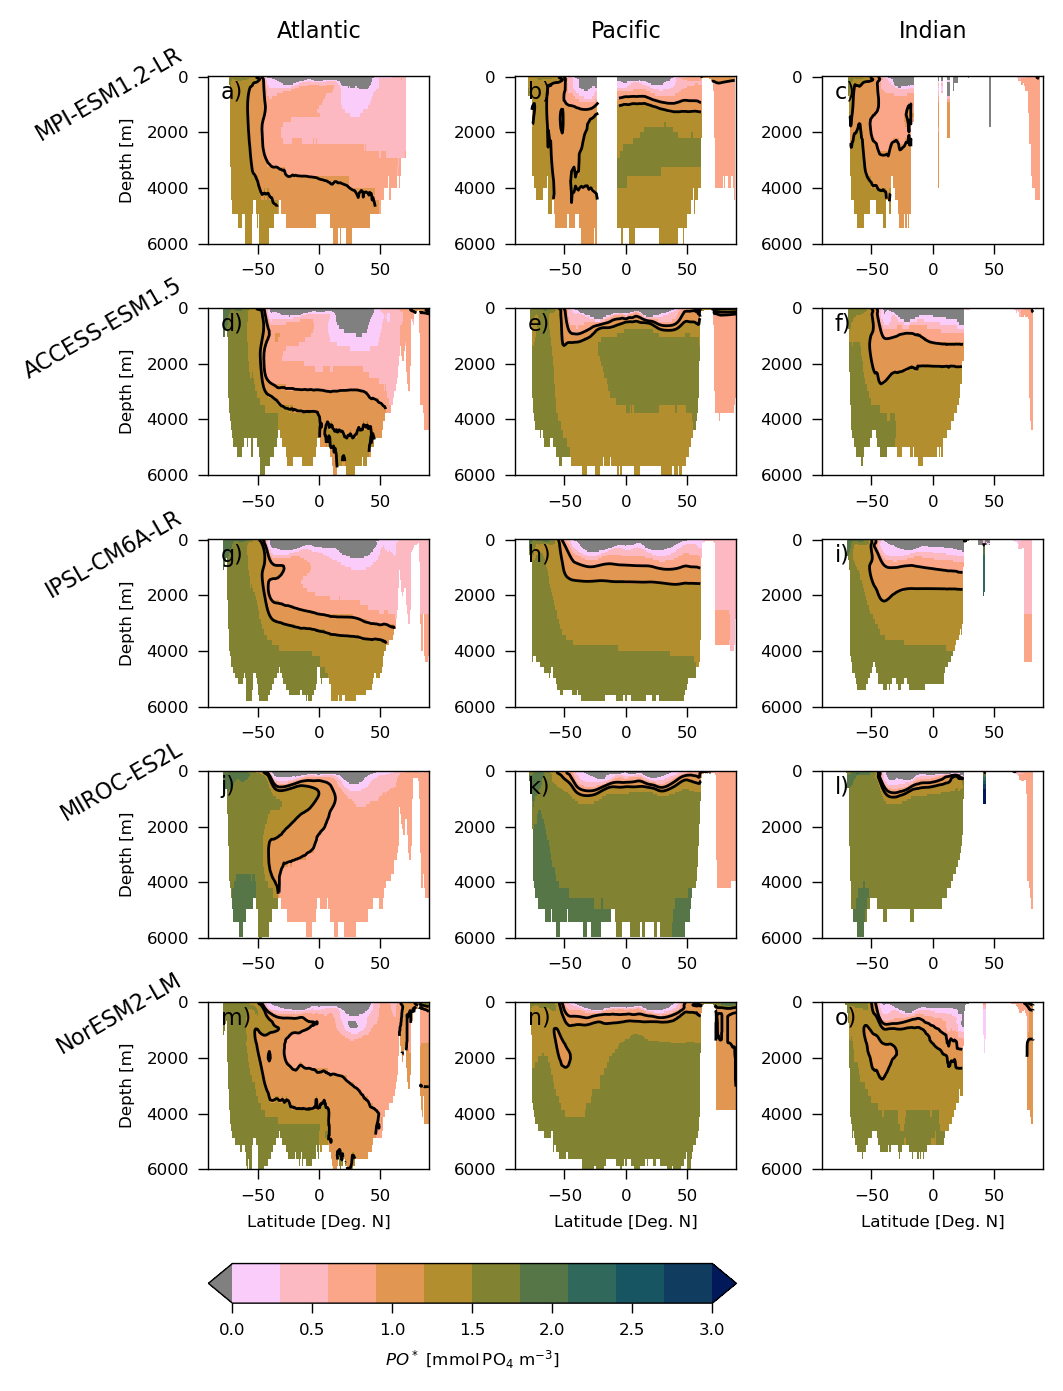

In [15]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Scatter plot ∆AOU vs ∆age and linear regression')
print('## Plot PO-tracer')

#--------------------
# Prepare data2plot
#--------------------

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
data2plot={}
ocean_dict = {'Atlantic': (-60, -10), 'Pacific': (-180, -130), 'Indian':(40, 90)}

for iesm, vesm in enumerate(esm_list): 
    
    print(vesm+'...')
    
    data2plot[vesm] = {}    

    print('    Get po-tracer data...')
    fname = netcdfdir+vesm+'_historical_po_tracer_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds) # in mol.m-3
    zwda_pot = zwds['po-tracer']

    #_________________
    # Get area
    print('    Get area...')
    if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
    else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                  version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwds2 = zwds['areacello'].to_dataset()
    zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
    zwds2 = split_coords_dimensions(zwds2)
    zwds2 = shift_180_lon(zwds2)
    zarea = zwds2['areacello'].load()
    # FOR MPI model, invert latitude dimension
    if vesm == 'MPI-ESM1-2-LR' : 
        zarea = zarea.isel(j=slice(None, None, -1))
    #

    #________________
    # Zonal average on ocean sectors
    print('    Zonal average on ocean sectors...')
    for iii, (kocean, vocean) in enumerate(ocean_dict.items()):

        zwda_avg = zonal_avg(zwda_pot, zarea, longitudes=vocean)
        data2plot[vesm][kocean] = {'X' : zwda_avg.latitude.values, 
                                   'Y' : zwda_avg.depth.values, 
                                   'Z' : zwda_avg.values}
    #
#

#--------------------
# Figure parameters
#--------------------

figname = dirout + 'section_po-tracer_average_on_1986-2009.png'

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
region_list = ['Atlantic', 'Pacific', 'Indian']
zfact = 1000.

#______________
# Figure size
nrow, ncol = len(esm_list), len(region_list)
fwidth_cm, fheight_cm = 4*ncol, 3*nrow
fsize = (fwidth_cm*cm2in, fheight_cm*cm2in) # width, height

#______________
# cmap
a = cmcrameri.cm.batlow_r
colors = a(np.linspace(0,1,10+1))
newcmap = ListedColormap(colors[:-1])
newcmap.set_under('grey')
newcmap.set_over(colors[-1])
newcmap.set_bad("none")

#______________
# pcm keywords
kwpcm = dict(cmap=newcmap, vmin=0, vmax=3)

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]


#______________
# Create figure and axes
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, squeeze=False)


#--------------------
# Plot
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    for iregion, vregion in enumerate(region_list): 

        zax = ax[iesm, iregion]
        xxx = data2plot[vesm][vregion]['X']
        yyy = data2plot[vesm][vregion]['Y']
        ccc = data2plot[vesm][vregion]['Z']*zfact - 1.95
        zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm)
        # zwct = zax.contour(xxx, yyy, ccc, [0.35, 0.91], colors='k')
        zwct = zax.contour(xxx, yyy, ccc, [0.91, 1.2], colors='k')
        pcm[iesm, iregion] = zwpcm
        zax.set_ylim((6000, -10))
        zax.set_xlim((-90, 90))

        ttl = extended_alphabet_reverse.pop() + f')'
        zax.text(-80, 800, ttl)
    #
#

fig.tight_layout()

#--------------------
# Decorate
#--------------------

for iesm, vesm in enumerate(esm_list) : 
    zax = ax[iesm, 0]
    zax.text(-.1, 1.2, esm_name_dict[vesm], transform=zax.transAxes, ha='right', va='top', rotation=30.)
#
for iregion, vregion in enumerate(region_list) : 
    zax = ax[0, iregion]
    zax.text(.5, 1.2, vregion, transform=zax.transAxes, ha='center', va='bottom')
#
        
for zax in ax[:, 0]: zax.set_ylabel('Depth [m]')
for zax in ax[-1, :]: zax.set_xlabel('Latitude [Deg. N]')

#---------------------
# Colorbar
#---------------------

zw1 = ax[-1, 0].get_position()
zw2 = ax[-1, 1].get_position()
nx0 = zw1.x0
ny0 = zw1.y0 - .8*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.06*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='both')
cbar.set_label(r'$PO^*$ [mmol$\,$PO$_4$ m$^{-3}$]')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)


## Compute density average for water mass selection

In [10]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Scatter plot ∆AOU vs ∆age and linear regression group by density')
print('## Compute density average for water mass selection')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
simu = 'historical'
tslice = slice('1986', '2009')

for iesm, vesm in enumerate(esm_list): 

    print('Compute for %s...'%vesm)
    
    #________________
    # Get data
    print('    Get data...')    
    
    var = 'thetao'
    fname_list = [f"{dirshared}{vesm}_{simu}_{var}_{int(year):04}.nc" for year in np.arange(int(tslice.start), int(tslice.stop)+.5)]
    # fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds).sel(year=tslice)
    zwda_temp = zwds[var]

    var = 'so'
    fname_list = [f"{dirshared}{vesm}_{simu}_{var}_{int(year):04}.nc" for year in np.arange(int(tslice.start), int(tslice.stop)+.5)]
    # fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds).sel(year=tslice)
    zwda_sali = zwds[var]

    
    #________________
    # Compute density
    print('    Compute density...')
    zwda_sigma0 = compute_potential_density_anomaly(zwda_temp, zwda_sali).mean(dim='year')
    
    #________________
    # create dataset
    zwda_ds = zwda_sigma0.to_dataset() 

    #________________
    # Save in netcdf
    print('    Save in netcdf...')
    ncname = netcdfdir+f'{vesm}_{simu}_sigma0_average_on_{tslice.start}-{tslice.stop}.nc'
    zwda_ds.to_netcdf(ncname)
    print('    File saved: %s'%ncname)
    
#

2025-03-28 19:41:24.388799
# Scatter plot ∆AOU vs ∆age and linear regression group by density
## Compute density average for water mass selection
Compute for MPI-ESM1-2-LR...
    Get data...
    Compute density...
    Save in netcdf...
    File saved: 25-03-28-figures-for-storyline-v2/netcdf_files/MPI-ESM1-2-LR_historical_sigma0_average_on_1986-2009.nc
Compute for ACCESS-ESM1-5...
    Get data...
    Compute density...
    Save in netcdf...
    File saved: 25-03-28-figures-for-storyline-v2/netcdf_files/ACCESS-ESM1-5_historical_sigma0_average_on_1986-2009.nc
Compute for IPSL-CM6A-LR...
    Get data...
    Compute density...
    Save in netcdf...
[########################################] | 100% Completed | 11.67 s
    File saved: 25-03-28-figures-for-storyline-v2/netcdf_files/IPSL-CM6A-LR_historical_sigma0_average_on_1986-2009.nc
Compute for MIROC-ES2L...
    Get data...
    Compute density...
    Save in netcdf...
    File saved: 25-03-28-figures-for-storyline-v2/netcdf_files/MIROC-ES2

## Define function prep_data2plot

In [9]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Scatter plot ∆AOU vs ∆age and linear regression')
print('## Define function prep_data2plot')

def prep_data2plot(zaou, zage, zcond, zvolume, zomask, zcoloring_dict={}): 

    print('> prep_data2plot...')
    zdata2plot = {}

    #_________________
    # Select water mass   
    print('>> Select water mass...')    
    aou_in_water_mass = zaou.where(zcond, np.nan)
    age_in_water_mass = zage.where(zcond, np.nan)
    volume_in_water_mass = zvolume.where(zcond, np.nan)
    
    #_________________
    # Compute volume and number of cell
    print('>> Compute volume and number of cell')
    zdata2plot['volume'] = volume_in_water_mass.sum().values
    zdata2plot['cells'] = zcond.sum().values

    #_________________
    # Compute maps of water mass distribution
    print('>> Compute water mass distribution')

    zdata2plot['water mass distribution'] = {}

    zw = (xr.where(zcond, 1, 0)).where(zomask.values)    
    zvertical = compute_vertical_average(zw)
    zdata2plot['water mass distribution']['vertical average'] = {
        'xxx': zvertical.longitude.values, 
        'yyy': zvertical.latitude.values, 
        'ccc': zvertical.values
    }
    zzonal = zonal_avg(zw, zvolume)
    zdata2plot['water mass distribution']['zonal average'] = {
        'xxx': zzonal.latitude.values, 
        'yyy': zzonal.depth.values, 
        'ccc': zzonal.values
    }

    #_________________
    # Compute integrated trends
    print('>> Compute integrated trends')
    zdata2plot['integrated aou trend'] = (aou_in_water_mass*volume_in_water_mass).sum(skipna=True).values
    zdata2plot['integrated age trend'] = (age_in_water_mass*volume_in_water_mass).sum(skipna=True).values

    #_________________
    # Compute histograms 2D for entire selected water mass
    print('>> Compute histogram 2D')
    nbins1 = 200
    bounds = [[np.nanmin(age_in_water_mass.values.flatten()),
               np.nanmax(age_in_water_mass.values.flatten())], 
              [np.nanmin(aou_in_water_mass.values.flatten()), 
               np.nanmax(aou_in_water_mass.values.flatten())]]
    hhh = histogram2d(age_in_water_mass.values.flatten(), aou_in_water_mass.values.flatten(), \
                      range=bounds, bins=nbins1).T # need to transpose for visualisation purpose
    xxx = np.linspace(bounds[0][0], bounds[0][1], nbins1)
    yyy = np.linspace(bounds[1][0], bounds[1][1], nbins1)
    zdata2plot['histogram2d'] = {'xxx':xxx, 'yyy':yyy, 'ccc':hhh}

    #_______________
    # compute linear regression
    print('>> Compute linear regression...')
    X = age_in_water_mass.values.flatten()
    Y = aou_in_water_mass.values.flatten()
    index = ~(np.isnan(X) | np.isnan(Y))
    X = X[index]
    Y = Y[index]
    results = stats.linregress(X, Y)
    
    Y_predicted = results.intercept + results.slope * X
    nnn = len(X)  # Number of observations
    t_value = stats.t.ppf(1 - 0.025, nnn - 2)  # t-value for 95% confidence interval with n-2 degrees of freedom
    # Standard error of the predicted y-values 
    s_err = np.sqrt(np.sum((Y - Y_predicted) ** 2) / (nnn - 2))    
    # nb: results.stderr is s_err/np.rmse(X)
    
    #_______________
    # Compute 95% confidence band
    
    # Subsampled X and Y predicted to compute 95% confidence band
    combined = list(zip(X, Y_predicted))
    if nnn>100: sample_size=100
    else: sample_size=nnn
    # Find the minimum and maximum elements based on the `y` values
    min_combined = min(combined, key=lambda pair: pair[0])
    max_combined = max(combined, key=lambda pair: pair[0])
    # Remove these elements from the combined list to sample the rest
    remaining_combined = [pair for pair in combined if pair != min_combined and pair != max_combined]
    # Sample the remaining elements
    remaining_sample_size = sample_size - 2
    import random
    sampled_remaining = random.sample(remaining_combined, remaining_sample_size)
    # Include the min and max elements in the final sample
    sampled_combined = [min_combined] + sampled_remaining + [max_combined]
    sampled_X, sampled_Y_predicted = zip(*sampled_combined)
    # Convert the sampled tuples back to lists (if needed)
    sampled_X = list(sampled_X)
    sampled_Y_predicted = list(sampled_Y_predicted)
    # Combine `xxx` and `yyy` and sort based on `xxx`
    xxx_yyy = sorted(zip(sampled_X, sampled_Y_predicted))
    # Unzip the sorted pairs
    sorted_xxx, sorted_yyy = zip(*xxx_yyy)
    sampled_X = np.array(sorted_xxx)
    sampled_Y_predicted = np.array(sorted_yyy)

    conf_interval = t_value * s_err * np.sqrt(1 / nnn + (sampled_X- np.mean(X))**2 / np.sum((X - np.mean(X))**2))
    lower_band = sampled_Y_predicted - conf_interval
    upper_band = sampled_Y_predicted + conf_interval

    pred_interval = t_value * s_err * np.sqrt(1 + 1 / nnn + (sampled_X- np.mean(X))**2 / np.sum((X - np.mean(X))**2))
    lower_pred_band = sampled_Y_predicted - pred_interval
    upper_pred_band = sampled_Y_predicted + pred_interval

    #_______________
    # Save linregress analysis
    zdata2plot['linregress'] = {}
    zdata2plot['linregress']['slope'] = results.slope
    zdata2plot['linregress']['intercept'] = results.intercept
    zdata2plot['linregress']['rvalue'] = results.rvalue
    zdata2plot['linregress']['pvalue'] = results.pvalue
    zdata2plot['linregress']['stderr'] = results.stderr 
    zdata2plot['linregress']['intercept_stderr'] = results.intercept_stderr
    zdata2plot['linregress']['number of observation'] = nnn
    zdata2plot['linregress']['tvalue'] = t_value
    zdata2plot['linregress']['sampled_X'] = sampled_X
    zdata2plot['linregress']['sampled_Y_predicted'] = sampled_Y_predicted
    zdata2plot['linregress']['lower_band'] = lower_band
    zdata2plot['linregress']['upper_band'] = upper_band
    zdata2plot['linregress']['conf_interval'] = conf_interval
    zdata2plot['linregress']['stderr_pred'] = s_err
    zdata2plot['linregress']['lower_pred_band'] = lower_pred_band
    zdata2plot['linregress']['upper_pred_band'] = upper_pred_band
    zdata2plot['linregress']['conf_interval'] = pred_interval
    
    # xxx = np.array([age_in_water_mass.min(), age_in_water_mass.max()])
    # yyy = slope * xxx + intercept
    # zdata2plot['linregress']['line'] = {'xxx':xxx, 'yyy':yyy}

    #_______________
    # Compute mean of zcoloring_list
    if len(zcoloring_dict)>0: 
        print('>> Compute mean of zcoloring_list...')
        for kcoloring, vcoloring in zcoloring_dict.items():             
            print(f'>>> for {kcoloring}...')
            coloring_in_water_mass = vcoloring.where(zcond, np.nan)            
            zdata2plot[kcoloring] = coloring_2D_bins(age_in_water_mass.values, aou_in_water_mass.values, \
                                                     coloring_in_water_mass.values, nbin=nbins1)
        #
    #
   
    #_______________
    # Compute prediction and prediction error
    X3D = age_in_water_mass.values
    Y3D = aou_in_water_mass.values
    Y3D_predicted = results.intercept + results.slope * X3D
    Y3D_error = Y3D - Y3D_predicted
    Y3D_abserror = np.abs(Y3D - Y3D_predicted)
    
    # Create new DataArray
    aou_in_water_mass_predicted = xr.DataArray(
        Y3D_predicted,
        dims=aou_in_water_mass.dims,
        coords=aou_in_water_mass.coords,
        attrs=aou_in_water_mass.attrs
    )
    aou_in_water_mass_predicted.name = aou_in_water_mass.name

    aou_in_water_mass_error = xr.DataArray(
        Y3D_error,
        dims=aou_in_water_mass.dims,
        coords=aou_in_water_mass.coords,
        attrs=aou_in_water_mass.attrs
    )
    aou_in_water_mass_error.name = aou_in_water_mass.name
    
    aou_in_water_mass_abserror = xr.DataArray(
        Y3D_abserror,
        dims=aou_in_water_mass.dims,
        coords=aou_in_water_mass.coords,
        attrs=aou_in_water_mass.attrs
    )
    aou_in_water_mass_abserror.name = aou_in_water_mass.name


    zdata2plot['aou prediction'] = {}
    #_______________
    # Save prediction
    zdata2plot['aou prediction']['predicted'] = {}
    zdata2plot['aou prediction']['predicted']['3D'] = {
        'xxx': aou_in_water_mass.longitude.values, 
        'yyy': aou_in_water_mass.latitude.values, 
        'zzz': aou_in_water_mass.depth.values, 
        'ccc': Y3D_predicted
    }
    zvertical = compute_vertical_average(aou_in_water_mass_predicted)
    zdata2plot['aou prediction']['predicted']['vertical average'] = {
        'xxx': zvertical.longitude.values, 
        'yyy': zvertical.latitude.values, 
        'ccc': zvertical.values
    }
    zzonal = zonal_avg(aou_in_water_mass_predicted, zvolume)
    zdata2plot['aou prediction']['predicted']['zonal average'] = {
        'xxx': zzonal.latitude.values, 
        'yyy': zzonal.depth.values, 
        'ccc': zzonal.values
    }

    #_______________
    # Save prediction error
    zdata2plot['aou prediction']['error'] = {}
    zdata2plot['aou prediction']['error']['3D'] = {
        'xxx': aou_in_water_mass.longitude.values, 
        'yyy': aou_in_water_mass.latitude.values, 
        'zzz': aou_in_water_mass.depth.values, 
        'ccc': Y3D_error
    }

    zvertical = compute_vertical_average(aou_in_water_mass_error)
    zdata2plot['aou prediction']['error']['vertical average'] = {
        'xxx': zvertical.longitude.values, 
        'yyy': zvertical.latitude.values, 
        'ccc': zvertical.values
    }
    zzonal = zonal_avg(aou_in_water_mass_error, zvolume)
    zdata2plot['aou prediction']['error']['zonal average'] = {
        'xxx': zzonal.latitude.values, 
        'yyy': zzonal.depth.values, 
        'ccc': zzonal.values
    }

    #_______________
    # Save prediction error
    zdata2plot['aou prediction']['absolute error'] = {}
    zdata2plot['aou prediction']['absolute error']['3D'] = {
        'xxx': aou_in_water_mass.longitude.values, 
        'yyy': aou_in_water_mass.latitude.values, 
        'zzz': aou_in_water_mass.depth.values, 
        'ccc': Y3D_abserror
    }
    zvertical = compute_vertical_average(aou_in_water_mass_abserror)
    zdata2plot['aou prediction']['absolute error']['vertical average'] = {
        'xxx': zvertical.longitude.values, 
        'yyy': zvertical.latitude.values, 
        'ccc': zvertical.values
    }
    zzonal = zonal_avg(aou_in_water_mass_abserror, zvolume)
    zdata2plot['aou prediction']['absolute error']['zonal average'] = {
        'xxx': zzonal.latitude.values, 
        'yyy': zzonal.depth.values, 
        'ccc': zzonal.values
    }

    return zdata2plot
#
#----------------
# End define prep_data2plot
#----------------

2025-05-02 10:46:40.834827
# Scatter plot ∆AOU vs ∆age and linear regression
## Define function prep_data2plot
peak memory: 399.23 MiB, increment: 174.32 MiB
CPU times: user 79.3 ms, sys: 13.1 ms, total: 92.3 ms
Wall time: 199 ms


## Prepare data2plot

In [30]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Scatter plot ∆AOU vs ∆age and linear regression')
print('## Prepare data2plot')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
simu = 'historical'
tperiod = '1986-2009'
# simu = 'ssp585'
# tperiod = '2015-2099'

zfact_esm_aou = 1000. # mol.m-3 to mmol.m-3 = umol.l-1

number_of_years_in_picontrol = 2099-1850

#----------------
# Loop on ESM
#----------------

data2plot = {}
for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')

    data2plot[vesm] = {}    

    #----------------
    # Get data
    #----------------
    
    print('    Get aou data...')    
    fname = dirshared+vesm+'_'+simu+'_'+'aou_linregress_on_'+tperiod+'_drift_removed.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_aou = zwds['slope']*zfact_esm_aou 
    zwda_aou_pval = zwds['pvalue']
    
    print('    Get age data...')    
    fname = dirshared+vesm+'_'+simu+'_'+'agessc_linregress_on_'+tperiod+'_drift_removed.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_age = zwds['slope'] # yr.yr-1
    zwda_age_pval = zwds['pvalue']

    print('    Get density data...')
    fname = netcdfdir+vesm+'_historical_sigma0_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds) # in mol.m-3
    zwda_sigma0 = zwds['sigma0']

    print('    Get po-tracer data...')
    fname = netcdfdir+vesm+'_historical_po_tracer_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds) # in mol.m-3
    zwda_pot = zwds['po-tracer']*1000 - 1.95 
 
    # FOR MPI model maybe
    if vesm == 'MPI-ESM1-2-LR' : 
        zwda_aou = zwda_aou.isel(j=slice(None, None, -1))
        zwda_age = zwda_age.isel(j=slice(None, None, -1))
        zwda_aou_pval = zwda_aou_pval.isel(j=slice(None, None, -1))
        zwda_age_pval = zwda_age_pval.isel(j=slice(None, None, -1))
        zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
        zwda_pot = zwda_pot.isel(j=slice(None, None, -1))
    #


    #----------------
    # Compute volume
    #----------------
    print('    Compute volume and omask...')
    if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
    else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                  version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwds2 = zwds['areacello'].to_dataset()
    zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
    zwds2 = split_coords_dimensions(zwds2)
    zwds2 = shift_180_lon(zwds2)
    zarea = zwds2['areacello']
    # FOR MPI model, invert latitude dimension
    if vesm == 'MPI-ESM1-2-LR' : 
        zarea = zarea.isel(j=slice(None, None, -1))
    #

    depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)
    
    omask = ~(zwda_sigma0.isnull()).rename('mask')
    volume = omask * depthickness * zarea 

    del depbounds, depthickness
   
    #----------------
    # Align coordinates
    #----------------
    print('    Align coordinates...')
    # use reindex if the coordinates match but are not aligned
    for zwcoords in zwda_aou.coords : 
        if zwcoords in zwda_age.coords: zwda_age[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in zwda_aou_pval.coords: zwda_aou_pval[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in zwda_age_pval.coords: zwda_age_pval[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in zwda_sigma0.coords: zwda_sigma0[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in zwda_pot.coords: zwda_pot[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in omask.coords: omask[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in volume.coords: volume[zwcoords] = zwda_aou[zwcoords]
    #

    #----------------
    # Define coloring dict
    #----------------
    print('    Define coloring dict...')
    dep3D = expand_coords(zwda_sigma0, 'depth')
    lat3D = expand_coords(zwda_sigma0, 'latitude')
    lon3D = expand_coords(zwda_sigma0, 'longitude')
    
    coloring_dict = {'depth':dep3D, 'latitude':lat3D, 'longitude':lon3D, 'sigma0':zwda_sigma0}
     
    #----------------
    # In different water mass
    #----------------
    
    #_________________
    # Total ocean
    print('    For total ocean...')
    COND_total = omask
    data2plot[vesm]['total'] = prep_data2plot(zwda_aou, zwda_age, COND_total, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Deep ocean
    print('    For deep ocean...')
    COND_deep = COND_total & (dep3D > 1000)
    data2plot[vesm]['deep'] = prep_data2plot(zwda_aou, zwda_age, COND_deep, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Deep ocean significant
    print('    For deep ocean significant...')
    COND_deep_signif = COND_deep &  (zwda_aou_pval<=.05) & (zwda_age_pval<=.05)
    data2plot[vesm]['deep significant'] = prep_data2plot(zwda_aou, zwda_age, COND_deep_signif, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Southern
    print('    For southern waters...')
    po_tracer_trshld = [0.91, 2.]
    COND_southern = COND_deep & (lat3D < 60) & \
            (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
    COND_southern_signif = COND_deep_signif & (lat3D < 60) & \
            (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
    data2plot[vesm]['southern'] = prep_data2plot(zwda_aou, zwda_age, COND_southern_signif, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Density quantile for Southern waters
    quantiles = weighted_quantile(values=zwda_sigma0.where(COND_southern, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                  sample_weight=volume.where(COND_southern, np.nan).values.flatten())
    #_________________
    # Southern densest
    print('    For southern dense waters...')
    COND_southern_dense = COND_southern_signif & (zwda_sigma0 >= quantiles[5])
    data2plot[vesm]['southern dense'] = prep_data2plot(zwda_aou, zwda_age, COND_southern_dense, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Southern lightest
    print('    For southern light waters...')
    COND_southern_light = COND_southern_signif & (zwda_sigma0 < quantiles[5])
    data2plot[vesm]['southern light'] = prep_data2plot(zwda_aou, zwda_age, COND_southern_light, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Atlantic
    print('    For atlantic waters...')
    po_tracer_trshld = [0.35, 0.91]
    COND_atlantic = COND_deep & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
            (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
    COND_atlantic_signif = COND_deep_signif & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
            (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
    data2plot[vesm]['atlantic'] = prep_data2plot(zwda_aou, zwda_age, COND_atlantic_signif, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Density quantile for Atlanntic waters
    quantiles = weighted_quantile(values=zwda_sigma0.where(COND_atlantic, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                  sample_weight=volume.where(COND_atlantic, np.nan).values.flatten())
    #_________________
    # Atlantic densest
    print('    For atlantic dense waters...')
    COND_atlantic_dense = COND_atlantic_signif & (zwda_sigma0 >= quantiles[5])
    data2plot[vesm]['atlantic dense'] = prep_data2plot(zwda_aou, zwda_age, COND_atlantic_dense, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Atlantic lightest
    print('    For atlantic light waters...')
    COND_atlantic_light = COND_atlantic_signif & (zwda_sigma0 < quantiles[5])
    data2plot[vesm]['atlantic light'] = prep_data2plot(zwda_aou, zwda_age, COND_atlantic_light, volume, omask, zcoloring_dict=coloring_dict) 
    
    #_________________
    # Southern and Atlantic water mass
    print('    For southern and atlantic water mass...')
    COND_atl_south = COND_atlantic_signif | COND_southern_signif
    data2plot[vesm]['southern and atlantic'] = prep_data2plot(zwda_aou, zwda_age, COND_atl_south, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # The rest of deep and significant
    print('    For the rest of deep and significant...')
    COND_rest_deep_signif = COND_deep_signif & ~COND_atl_south
    data2plot[vesm]['reminder deep and significant'] = prep_data2plot(zwda_aou, zwda_age, COND_rest_deep_signif, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # The deep and non significant
    print('    For the deep and non significant...')
    COND_deep_non_signif = COND_deep & ~COND_deep_signif
    data2plot[vesm]['deep and non significant'] = prep_data2plot(zwda_aou, zwda_age, COND_deep_non_signif, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # The surface
    print('    For the surface...')
    COND_surf = COND_total & ~COND_deep
    data2plot[vesm]['surface'] = prep_data2plot(zwda_aou, zwda_age, COND_surf, volume, omask, zcoloring_dict=coloring_dict) 
#

#_________________
# Save
savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'.pckl'
with open(savefile, "wb") as file:
    pickle.dump(data2plot, file)
#

print('Done')

2025-05-02 13:55:25.701349
# Scatter plot ∆AOU vs ∆age and linear regression
## Prepare data2plot
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
    Get aou data...
    Get age data...
    Get density data...
    Get po-tracer data...
    Compute volume and omask...
    Align coordinates...
    Define coloring dict...
    For total ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern and atlantic water mass...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the rest of deep and significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the deep and non significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the surface...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
    Get aou data...
    Get age data...
    Get density data...
    Get po-tracer data...
    Compute volume and omask...
    Align coordinates...
    Define coloring dict...
    For total ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern and atlantic water mass...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the rest of deep and significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the deep and non significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the surface...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
    Get aou data...
    Get age data...
    Get density data...
    Get po-tracer data...
    Compute volume and omask...
    Align coordinates...
    Define coloring dict...
    For total ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern and atlantic water mass...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the rest of deep and significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the deep and non significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the surface...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-----------------------
Prepare data for MIROC-ES2L...
-----------------------
    Get aou data...
    Get age data...
    Get density data...
    Get po-tracer data...
    Compute volume and omask...
    Align coordinates...
    Define coloring dict...
    For total ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern and atlantic water mass...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the rest of deep and significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the deep and non significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the surface...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-----------------------
Prepare data for NorESM2-LM...
-----------------------
    Get aou data...
    Get age data...
    Get density data...
    Get po-tracer data...
    Compute volume and omask...
    Align coordinates...
    Define coloring dict...
    For total ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern and atlantic water mass...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the rest of deep and significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the deep and non significant...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the surface...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Done
peak memory: 68832.88 MiB, increment: 42308.16 MiB
CPU times: user 5min 40s, sys: 3min 44s, total: 9min 24s
Wall time: 14min 51s


## Prepare data2plot but just to get density thresholds

In [13]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Scatter plot ∆AOU vs ∆age and linear regression')
print('## Prepare data2plot but just to get density thresholds')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
# simu = 'historical'
# tperiod = '1986-2009'
simu = 'ssp585'
tperiod = '2015-2099'

zfact_esm_aou = 1000. # mol.m-3 to mmol.m-3 = umol.l-1

number_of_years_in_picontrol = 2099-1850

#----------------
# Loop on ESM
#----------------

data2plot = {}
for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Get density thresholds for %s...'%vesm)
    print('-----------------------')

    data2plot[vesm] = {}    

    #----------------
    # Get data
    #----------------
    
    fname = dirshared+vesm+'_'+simu+'_'+'aou_linregress_on_'+tperiod+'_drift_removed.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_aou = zwds['slope']*zfact_esm_aou 
    zwda_aou_pval = zwds['pvalue']
    
    fname = dirshared+vesm+'_'+simu+'_'+'agessc_linregress_on_'+tperiod+'_drift_removed.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_age = zwds['slope'] # yr.yr-1
    zwda_age_pval = zwds['pvalue']

    fname = netcdfdir+vesm+'_historical_sigma0_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds) # in mol.m-3
    zwda_sigma0 = zwds['sigma0']

    fname = netcdfdir+vesm+'_historical_po_tracer_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds) # in mol.m-3
    zwda_pot = zwds['po-tracer']*1000 - 1.95 
 
    # FOR MPI model maybe
    if vesm == 'MPI-ESM1-2-LR' : 
        zwda_aou = zwda_aou.isel(j=slice(None, None, -1))
        zwda_age = zwda_age.isel(j=slice(None, None, -1))
        zwda_aou_pval = zwda_aou_pval.isel(j=slice(None, None, -1))
        zwda_age_pval = zwda_age_pval.isel(j=slice(None, None, -1))
        zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
        zwda_pot = zwda_pot.isel(j=slice(None, None, -1))
    #


    #----------------
    # Compute volume
    #----------------
    if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
    else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                  version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwds2 = zwds['areacello'].to_dataset()
    zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
    zwds2 = split_coords_dimensions(zwds2)
    zwds2 = shift_180_lon(zwds2)
    zarea = zwds2['areacello']
    # FOR MPI model, invert latitude dimension
    if vesm == 'MPI-ESM1-2-LR' : 
        zarea = zarea.isel(j=slice(None, None, -1))
    #

    depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)
    
    omask = ~(zwda_sigma0.isnull()).rename('mask')
    volume = omask * depthickness * zarea 

    del depbounds, depthickness
   
    #----------------
    # Align coordinates
    #----------------
    # use reindex if the coordinates match but are not aligned
    for zwcoords in zwda_aou.coords : 
        if zwcoords in zwda_age.coords: zwda_age[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in zwda_aou_pval.coords: zwda_aou_pval[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in zwda_age_pval.coords: zwda_age_pval[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in zwda_sigma0.coords: zwda_sigma0[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in zwda_pot.coords: zwda_pot[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in omask.coords: omask[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in volume.coords: volume[zwcoords] = zwda_aou[zwcoords]
    #

    #----------------
    # Define coloring dict
    #----------------
    dep3D = expand_coords(zwda_sigma0, 'depth')
    lat3D = expand_coords(zwda_sigma0, 'latitude')
    lon3D = expand_coords(zwda_sigma0, 'longitude')
    
    coloring_dict = {'depth':dep3D, 'latitude':lat3D, 'longitude':lon3D, 'sigma0':zwda_sigma0}
     
    #----------------
    # In different water mass significant
    #----------------
    
    print('\n    >>> Only significant point <<<')
    COND_total = omask
    COND_deep = COND_total & (dep3D > 1000)
    COND_deep_signif = COND_deep &  (zwda_aou_pval<=.05) & (zwda_age_pval<=.05)
    po_tracer_trshld = [0.91, 2.]

    #_________________
    # Southern waters
    COND_southern = COND_deep_signif & (lat3D < 60) & \
        (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])

    quantiles = weighted_quantile(values=zwda_sigma0.where(COND_southern, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                  sample_weight=volume.where(COND_southern, np.nan).values.flatten())
    print(f'    Southern dense waters: sigma0 >= {quantiles[5]}')
    print(f'    Southern light waters: sigma0 < {quantiles[5]}')

    #_________________
    # Atlantic
    po_tracer_trshld = [0.35, 0.91]
    COND_atlantic = COND_deep_signif & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
            (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
    quantiles = weighted_quantile(values=zwda_sigma0.where(COND_atlantic, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                  sample_weight=volume.where(COND_atlantic, np.nan).values.flatten())
    print(f'    Atlantic dense waters: sigma0 >= {quantiles[5]}')
    print(f'    Atlantic light waters: sigma0 < {quantiles[5]}')
    
    #----------------
    # In different water mass significant
    #----------------
    
    print('\n    >>> Including non-significant point <<<')
    COND_total = omask
    COND_deep = COND_total & (dep3D > 1000)

    #_________________
    # Southern waters
    po_tracer_trshld = [0.91, 2.]
    COND_southern = COND_deep & (lat3D < 60) & \
        (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])

    quantiles = weighted_quantile(values=zwda_sigma0.where(COND_southern, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                  sample_weight=volume.where(COND_southern, np.nan).values.flatten())
    print(f'    Southern dense waters: sigma0 >= {quantiles[5]}')
    print(f'    Southern light waters: sigma0 < {quantiles[5]}')

    #_________________
    # Atlantic
    po_tracer_trshld = [0.35, 0.91]
    COND_atlantic = COND_deep & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
            (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
    quantiles = weighted_quantile(values=zwda_sigma0.where(COND_atlantic, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                  sample_weight=volume.where(COND_atlantic, np.nan).values.flatten())
    print(f'    Atlantic dense waters: sigma0 >= {quantiles[5]}')
    print(f'    Atlantic light waters: sigma0 < {quantiles[5]}')
    
    print('\n')
    

#
print('Done')

2025-04-28 18:26:09.529399
# Scatter plot ∆AOU vs ∆age and linear regression
## Prepare data2plot but just to get density thresholds
-----------------------
Get density thresholds for MPI-ESM1-2-LR...
-----------------------

    >>> Only significant point <<<
    Southern dense waters: sigma0 >= 27.716276425146244
    Southern light waters: sigma0 < 27.716276425146244
    Atlantic dense waters: sigma0 >= 27.711446909093272
    Atlantic light waters: sigma0 < 27.711446909093272

    >>> Only significant point <<<
    Southern dense waters: sigma0 >= 27.712569506979513
    Southern light waters: sigma0 < 27.712569506979513
    Atlantic dense waters: sigma0 >= 27.70936410167805
    Atlantic light waters: sigma0 < 27.70936410167805


-----------------------
Get density thresholds for ACCESS-ESM1-5...
-----------------------

    >>> Only significant point <<<
    Southern dense waters: sigma0 >= 27.811635585788384
    Southern light waters: sigma0 < 27.811635585788384
    Atlantic dense w

## Including low significance point

### Prepare data2plot

In [12]:
%%time
%%memit -c
print(datetime.datetime.now())
# ca. 10min
print('# Scatter plot ∆AOU vs ∆age and linear regression')
print('## Including low significance point')
print('### Prepare data2plot')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
# simu = 'historical'
# tperiod = '1986-2009'
simu = 'ssp585'
tperiod = '2015-2099'

zfact_esm_aou = 1000. # mol.m-3 to mmol.m-3 = umol.l-1

number_of_years_in_picontrol = 2099-1850

#----------------
# Loop on ESM
#----------------

data2plot = {}
for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')

    data2plot[vesm] = {}    

    #----------------
    # Get data
    #----------------
    
    print('    Get aou data...')    
    fname = dirshared+vesm+'_'+simu+'_'+'aou_linregress_on_'+tperiod+'_drift_removed.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_aou = zwds['slope']*zfact_esm_aou 
    
    print('    Get age data...')    
    fname = dirshared+vesm+'_'+simu+'_'+'agessc_linregress_on_'+tperiod+'_drift_removed.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_age = zwds['slope'] # yr.yr-1

    print('    Get density data...')
    fname = netcdfdir+vesm+'_historical_sigma0_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds) # in mol.m-3
    zwda_sigma0 = zwds['sigma0']

    print('    Get po-tracer data...')
    fname = netcdfdir+vesm+'_historical_po_tracer_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds) # in mol.m-3
    zwda_pot = zwds['po-tracer']*1000 - 1.95
 
    # FOR MPI model maybe
    if vesm == 'MPI-ESM1-2-LR' : 
        zwda_aou = zwda_aou.isel(j=slice(None, None, -1))
        zwda_age = zwda_age.isel(j=slice(None, None, -1))
        zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
        zwda_pot = zwda_pot.isel(j=slice(None, None, -1))
    #


    #----------------
    # Compute volume
    #----------------
    print('    Compute volume and omask...')
    if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
    else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                  version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwds2 = zwds['areacello'].to_dataset()
    zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
    zwds2 = split_coords_dimensions(zwds2)
    zwds2 = shift_180_lon(zwds2)
    zarea = zwds2['areacello']
    # FOR MPI model, invert latitude dimension
    if vesm == 'MPI-ESM1-2-LR' : 
        zarea = zarea.isel(j=slice(None, None, -1))
    #

    depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)
    
    omask = ~(zwda_sigma0.isnull()).rename('mask')
    volume = omask * depthickness * zarea 

    del depbounds, depthickness
   
    #----------------
    # Align coordinates
    #----------------
    print('    Align coordinates...')
    # use reindex if the coordinates match but are not aligned
    for zwcoords in zwda_aou.coords : 
        if zwcoords in zwda_age.coords: zwda_age[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in zwda_sigma0.coords: zwda_sigma0[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in zwda_pot.coords: zwda_pot[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in omask.coords: omask[zwcoords] = zwda_aou[zwcoords]
        if zwcoords in volume.coords: volume[zwcoords] = zwda_aou[zwcoords]
    #

    #----------------
    # Define coloring dict
    #----------------
    print('    Define coloring dict...')
    dep3D = expand_coords(zwda_sigma0, 'depth')
    lat3D = expand_coords(zwda_sigma0, 'latitude')
    lon3D = expand_coords(zwda_sigma0, 'longitude')
    
    coloring_dict = {'depth':dep3D, 'latitude':lat3D, 'longitude':lon3D, 'sigma0':zwda_sigma0}
     
    #----------------
    # In different water mass
    #----------------
    
    #_________________
    # Total ocean
    print('    For total ocean...')
    COND_total = omask
    data2plot[vesm]['total'] = prep_data2plot(zwda_aou, zwda_age, COND_total, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Deep ocean
    print('    For deep ocean...')
    COND_deep = COND_total & (dep3D > 1000)
    data2plot[vesm]['deep'] = prep_data2plot(zwda_aou, zwda_age, COND_deep, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Southern
    print('    For southern waters...')
    po_tracer_trshld = [0.91, 2]
    COND_southern = COND_deep & (lat3D < 60) & \
            (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
    data2plot[vesm]['southern'] = prep_data2plot(zwda_aou, zwda_age, COND_southern, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Density quantile for Southern waters
    quantiles = weighted_quantile(values=zwda_sigma0.where(COND_southern, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                  sample_weight=volume.where(COND_southern, np.nan).values.flatten())
    #_________________
    # Southern densest
    print('    For southern dense waters...')
    COND_southern_dense = COND_southern & (zwda_sigma0 >= quantiles[5])
    data2plot[vesm]['southern dense'] = prep_data2plot(zwda_aou, zwda_age, COND_southern_dense, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Southern lightest
    print('    For southern light waters...')
    COND_southern_light = COND_southern & (zwda_sigma0 < quantiles[5])
    data2plot[vesm]['southern light'] = prep_data2plot(zwda_aou, zwda_age, COND_southern_light, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Atlantic
    print('    For atlantic waters...')
    po_tracer_trshld = [0.35, 0.91]
    COND_atlantic = COND_deep & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
            (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
    data2plot[vesm]['atlantic'] = prep_data2plot(zwda_aou, zwda_age, COND_atlantic, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Density quantile for Atlanntic waters
    quantiles = weighted_quantile(values=zwda_sigma0.where(COND_atlantic, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                  sample_weight=volume.where(COND_atlantic, np.nan).values.flatten())
    #_________________
    # Atlantic densest
    print('    For atlantic dense waters...')
    COND_atlantic_dense = COND_atlantic & (zwda_sigma0 >= quantiles[5])
    data2plot[vesm]['atlantic dense'] = prep_data2plot(zwda_aou, zwda_age, COND_atlantic_dense, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # Atlantic lightest
    print('    For atlantic light waters...')
    COND_atlantic_light = COND_atlantic & (zwda_sigma0 < quantiles[5])
    data2plot[vesm]['atlantic light'] = prep_data2plot(zwda_aou, zwda_age, COND_atlantic_light, volume, omask, zcoloring_dict=coloring_dict) 
    
    #_________________
    # Southern and Atlantic water mass
    print('    For southern and atlantic water mass...')
    COND_atl_south = COND_atlantic | COND_southern
    data2plot[vesm]['southern and atlantic'] = prep_data2plot(zwda_aou, zwda_age, COND_atl_south, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # The rest of deep
    print('    For the rest of deep...')
    COND_rest_deep_signif = COND_deep & ~COND_atl_south
    data2plot[vesm]['reminder deep'] = prep_data2plot(zwda_aou, zwda_age, COND_rest_deep_signif, volume, omask, zcoloring_dict=coloring_dict) 

    #_________________
    # The surface
    print('    For the surface...')
    COND_surf = COND_total & ~COND_deep
    data2plot[vesm]['surface'] = prep_data2plot(zwda_aou, zwda_age, COND_surf, volume, omask, zcoloring_dict=coloring_dict) 
#

#_________________
# Save
savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'_include_low_significant_trend.pckl'
with open(savefile, "wb") as file:
    pickle.dump(data2plot, file)
#

print('Done')

2025-03-29 10:57:50.754781
# Scatter plot ∆AOU vs ∆age and linear regression
## Including low significance point
### Prepare data2plot
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
    Get aou data...
    Get age data...
    Get density data...
    Get po-tracer data...
    Compute volume and omask...
    Align coordinates...
    Define coloring dict...
    For total ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern and atlantic water mass...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the rest of deep...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the surface...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
    Get aou data...
    Get age data...
    Get density data...
    Get po-tracer data...
    Compute volume and omask...
    Align coordinates...
    Define coloring dict...
    For total ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern and atlantic water mass...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the rest of deep...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the surface...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
    Get aou data...
    Get age data...
    Get density data...
    Get po-tracer data...
    Compute volume and omask...
    Align coordinates...
    Define coloring dict...
    For total ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern and atlantic water mass...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the rest of deep...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the surface...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-----------------------
Prepare data for MIROC-ES2L...
-----------------------
    Get aou data...
    Get age data...
    Get density data...
    Get po-tracer data...
    Compute volume and omask...
    Align coordinates...
    Define coloring dict...
    For total ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern and atlantic water mass...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the rest of deep...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the surface...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


-----------------------
Prepare data for NorESM2-LM...
-----------------------
    Get aou data...
    Get age data...
    Get density data...
    Get po-tracer data...
    Compute volume and omask...
    Align coordinates...
    Define coloring dict...
    For total ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For deep ocean...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic dense waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For atlantic light waters...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For southern and atlantic water mass...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the rest of deep...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


    For the surface...
> prep_data2plot...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...
>>> for sigma0...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Done
peak memory: 30386.13 MiB, increment: 18687.17 MiB
CPU times: user 4min 25s, sys: 2min 24s, total: 6min 49s
Wall time: 10min 40s


## Plot: scatter plot

2025-05-05 14:58:43.582678
# Scatter plot ∆AOU vs ∆age and linear regression
## Plot: scatter plot
Save figure...
Figure saved: 25-03-28-figures-for-storyline-v2/scatter_plot_aou_trend_vs_age_trend_ssp585_2015-2099.png
peak memory: 33540.64 MiB, increment: 21155.86 MiB
CPU times: user 4.34 s, sys: 6.13 s, total: 10.5 s
Wall time: 13.8 s


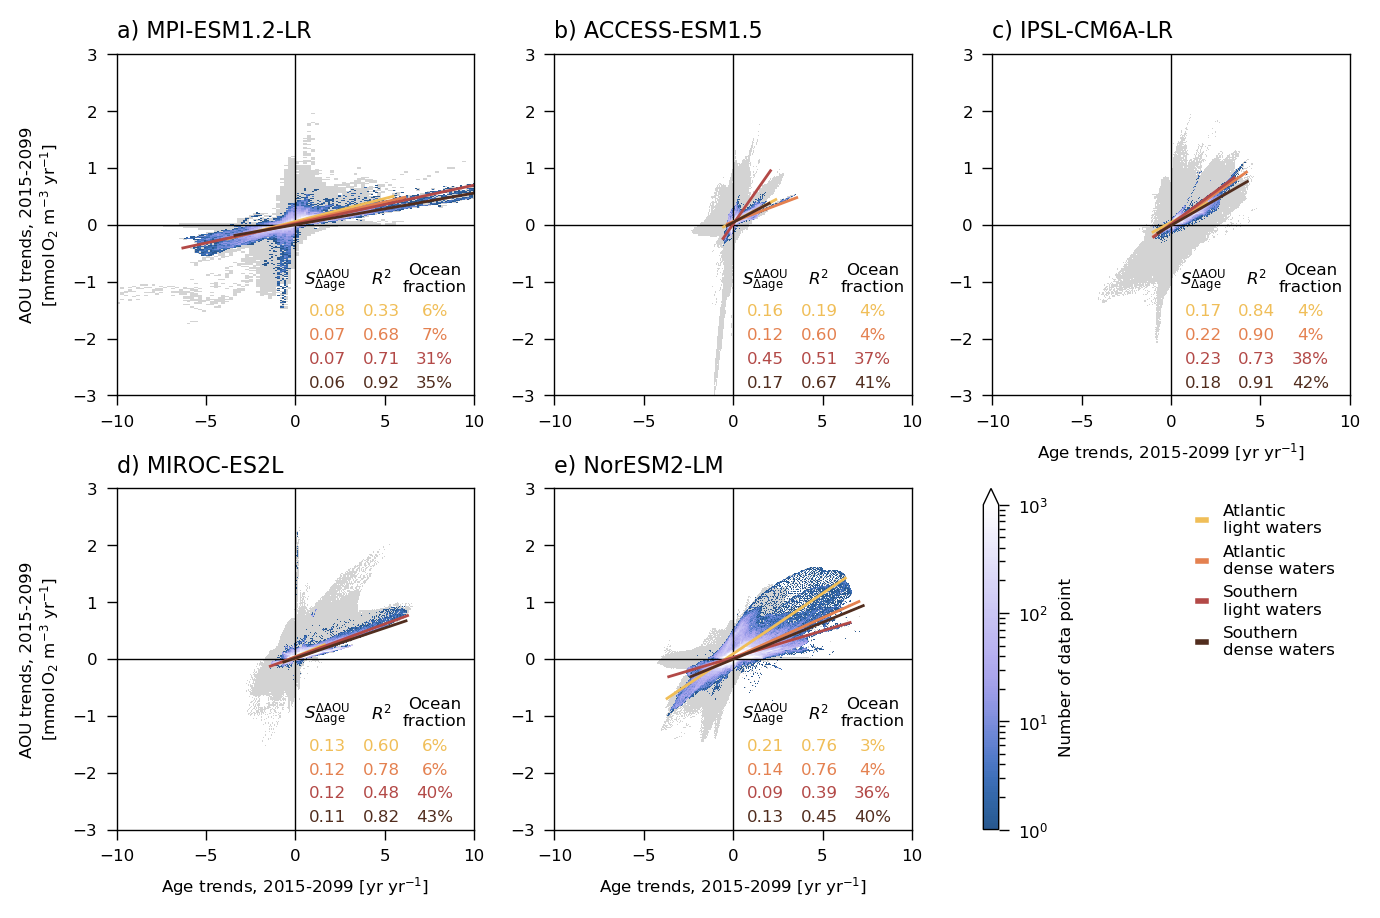

In [26]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Scatter plot ∆AOU vs ∆age and linear regression')
print('## Plot: scatter plot')

#____________________
# Load data2plot

# simu = 'historical'
# tperiod = '1986-2009'
simu = 'ssp585'
tperiod = '2015-2099'
savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'.pckl'
# Open the pickle file in binary read mode
with open(savefile, 'rb') as file:
    # Load the dictionary from the pickle file
    data2plot = pickle.load(file)
#

#--------------------
# Figure parameters
#--------------------

#____________________
# figname
figname = savefile.replace('data2plot', 'scatter_plot').replace('.pckl', '.png')

#____________________
# list
esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
region_list = ['atlantic light', 'atlantic dense', 'southern light', 'southern dense']

#____________________
# Figure
fwidth_cm, fheight_cm = 17, 11.3333
nrow, ncol = 2, 3
fsize = (fwidth_cm*cm2in, fheight_cm*cm2in) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, squeeze=False)

#____________________
# labels
region_label_dict = {
    'southern dense': 'Southern\ndense waters', 
    'southern light': 'Southern\nlight waters', 
    'atlantic dense': 'Atlantic\ndense waters', 
    'atlantic light': 'Atlantic\nlight waters', 
}
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]


#____________________
# Colors and maps
a = cmcrameri.cm.lajolla
colors = a(np.linspace(0,1,250))
region_color_dict = {
    'southern dense': colors[50],
    'southern light': colors[50*2],
    'atlantic dense': colors[50*3],
    'atlantic light': colors[50*4]
} 

#______________
# cmap
a = cmcrameri.cm.devon
colors = a(np.linspace(0,1,200))
newcmap = ListedColormap(colors[50:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[49])
newcmap.set_bad("none")

# a = cm.Wistia
# colors = a(np.linspace(0,1,300))
# newcmap = ListedColormap(colors[30:-1])
# newcmap.set_over(colors[-1])
# newcmap.set_under(colors[29])
# newcmap.set_bad("none")

#____________________
# keywords args
kwpcm = {
    'southern and atlantic': dict(cmap = newcmap, norm=mpl.colors.LogNorm(vmin=1, vmax=1000)), 
    'total': dict(cmap=ListedColormap(['#D3D3D3']), norm=mpl.colors.LogNorm(vmin=1, vmax=1000))
}


xlim = (-10, 10)
ylim = ( -3,  3)

#--------------------
# Plot
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    

    zax = ax.flat[iesm]
    zax.axhline(0, lw=.5, c='k')
    zax.axvline(0, lw=.5, c='k')
    ttl = alphabet_reverse.pop()+') '+esm_name_dict[vesm]
    zax.set_title(ttl, loc='left')
    zax.set_xlim(xlim)
    zax.set_ylim(ylim)

    #____________________
    # Full scatter plot in background

    sel_scatter = 'total'
    xxx = data2plot[vesm][sel_scatter]['histogram2d']['xxx']
    yyy = data2plot[vesm][sel_scatter]['histogram2d']['yyy']
    ccc = data2plot[vesm][sel_scatter]['histogram2d']['ccc']
    zax.pcolormesh(xxx, yyy, ccc, **kwpcm[sel_scatter])

    #____________________
    # Selected scatter plot

    sel_scatter = 'southern and atlantic'
    xxx = data2plot[vesm][sel_scatter]['histogram2d']['xxx']
    yyy = data2plot[vesm][sel_scatter]['histogram2d']['yyy']
    ccc = data2plot[vesm][sel_scatter]['histogram2d']['ccc']
    zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm[sel_scatter])
    pcm.flat[iesm] = zwpcm

    #____________________
    # Add regression lines
    lines = []
    tab_row1 = []
    tab_row2 = []
    tab_row3 = []
    for region in region_list:

        xxx = data2plot[vesm][region]['linregress']['sampled_X']
        yyy = data2plot[vesm][region]['linregress']['sampled_Y_predicted']
        yyymin = data2plot[vesm][region]['linregress']['lower_band']
        yyymax = data2plot[vesm][region]['linregress']['upper_band']
        # yyymin = data2plot[vesm][region]['linregress']['lower_pred_band']
        # yyymax = data2plot[vesm][region]['linregress']['upper_pred_band']

        zax.fill_between(xxx, yyymin, yyymax, color=region_color_dict[region], alpha=0.5, lw=0)
        ll, = zax.plot(xxx, yyy, label=region_label_dict[region], color=region_color_dict[region], lw=1)
        lines.append(ll)

                
        #____________________
        # Save some notes for table
        slope = data2plot[vesm][region]['linregress']['slope']
        rvalue = data2plot[vesm][region]['linregress']['rvalue']
        # ocean_frac = data2plot[vesm][region]['volume']/data2plot[vesm]['total']['volume']*100        
        ocean_frac = data2plot[vesm][region]['volume']/data2plot[vesm]['deep']['volume']*100        
        tab_row1.append(f'{np.floor(rvalue**2*100)/100:.2f}')
        tab_row2.append(f'{ocean_frac:.0f}%')
        tab_row3.append(f'{slope:.2f}')
        
        
    #
    #____________________
    # add notes
    kwtext = dict(ha='center', va='center_baseline', fontsize=6)
    # kwtext = dict(ha='center', va='top', fontsize=6)
    ytxt = .35 #.97
    xtxt1 = .5+.09
    xtxt2 = xtxt1+.15
    xtxt3 = xtxt2+.15
    zax.text(xtxt1, ytxt, r'$S_{\mathrm{\Delta age}}^{\mathrm{\Delta AOU}}$', transform=zax.transAxes, color='k', **kwtext)
    # zax.text(xtxt1, ytxt, r'Slope', transform=zax.transAxes, color='k', **kwtext)
    zax.text(xtxt2, ytxt, '$R^2$'    , transform=zax.transAxes, color='k', **kwtext)
    zax.text(xtxt3, ytxt, 'Ocean\nfraction', transform=zax.transAxes, color='k', **kwtext)
    ytxt-=.1
    for iregion, vregion in enumerate(region_list): 
        zax.text(xtxt2, ytxt, tab_row1[iregion], transform=zax.transAxes, color=region_color_dict[vregion], **kwtext)
        zax.text(xtxt3, ytxt, tab_row2[iregion], transform=zax.transAxes, color=region_color_dict[vregion], **kwtext)
        zax.text(xtxt1, ytxt, tab_row3[iregion], transform=zax.transAxes, color=region_color_dict[vregion], **kwtext)
        ytxt-=.07
    #
    
#

fig.tight_layout()
        
#--------------------
# Decorate
#--------------------

ax.flat[-1].axis('off')

#____________________
# legend
handles = [plt.Line2D([0], [0], marker='None', linestyle='-', label=region_label_dict[region], color=region_color_dict[region], lw=2) for region in region_list]
zax = ax.flat[-1]
zax.legend(handles=handles, handlelength=0.5, frameon=False, handletextpad=1, loc='upper right', bbox_to_anchor=(1, 1))

#____________________
# axis labels
for zax in ax[: , 0]: zax.set_ylabel(f'AOU trends, {tperiod}\n'+r'[mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]')
for zax in ax[-1, :]: zax.set_xlabel(f'Age trends, {tperiod} '+r'[yr yr$^{-1}$]')
ax[0, -1].set_xlabel(f'Age trends, {tperiod} '+r'[yr yr$^{-1}$]')

#---------------------
# Colorbar
#---------------------

zw1 = ax.flat[-2].get_position()
nx0 = zw1.x1 + .2*zw1.width
ny0 = zw1.y0
nh  = zw1.height
nw  = 0.03*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='vertical', \
                    ticklocation='right', extend='max')
cbar.set_label(r'Number of data point')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)



## Plot: scatter plot include low significance point

2025-05-05 15:01:42.389350
# Scatter plot ∆AOU vs ∆age and linear regression
## Plot: scatter plot include low significance point
Save figure...
Figure saved: 25-03-28-figures-for-storyline-v2/scatter_plot_aou_trend_vs_age_trend_historical_1986-2009_include_low_significant_trend.png
peak memory: 29163.68 MiB, increment: 17940.82 MiB
CPU times: user 3.96 s, sys: 5.47 s, total: 9.43 s
Wall time: 11.2 s


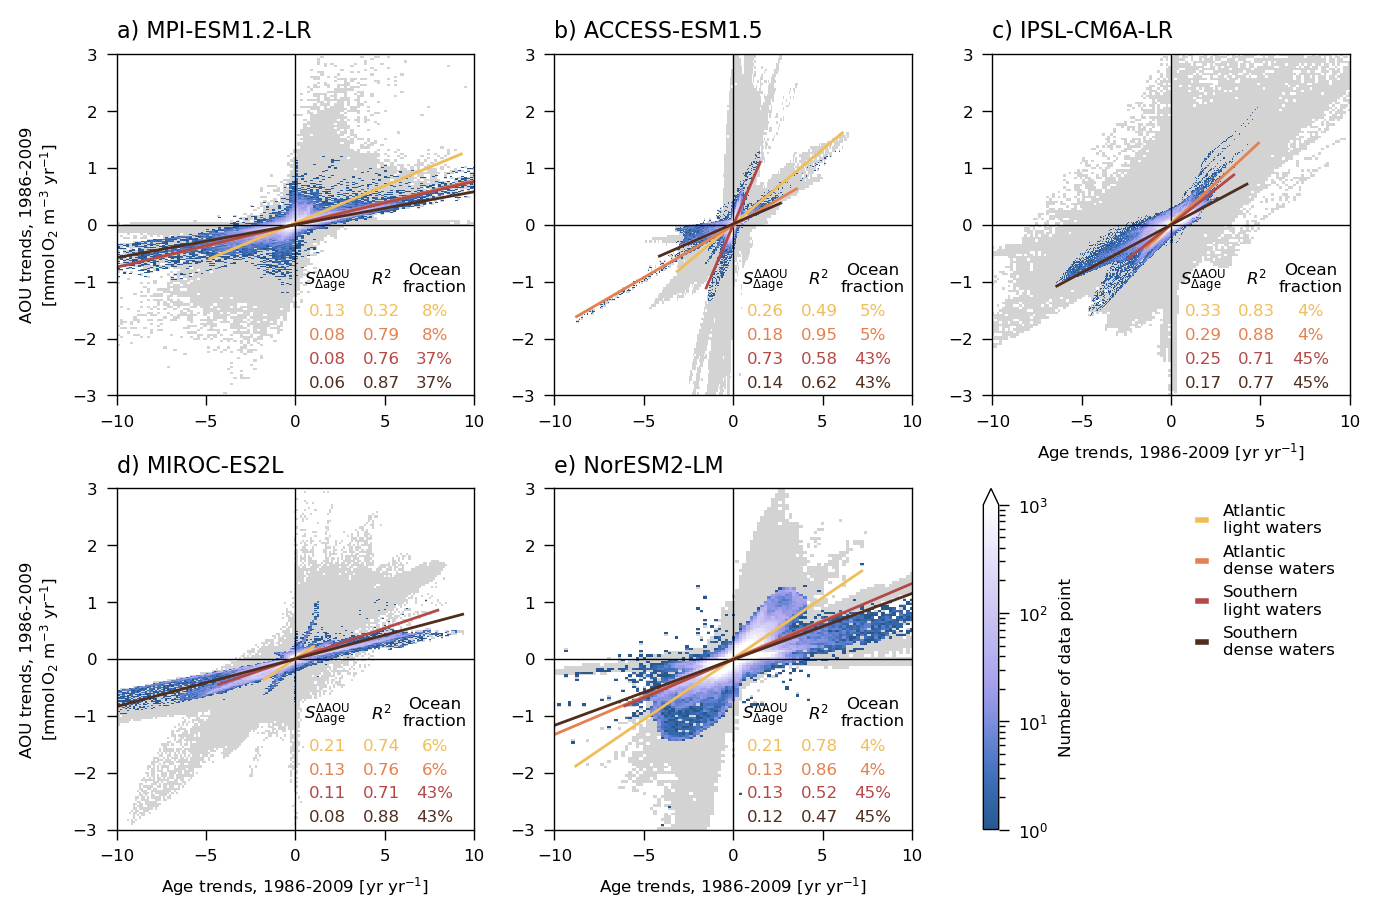

In [28]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Scatter plot ∆AOU vs ∆age and linear regression')
print('## Plot: scatter plot include low significance point')

#____________________
# Load data2plot

simu = 'historical'
tperiod = '1986-2009'
# simu = 'ssp585'
# tperiod = '2015-2099'
savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'_include_low_significant_trend.pckl'
# Open the pickle file in binary read mode
with open(savefile, 'rb') as file:
    # Load the dictionary from the pickle file
    data2plot = pickle.load(file)
#

#--------------------
# Figure parameters
#--------------------

#____________________
# figname
figname = savefile.replace('data2plot', 'scatter_plot').replace('.pckl', '.png')

#____________________
# list
esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
region_list = ['atlantic light', 'atlantic dense', 'southern light', 'southern dense']

#____________________
# Figure
fwidth_cm, fheight_cm = 17, 11.3333
nrow, ncol = 2, 3
fsize = (fwidth_cm*cm2in, fheight_cm*cm2in) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, squeeze=False)

#____________________
# labels
region_label_dict = {
    'southern dense': 'Southern\ndense waters', 
    'southern light': 'Southern\nlight waters', 
    'atlantic dense': 'Atlantic\ndense waters', 
    'atlantic light': 'Atlantic\nlight waters', 
}
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]


#____________________
# Colors and maps
a = cmcrameri.cm.lajolla
colors = a(np.linspace(0,1,250))
region_color_dict = {
    'southern dense': colors[50],
    'southern light': colors[50*2],
    'atlantic dense': colors[50*3],
    'atlantic light': colors[50*4]
} 

#______________
# cmap
a = cmcrameri.cm.devon
colors = a(np.linspace(0,1,200))
newcmap = ListedColormap(colors[50:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[49])
newcmap.set_bad("none")

# a = cm.Wistia
# colors = a(np.linspace(0,1,300))
# newcmap = ListedColormap(colors[30:-1])
# newcmap.set_over(colors[-1])
# newcmap.set_under(colors[29])
# newcmap.set_bad("none")

#____________________
# keywords args
kwpcm = {
    'southern and atlantic': dict(cmap = newcmap, norm=mpl.colors.LogNorm(vmin=1, vmax=1000)), 
    'total': dict(cmap=ListedColormap(['#D3D3D3']), norm=mpl.colors.LogNorm(vmin=1, vmax=1000))
}


xlim = (-10, 10)
ylim = ( -3,  3)

#--------------------
# Plot
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    

    zax = ax.flat[iesm]
    zax.axhline(0, lw=.5, c='k')
    zax.axvline(0, lw=.5, c='k')
    ttl = alphabet_reverse.pop()+') '+esm_name_dict[vesm]
    zax.set_title(ttl, loc='left')
    zax.set_xlim(xlim)
    zax.set_ylim(ylim)

    #____________________
    # Full scatter plot in background

    sel_scatter = 'total'
    xxx = data2plot[vesm][sel_scatter]['histogram2d']['xxx']
    yyy = data2plot[vesm][sel_scatter]['histogram2d']['yyy']
    ccc = data2plot[vesm][sel_scatter]['histogram2d']['ccc']
    zax.pcolormesh(xxx, yyy, ccc, **kwpcm[sel_scatter])

    #____________________
    # Selected scatter plot

    sel_scatter = 'southern and atlantic'
    xxx = data2plot[vesm][sel_scatter]['histogram2d']['xxx']
    yyy = data2plot[vesm][sel_scatter]['histogram2d']['yyy']
    ccc = data2plot[vesm][sel_scatter]['histogram2d']['ccc']
    zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm[sel_scatter])
    pcm.flat[iesm] = zwpcm

    #____________________
    # Add regression lines
    lines = []
    tab_row1 = []
    tab_row2 = []
    tab_row3 = []
    for region in region_list:

        xxx = data2plot[vesm][region]['linregress']['sampled_X']
        yyy = data2plot[vesm][region]['linregress']['sampled_Y_predicted']
        yyymin = data2plot[vesm][region]['linregress']['lower_band']
        yyymax = data2plot[vesm][region]['linregress']['upper_band']
        # yyymin = data2plot[vesm][region]['linregress']['lower_pred_band']
        # yyymax = data2plot[vesm][region]['linregress']['upper_pred_band']

        zax.fill_between(xxx, yyymin, yyymax, color=region_color_dict[region], alpha=0.5, lw=0)
        ll, = zax.plot(xxx, yyy, label=region_label_dict[region], color=region_color_dict[region], lw=1)
        lines.append(ll)

                
        #____________________
        # Save some notes for table
        slope = data2plot[vesm][region]['linregress']['slope']
        rvalue = data2plot[vesm][region]['linregress']['rvalue']
        # ocean_frac = data2plot[vesm][region]['volume']/data2plot[vesm]['total']['volume']*100        
        ocean_frac = data2plot[vesm][region]['volume']/data2plot[vesm]['deep']['volume']*100        
        tab_row1.append(f'{np.floor(rvalue**2*100)/100:.2f}')
        tab_row2.append(f'{ocean_frac:.0f}%')
        tab_row3.append(f'{slope:.2f}')
        
        
    #
    #____________________
    # add notes
    kwtext = dict(ha='center', va='center_baseline', fontsize=6)
    # kwtext = dict(ha='center', va='top', fontsize=6)
    ytxt = .35 #.97
    xtxt1 = .5+.09
    xtxt2 = xtxt1+.15
    xtxt3 = xtxt2+.15
    zax.text(xtxt1, ytxt, r'$S_{\mathrm{\Delta age}}^{\mathrm{\Delta AOU}}$', transform=zax.transAxes, color='k', **kwtext)
    # zax.text(xtxt1, ytxt, r'Slope', transform=zax.transAxes, color='k', **kwtext)
    zax.text(xtxt2, ytxt, '$R^2$'    , transform=zax.transAxes, color='k', **kwtext)
    zax.text(xtxt3, ytxt, 'Ocean\nfraction', transform=zax.transAxes, color='k', **kwtext)
    ytxt-=.1
    for iregion, vregion in enumerate(region_list): 
        zax.text(xtxt2, ytxt, tab_row1[iregion], transform=zax.transAxes, color=region_color_dict[vregion], **kwtext)
        zax.text(xtxt3, ytxt, tab_row2[iregion], transform=zax.transAxes, color=region_color_dict[vregion], **kwtext)
        zax.text(xtxt1, ytxt, tab_row3[iregion], transform=zax.transAxes, color=region_color_dict[vregion], **kwtext)
        ytxt-=.07
    #
    
#

fig.tight_layout()
        
#--------------------
# Decorate
#--------------------

ax.flat[-1].axis('off')

#____________________
# legend
handles = [plt.Line2D([0], [0], marker='None', linestyle='-', label=region_label_dict[region], color=region_color_dict[region], lw=2) for region in region_list]
zax = ax.flat[-1]
zax.legend(handles=handles, handlelength=0.5, frameon=False, handletextpad=1, loc='upper right', bbox_to_anchor=(1, 1))

#____________________
# axis labels
for zax in ax[: , 0]: zax.set_ylabel(f'AOU trends, {tperiod}\n'+r'[mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]')
for zax in ax[-1, :]: zax.set_xlabel(f'Age trends, {tperiod} '+r'[yr yr$^{-1}$]')
ax[0, -1].set_xlabel(f'Age trends, {tperiod} '+r'[yr yr$^{-1}$]')

#---------------------
# Colorbar
#---------------------

zw1 = ax.flat[-2].get_position()
nx0 = zw1.x1 + .2*zw1.width
ny0 = zw1.y0
nh  = zw1.height
nw  = 0.03*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='vertical', \
                    ticklocation='right', extend='max')
cbar.set_label(r'Number of data point')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)



## Plot water-masses mask

2025-05-02 15:01:24.396941
# Scatter plot ∆AOU vs ∆age and linear regression
## Plot water-masses mask


<string>:93: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


Save figure...
Figure saved: 25-03-28-figures-for-storyline-v2/section_water_mass_distribution_zonal_average_aou_trend_vs_age_trend_ssp585_2015-2099_include_low_significant_trend.png
peak memory: 74996.00 MiB, increment: 40103.77 MiB
CPU times: user 4.18 s, sys: 6.4 s, total: 10.6 s
Wall time: 12.3 s


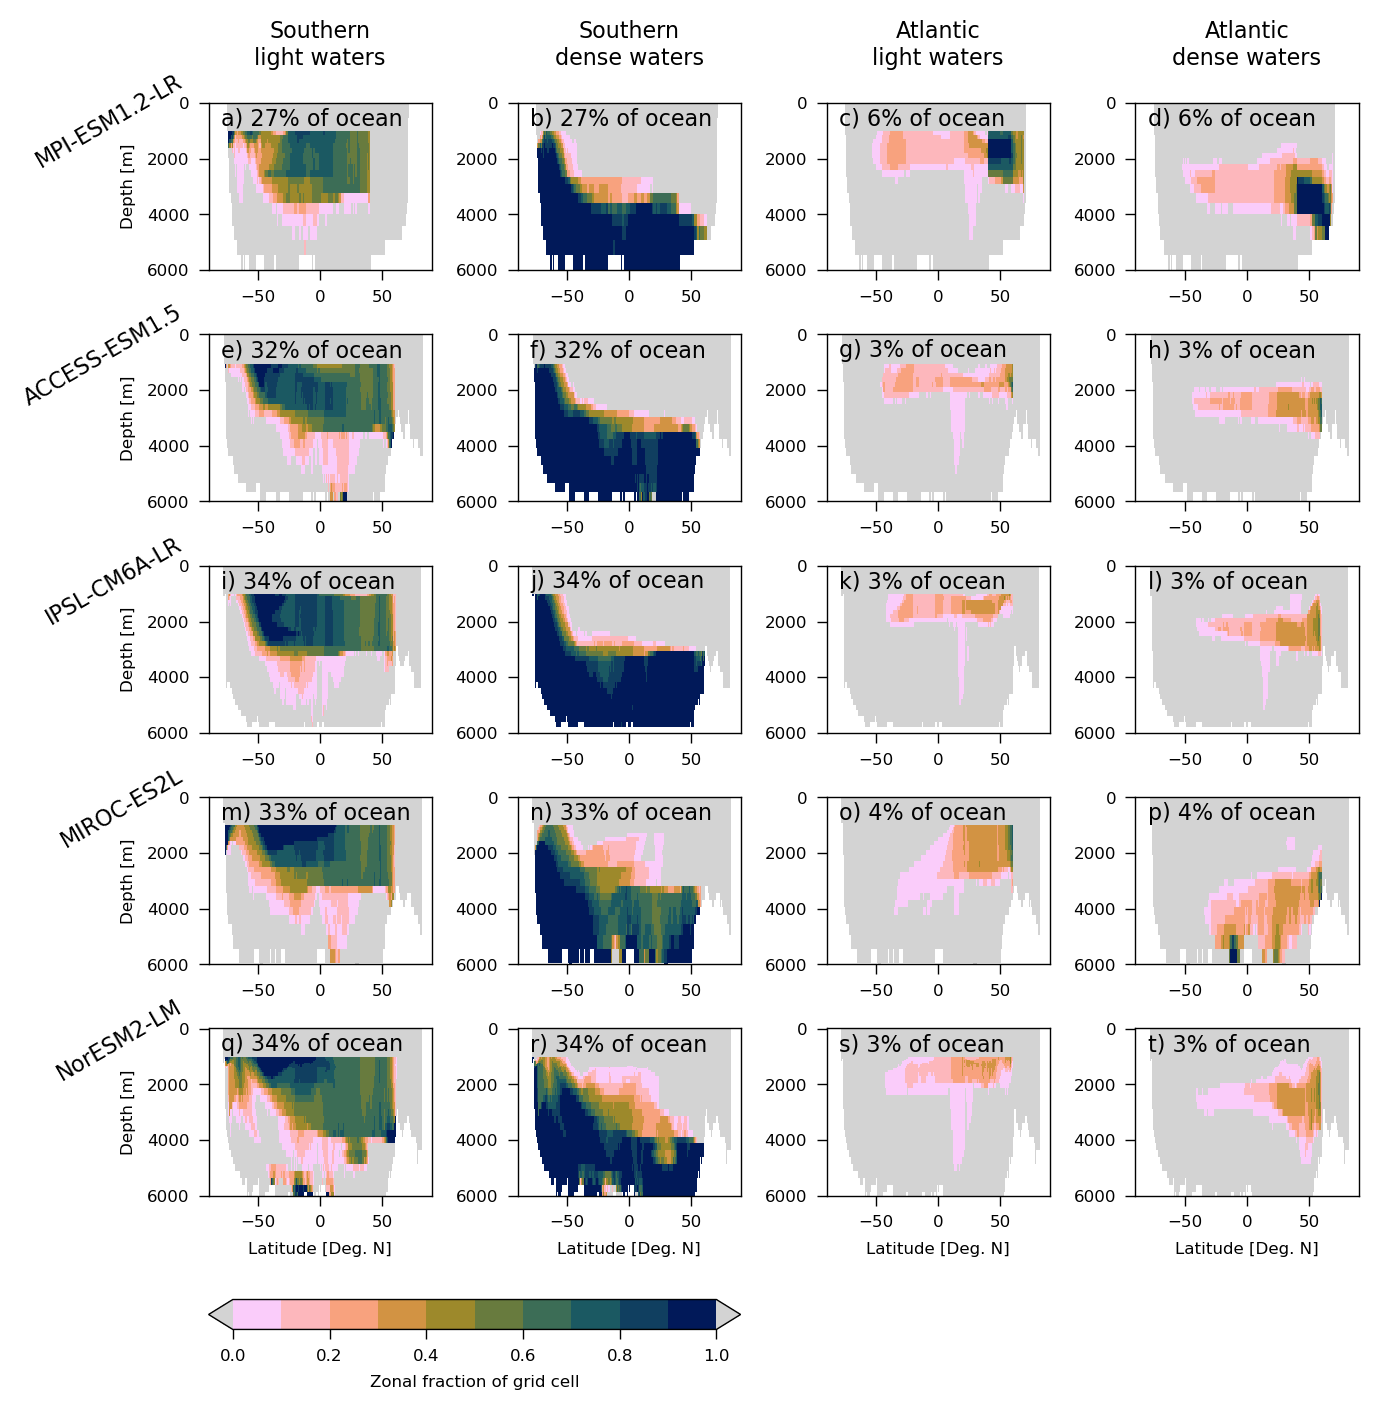

In [38]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Scatter plot ∆AOU vs ∆age and linear regression')
print('## Plot water-masses mask')

#____________________
# Load data2plot

# simu = 'historical'
# tperiod = '1986-2009'
simu = 'ssp585'
tperiod = '2015-2099'
# savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'.pckl'
savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'_include_low_significant_trend.pckl'
# Open the pickle file in binary read mode
with open(savefile, 'rb') as file:
    # Load the dictionary from the pickle file
    data2plot = pickle.load(file)
#

figname = savefile.replace('data2plot', 'section_water_mass_distribution_zonal_average').replace('.pckl', '.png')

#--------------------
# Figure parameters
#--------------------

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
region_list = ['southern light', 'southern dense', 'atlantic light', 'atlantic dense']

#______________
# Figure size
nrow, ncol = len(esm_list), len(region_list)
fwidth_cm, fheight_cm = 4*ncol, 3*nrow
fsize = (fwidth_cm*cm2in, fheight_cm*cm2in) # width, height

#______________
# cmap
a = cmcrameri.cm.batlow_r
colors = a(np.linspace(0,1,10))
newcmap = ListedColormap(colors[:])
newcmap.set_over('lightgrey')
newcmap.set_under('lightgrey')
newcmap.set_bad("none")

#______________
# pcm keywords
kwpcm = dict(cmap=newcmap, vmin=0, vmax=1)

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

region_label_dict = {
    'total': 'Total ocean', 
    'deep' : 'Deep ocean', 
    'deep significant' : 'Deep ocean\nsignificant', 
    'southern'  : 'Southern waters',  
    'southern dense': 'Southern\ndense waters', 
    'southern light': 'Southern\nlight waters', 
    'atlantic': 'Atlantic waters',
    'atlantic dense': 'Atlantic\ndense waters', 
    'atlantic light': 'Atlantic\nlight waters', 
    'southern and atlantic': 'Southern and\nAtlantic waters',
    'reminder deep and significant': 'Rest of deep\nocean significant', 
    'deep and non significant': 'Deep ocean\nnon-significant', 
    'surface': 'Upper ocean'
}

#______________
# Create figure and axes
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, squeeze=False)


#--------------------
# Plot
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    for iregion, vregion in enumerate(region_list): 

        zax = ax[iesm, iregion]
        xxx = data2plot[vesm][vregion]['water mass distribution']['zonal average']['xxx']
        yyy = data2plot[vesm][vregion]['water mass distribution']['zonal average']['yyy']
        ccc = data2plot[vesm][vregion]['water mass distribution']['zonal average']['ccc']
        ccc = np.where(ccc>1, 1, ccc) # small fix for some values that are above 1
        ccc = np.where(ccc==0, -1, ccc) # small fix for having values equal to zero set negative for visualisation
        zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm)
        pcm[iesm, iregion] = zwpcm
        zax.set_ylim((6000, -10))
        zax.set_xlim((-90, 90))

        ocean_frac = data2plot[vesm][vregion]['volume']/data2plot[vesm]['total']['volume']*100
        ttl = extended_alphabet_reverse.pop() + f') {ocean_frac:.0f}% of ocean'
        zax.text(-80, 800, ttl)
        # zax.set_title(ttl, loc='left')
    
    #
#

fig.tight_layout()

#--------------------
# Decorate
#--------------------

for iesm, vesm in enumerate(esm_list) : 
    zax = ax[iesm, 0]
    zax.text(-.1, 1.2, esm_name_dict[vesm], transform=zax.transAxes, ha='right', va='top', rotation=30.)
#
for iregion, vregion in enumerate(region_list) : 
    zax = ax[0, iregion]
    zax.text(.5, 1.2, region_label_dict[vregion], transform=zax.transAxes, ha='center', va='bottom')
#
        
for zax in ax[:, 0]: zax.set_ylabel('Depth [m]')
for zax in ax[-1, :]: zax.set_xlabel('Latitude [Deg. N]')

#---------------------
# Colorbar
#---------------------

zw1 = ax[-1, 0].get_position()
zw2 = ax[-1, 1].get_position()
nx0 = zw1.x0
ny0 = zw1.y0 - .8*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.06*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='both')
cbar.set_label(r'Zonal fraction of grid cell')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)



# Constraint plot

## linreg(∆AOU vs ∆age) in SSP585 vs linreg(∆AOU vs ∆age) in historical

In [ ]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Constrain plot')
print('## linreg(∆AOU vs ∆age) in SSP585 vs linreg(∆AOU vs ∆age) in historical')

#____________________
# figname
figname = dirout + f'constraint_plot_linreg∆AOUvs∆age_in_SSP585_vs_linreg∆AOUvs∆age_in_historical.png'

#--------------------
# Load data2plot
#--------------------
data2plot = {}

simu, tperiod = 'historical', '1986-2009'
savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'.pckl'
with open(savefile, 'rb') as file:
    data2plot['XXX'] = pickle.load(file)
#
# data2plot['XXX']['title'] = r'Sensitivity of trends in AOU to trends in age [mmol.m$^{-3}$.yr$^{-1}$]'+f'\n{tperiod}, historical simulation'
data2plot['XXX']['title'] = r'$S_{\mathrm{\Delta age}}^{\mathrm{\Delta AOU}}$'+\
    f' on years {tperiod}\n[mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]'
simu, tperiod = 'ssp585', '2015-2099'
savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'.pckl'
with open(savefile, 'rb') as file:
    data2plot['YYY'] = pickle.load(file)
#
# data2plot['YYY']['title'] = r'Sensitivity of trends in AOU to trends in age [mmol.m$^{-3}$.yr$^{-1}$]'+f'\n{tperiod}, SSP5-8.5 simulation'
data2plot['YYY']['title'] = r'$S_{\mathrm{\Delta age}}^{\mathrm{\Delta AOU}}$'+\
    f' on years {tperiod}\n[mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]'
# suptitle = r'OUR [mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]'

#--------------------
# Figure param
#--------------------

#____________________
# list
esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L']
region_list = ['southern light', 'atlantic light', 'southern dense', 'atlantic dense']

#____________________
# Create figure
fwidth_cm, fheight_cm = 12, 12
nrow, ncol = 2, 2
fsize = (fwidth_cm*cm2in, fheight_cm*cm2in) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, squeeze=False)

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

region_label_dict = {
    'southern dense': 'Southern dense waters', 
    'southern light': 'Southern light waters', 
    'atlantic dense': 'Atlantic dense waters', 
    'atlantic light': 'Atlantic light waters', 
}

#--------------------
# Plot
#--------------------

for iregion, vregion in enumerate(region_list): 

    print(f'\n----- {vregion} -----\n')
    zax = ax.flat[iregion]
    xxx_save, yyy_save = [], []
    if iregion==0: model_handles = []
    
    for iesm, vesm in enumerate(esm_list): 
        
        tvalue =          data2plot['XXX'][vesm][vregion]['linregress']['tvalue']
        xxx    =          data2plot['XXX'][vesm][vregion]['linregress']['slope']
        xerr   = tvalue * data2plot['XXX'][vesm][vregion]['linregress']['stderr']
        xrval  =          data2plot['XXX'][vesm][vregion]['linregress']['rvalue']
        tvalue =          data2plot['YYY'][vesm][vregion]['linregress']['tvalue']
        yyy    =          data2plot['YYY'][vesm][vregion]['linregress']['slope']
        yerr   = tvalue * data2plot['YYY'][vesm][vregion]['linregress']['stderr']
        yrval  =          data2plot['YYY'][vesm][vregion]['linregress']['rvalue']
        zax.errorbar(xxx, yyy, xerr=xerr, yerr=yerr, fmt='o', markersize=4, color=esm_color_dict[vesm])
        if xrval**2 < 0.7: zax.errorbar(xxx, yyy, xerr=xerr, yerr=yerr, fmt='_', markersize=8, color='r')        
        if yrval**2 < 0.7: zax.errorbar(xxx, yyy, xerr=xerr, yerr=yerr, fmt='|', markersize=8, color='r')        
        xxx_save.append(xxx)
        yyy_save.append(yyy)
        if iregion==0: model_handles.append(plt.Line2D([0], [0], marker='o', markersize=4,
                                                       color=esm_color_dict[vesm], linestyle='None', label=esm_name_dict[vesm]))
        print(f'{vesm}: {xxx:.3f}')
        
    #
    
    #______________
    # Add regression line

    # Combine `xxx` and `yyy` and sort based on `xxx`
    xxx_yyy = sorted(zip(xxx_save, yyy_save))
    # Unzip the sorted pairs
    sorted_xxx, sorted_yyy = zip(*xxx_yyy)
    xxx_save = np.array(sorted_xxx)
    yyy_save = np.array(sorted_yyy)
    
    results = stats.linregress(xxx_save, yyy_save)
    # results.slope
    # results.intercept
    # results.rvalue
    # results.pvalue
    # results.stderr
    # results.intercept_stderr

    predicted = results.intercept + results.slope * xxx_save
    n = len(xxx_save)  # Number of observations
    t_value = stats.t.ppf(1 - 0.025, n - 2)  # t-value for 95% confidence interval with n-2 degrees of freedom

    # Standard error of the predicted y-values (y_hat)
    s_err = np.sqrt(np.sum((yyy_save - predicted) ** 2) / (n - 2))
    conf_interval = t_value * s_err * np.sqrt(1 / n + (xxx_save - np.mean(xxx_save))**2 / np.sum((xxx_save - np.mean(xxx_save))**2))
    lower_band = predicted - conf_interval
    upper_band = predicted + conf_interval

    zax.fill_between(xxx_save, lower_band, upper_band, color='k', alpha=0.2, lw=0)
    zax.plot(xxx_save, predicted, color='k', lw=.5)
    # R2 = f'$R^2={np.floor(results.rvalue**2*100)/100:.2f}'
    R2 = rf'$R^2$={np.round(results.rvalue**2, decimals=2)}'
    pvalue = rf'p-value={np.round(results.pvalue, decimals=2):.2f}' if results.pvalue >= .01 else rf'p-value<0.01'
    zwtxt = R2+'\n'+pvalue
    #zwtxt = f"$R^2={R2}$\np-value: {results.pvalue:.2f}"
    zax.text(.05, .95, zwtxt, transform=zax.transAxes, ha='left', va='top', size=6, \
             bbox=dict(facecolor='white', edgecolor='black', linewidth=0.5, boxstyle='square,pad=0.5'))

    #______________
    # Decorate

    # zax.set_xlabel(f'{data2plot["XXX"]["title"]}')
    # zax.set_ylabel(f'{data2plot["YYY"]["title"]}')
    # zax.set_xlabel(f'Sensitivity of ∆AOU to ∆age\n{data2plot["XXX"]["tperiod"]}')
    # zax.set_ylabel(f'Sensitivity of ∆AOU to ∆age\n{data2plot["YYY"]["tperiod"]}')
    grid_color = '#b0b0b0'
    grid_linestyle = '--'
    grid_linewidth = .5
    zax.grid(True, which='major', axis='both', color=grid_color, linestyle=grid_linestyle, linewidth=grid_linewidth)
    ttl = alphabet_reverse.pop()+') '+region_label_dict[vregion]
    zax.set_title(ttl, loc='left')
    
    # Make same x and y range
    xlim0 = zax.get_xlim()
    ylim0 = zax.get_ylim()
    xylim = (np.min([xlim0, ylim0]), np.max([xlim0, ylim0]))
    zax.set_xlim(xylim)
    zax.set_ylim(xylim)
    
    # 1:1 line
    xxx = np.linspace(zax.get_xlim()[0], zax.get_xlim()[1], 10)
    zax.plot(xxx, xxx, c=grid_color, ls=grid_linestyle, lw=grid_linewidth)
    
    xlim = zax.get_xlim()
    ylim = zax.get_ylim()
    zax.set_aspect(abs( (xlim[1]- xlim[0])/(ylim[1]- ylim[0]) ))

    #______________
    # Add results from observations
    if vregion in ['southern dense', 'atlantic dense']: 
        if vregion in ['southern dense']: 
            nnn=23
            tval = stats.t.ppf(1 - 0.025, nnn - 2)
            x_line, x_uncertainty = 0.04, 0.0029*tval
        elif vregion in ['atlantic dense']: 
            nnn=20
            tval = stats.t.ppf(1 - 0.025, nnn - 2)
            x_line, x_uncertainty = 0.11, 0.0073*tval
        #
        zax.fill_betweenx(ylim, x1=x_line-x_uncertainty, x2=x_line+x_uncertainty, color='tab:blue', alpha=0.2, lw=0)
        zax.axvline(x=x_line, color='tab:blue', lw=.5)
    #
    if vregion == 'southern dense': 
        zax.text(x_line, 0.025, 'Observation', ha='left', va='bottom', size=6, color='tab:blue')

#


fig.tight_layout()

#--------------------
# Decorate
#--------------------

for zax in ax[:, 0]: 
    zax.set_ylabel(f'{data2plot["YYY"]["title"]}')
#
for zax in ax[-1, :]: 
    zax.set_xlabel(f'{data2plot["XXX"]["title"]}')
#

#__________________
# Add legend
ax.flat[0].legend(handles=model_handles, handlelength=0.5, frameon=False, borderaxespad=0, borderpad=0,
                   handletextpad=.5, loc='lower right', bbox_to_anchor=(1, 0.03))

#__________________
# Suptile
# fig.suptitle(suptitle, x=0.5, y=1, ha='center', va='bottom')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)


2025-05-02 18:10:27.380811
# Constrain plot
## linreg(∆AOU vs ∆age) in SSP585 vs linreg(∆AOU vs ∆age) in historical

----- southern light -----

MPI-ESM1-2-LR: 0.079
ACCESS-ESM1-5: 0.788
IPSL-CM6A-LR: 0.275
MIROC-ES2L: 0.109
NorESM2-LM: 0.134

----- atlantic light -----

MPI-ESM1-2-LR: 0.138
ACCESS-ESM1-5: 0.242
IPSL-CM6A-LR: 0.335
MIROC-ES2L: 0.208
NorESM2-LM: 0.215

----- southern dense -----

MPI-ESM1-2-LR: 0.057
ACCESS-ESM1-5: 0.143
IPSL-CM6A-LR: 0.174
MIROC-ES2L: 0.084
NorESM2-LM: 0.129

----- atlantic dense -----

MPI-ESM1-2-LR: 0.077
ACCESS-ESM1-5: 0.183
IPSL-CM6A-LR: 0.296
MIROC-ES2L: 0.136
NorESM2-LM: 0.139
Save figure...
Figure saved: 25-03-28-figures-for-storyline-v2/constraint_plot_linreg∆AOUvs∆age_in_SSP585_vs_linreg∆AOUvs∆age_in_historical.png


# Figure ∆AOU = OUR * ∆Age + reminder

## Prepare data2plot

In [23]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Figure ∆AOU = OUR * ∆Age + reminder')
print('## Prepare data2plot')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
tperiod = '2015-2099'


#----------------
# Define some functions
#----------------
def compute_xavg(zwnp, zwvolume): 
    zwda = xr.DataArray(zwnp, dims=zwvolume.dims, coords=zwvolume.coords)
    zwda_xavg = zonal_avg(zwda, zwvolume)
    xavg_dict = {'xxx': zwda_xavg.latitude.values, 'yyy': zwda_xavg.depth.values, 'ccc': zwda_xavg.values}
    return xavg_dict
#

#----------------
# Initiate data2plot
#----------------

data2plot = {
    'ESM': [], \
    'Global': {
        '∆AOU': {'total':[], 'deep':[], 'deep significant':[], \
                 'southern and atlantic significant': [], \
                 'southern and atlantic': []}, \
        '∆Age': {'southern and atlantic significant': [], \
                 'southern and atlantic': []}, \
        'reminder': {'southern and atlantic significant': [], \
                     'southern and atlantic': []}, \
        'R2': {'southern and atlantic significant': [], \
               'southern and atlantic': []}, \
        'volume': {'total':[], 'deep':[], 'deep significant':[], \
                   'southern and atlantic significant': [], \
                   'southern and atlantic': []}
    }, \
    'xavg': {
        '∆AOU': {'total':[], 'deep':[], 'deep significant':[], \
                 'southern and atlantic significant': [], \
                 'southern and atlantic': []}, \
        '∆Age': {'southern and atlantic significant': [], \
                 'southern and atlantic': []}, \
        'reminder': {'southern and atlantic significant': [], \
                     'southern and atlantic': []}        
    }
}

#----------------
# Loop on ESM
#----------------


for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')

    data2plot['ESM'].append(vesm)
    
    #----------------
    # Load data
    #----------------
    print('   Load data...')

    if tperiod=='2015-2099': simu = 'ssp585'
    elif tperiod=='1986-2009': simu = 'historical'

    savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'.pckl'
    with open(savefile, 'rb') as file:
        data2process_significant = pickle.load(file)
    #
    savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'_include_low_significant_trend.pckl'
    with open(savefile, 'rb') as file:
        data2process_with_low_significant = pickle.load(file)
    #

    #----------------
    # Compute volume and omask
    #----------------
    print('   Compute volume and omask...')
    if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
    else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                  version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwds2 = zwds['areacello'].to_dataset()
    zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
    zwds2 = split_coords_dimensions(zwds2)
    zwds2 = shift_180_lon(zwds2)
    zarea = zwds2['areacello']
    # FOR MPI model, invert latitude dimension
    if vesm == 'MPI-ESM1-2-LR' : 
        zarea = zarea.isel(j=slice(None, None, -1))
    #

    fname = netcdfdir+f'{vesm}_historical_sigma0_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_sigma0 = zwds['sigma0']
    if vesm == 'MPI-ESM1-2-LR' : 
        zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
    #

    depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)

    omask = ~(zwda_sigma0.isnull()).rename('mask').drop(['latitude', 'longitude'])
    volume = omask * depthickness * zarea

    del depbounds, depthickness
    
    #----------------
    # Southern and atlantic significant
    #----------------
    print('   Southern and atlantic significant...')

    zw_delta_aou_SA, zw_delta_age_SA, zw_reminder_SA = 0, 0, 0
    zwvolume_SA, zwr2_SA = 0, 0
    zw_delta_aou_3D_SA, zw_delta_age_3D_SA, zw_reminder_3D_SA = [], [], []
    for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 

        #______________
        # Global
        zwaou    = data2process_significant[vesm][watermass]['integrated aou trend']
        zwage    = data2process_significant[vesm][watermass]['integrated age trend']
        zwour    = data2process_significant[vesm][watermass]['linregress']['slope']
        zwr2     = data2process_significant[vesm][watermass]['linregress']['rvalue']**2
        zwvolume = data2process_significant[vesm][watermass]['volume']

        zw_delta_age = zwour * zwage
        zw_reminder = zwaou - zw_delta_age

        zw_delta_aou_SA += zwaou
        zw_delta_age_SA += zw_delta_age
        zw_reminder_SA  += zw_reminder

        zwr2_SA     += zwr2 * zwvolume
        zwvolume_SA += zwvolume
        
        #______________
        # XAVG
        zw_pred_3D = data2process_significant[vesm][watermass]['aou prediction']['predicted']['3D']['ccc']
        zw_bias_3D = data2process_significant[vesm][watermass]['aou prediction']['error']['3D']['ccc']
        zw_itcpt   = data2process_significant[vesm][watermass]['linregress']['intercept']

        zw_delta_aou_3D = zw_pred_3D + zw_bias_3D
        zw_delta_age_3D = zw_pred_3D - zw_itcpt
        zw_reminder_3D  = zw_bias_3D + zw_itcpt
        
        zw_delta_aou_3D_SA.append(zw_delta_aou_3D)
        zw_delta_age_3D_SA.append(zw_delta_age_3D)
        zw_reminder_3D_SA .append(zw_reminder_3D )


    #
    zwr2_SA = zwr2_SA / zwvolume_SA

    zw_delta_aou_3D_SA = np.array(zw_delta_aou_3D_SA)
    zw_delta_age_3D_SA = np.array(zw_delta_age_3D_SA)
    zw_reminder_3D_SA  = np.array(zw_reminder_3D_SA )

    all_nan_mask = np.all(np.isnan(zw_delta_aou_3D_SA), axis=0)
    zwnansum = np.nansum(zw_delta_aou_3D_SA, axis=0)
    zw_delta_aou_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

    all_nan_mask = np.all(np.isnan(zw_delta_age_3D_SA), axis=0)
    zwnansum = np.nansum(zw_delta_age_3D_SA, axis=0)
    zw_delta_age_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

    all_nan_mask = np.all(np.isnan(zw_reminder_3D_SA), axis=0)
    zwnansum = np.nansum(zw_reminder_3D_SA, axis=0)
    zw_reminder_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)
        
    watermass = 'southern and atlantic significant'
    #______________
    # Global
    datatype = 'Global'
    data2plot[datatype]['∆AOU'     ][watermass].append(zw_delta_aou_SA)
    data2plot[datatype]['∆Age'     ][watermass].append(zw_delta_age_SA)
    data2plot[datatype]['reminder' ][watermass].append(zw_reminder_SA)
    data2plot[datatype]['R2'       ][watermass].append(zwr2_SA)
    data2plot[datatype]['volume'   ][watermass].append(zwvolume_SA)
    #______________
    # XAVG
    datatype = 'xavg'
    xavg = compute_xavg(zw_delta_aou_3D_SA, volume)
    data2plot[datatype]['∆AOU'][watermass].append(xavg)
    xavg = compute_xavg(zw_delta_age_3D_SA, volume)
    data2plot[datatype]['∆Age'][watermass].append(xavg)
    xavg = compute_xavg(zw_reminder_3D_SA, volume)
    data2plot[datatype]['reminder'][watermass].append(xavg)

    #----------------
    # Southern and atlantic including low significant water-masses
    #----------------
    print('   Southern and atlantic including low significant water-masses...')
    
    zw_delta_aou_SA, zw_delta_age_SA, zw_reminder_SA = 0, 0, 0
    zwvolume_SA, zwr2_SA = 0, 0
    zw_delta_aou_3D_SA, zw_delta_age_3D_SA, zw_reminder_3D_SA = [], [], []
    for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 

        #______________
        # Global
        zwaou    = data2process_with_low_significant[vesm][watermass]['integrated aou trend']
        zwage    = data2process_with_low_significant[vesm][watermass]['integrated age trend']
        zwour    = data2process_with_low_significant[vesm][watermass]['linregress']['slope']
        zwr2     = data2process_with_low_significant[vesm][watermass]['linregress']['rvalue']**2
        zwvolume = data2process_with_low_significant[vesm][watermass]['volume']

        zw_delta_age = zwour * zwage
        zw_reminder = zwaou - zw_delta_age

        zw_delta_aou_SA += zwaou
        zw_delta_age_SA += zw_delta_age
        zw_reminder_SA  += zw_reminder

        zwr2_SA     += zwr2 * zwvolume
        zwvolume_SA += zwvolume
        
        #______________
        # XAVG
        zw_pred_3D = data2process_with_low_significant[vesm][watermass]['aou prediction']['predicted']['3D']['ccc']
        zw_bias_3D = data2process_with_low_significant[vesm][watermass]['aou prediction']['error']['3D']['ccc']
        zw_itcpt   = data2process_with_low_significant[vesm][watermass]['linregress']['intercept']

        zw_delta_aou_3D = zw_pred_3D + zw_bias_3D
        zw_delta_age_3D = zw_pred_3D - zw_itcpt
        zw_reminder_3D  = zw_bias_3D + zw_itcpt
        
        zw_delta_aou_3D_SA.append(zw_delta_aou_3D)
        zw_delta_age_3D_SA.append(zw_delta_age_3D)
        zw_reminder_3D_SA .append(zw_reminder_3D )


    #
    zwr2_SA = zwr2_SA / zwvolume_SA

    zw_delta_aou_3D_SA = np.array(zw_delta_aou_3D_SA)
    zw_delta_age_3D_SA = np.array(zw_delta_age_3D_SA)
    zw_reminder_3D_SA  = np.array(zw_reminder_3D_SA )

    all_nan_mask = np.all(np.isnan(zw_delta_aou_3D_SA), axis=0)
    zwnansum = np.nansum(zw_delta_aou_3D_SA, axis=0)
    zw_delta_aou_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

    all_nan_mask = np.all(np.isnan(zw_delta_age_3D_SA), axis=0)
    zwnansum = np.nansum(zw_delta_age_3D_SA, axis=0)
    zw_delta_age_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

    all_nan_mask = np.all(np.isnan(zw_reminder_3D_SA), axis=0)
    zwnansum = np.nansum(zw_reminder_3D_SA, axis=0)
    zw_reminder_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)
        
    watermass = 'southern and atlantic'
    #______________
    # Global
    datatype = 'Global'
    data2plot[datatype]['∆AOU'     ][watermass].append(zw_delta_aou_SA)
    data2plot[datatype]['∆Age'     ][watermass].append(zw_delta_age_SA)
    data2plot[datatype]['reminder' ][watermass].append(zw_reminder_SA)
    data2plot[datatype]['R2'       ][watermass].append(zwr2_SA)
    data2plot[datatype]['volume'   ][watermass].append(zwvolume_SA)
    #______________
    # XAVG
    datatype = 'xavg'
    xavg = compute_xavg(zw_delta_aou_3D_SA, volume)
    data2plot[datatype]['∆AOU'][watermass].append(xavg)
    xavg = compute_xavg(zw_delta_age_3D_SA, volume)
    data2plot[datatype]['∆Age'][watermass].append(xavg)
    xavg = compute_xavg(zw_reminder_3D_SA, volume)
    data2plot[datatype]['reminder'][watermass].append(xavg)
       
    #----------------
    # Total, deep and deep significant (only ∆AOU and volume)...
    #----------------
    print('   Total, deep and deep significant (only ∆AOU and volume)...')
    
    datatype = 'Global'
    
    # total
    watermass = 'total'
    zw_delta_aou = data2process_significant[vesm][watermass]['integrated aou trend']
    data2plot[datatype]['∆AOU'     ][watermass].append(zw_delta_aou)
    zwvolume     = data2process_significant[vesm][watermass]['volume']
    data2plot[datatype]['volume'     ][watermass].append(zwvolume)
    
    # deep significant
    watermass = 'deep'
    zw_delta_aou = data2process_significant[vesm][watermass]['integrated aou trend']
    data2plot[datatype]['∆AOU'     ][watermass+' significant'].append(zw_delta_aou)
    zwvolume     = data2process_significant[vesm][watermass]['volume']
    data2plot[datatype]['volume'     ][watermass+' significant'].append(zwvolume)
    
    # deep including low significance
    watermass = 'deep'
    zw_delta_aou = data2process_with_low_significant[vesm][watermass]['integrated aou trend']
    data2plot[datatype]['∆AOU'     ][watermass].append(zw_delta_aou)
    zwvolume     = data2process_significant[vesm][watermass]['volume']
    data2plot[datatype]['volume'     ][watermass].append(zwvolume)

    #
#

#----------------
# Save data2plot in pickle
#----------------

savefile = dirout + 'data2plot_AOUtrend_OURxAgetrend_reminder.pckl'
with open(savefile, "wb") as file:
    pickle.dump(data2plot, file)
#



2025-05-02 13:44:12.360998
# Figure ∆AOU = OUR * ∆Age + reminder
## Prepare data2plot
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
   Load data...
   Compute volume and omask...
   Southern and atlantic significant...
   Southern and atlantic including low significant water-masses...
   Total, deep and deep significant (only ∆AOU and volume)...
-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
   Load data...
   Compute volume and omask...
   Southern and atlantic significant...
   Southern and atlantic including low significant water-masses...
   Total, deep and deep significant (only ∆AOU and volume)...
-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
   Load data...
   Compute volume and omask...
   Southern and atlantic significant...
   Southern and atlantic including low significant water-masses...
   Total, deep and deep significant (only ∆AOU and volume)...
---------------------

## Plot

2025-05-02 18:21:32.240706
# Compute ∆AOU = OUR * ∆Age + intercept + residual
## Plot


<string>:115: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


---- dAGE/dAOU ----
MPI-ESM1-2-LR: 57%
ACCESS-ESM1-5: 38%
IPSL-CM6A-LR: 95%
MIROC-ES2L: 78%
NorESM2-LM: 81%
-----------------
---- dAGE, dAOU ----
MPI-ESM1-2-LR: 0.16, 0.28 [PgC/yr]
ACCESS-ESM1-5: 0.13, 0.35 [PgC/yr]
IPSL-CM6A-LR: 0.31, 0.33 [PgC/yr]
MIROC-ES2L: 0.49, 0.63 [PgC/yr]
NorESM2-LM: 0.33, 0.41 [PgC/yr]
-----------------
Save figure...
Figure saved: 25-03-28-figures-for-storyline-v2/plot_AOUtrend_OURxAgetrend_reminder.png
peak memory: 479.22 MiB, increment: 259.34 MiB
CPU times: user 2.56 s, sys: 937 ms, total: 3.49 s
Wall time: 2.45 s


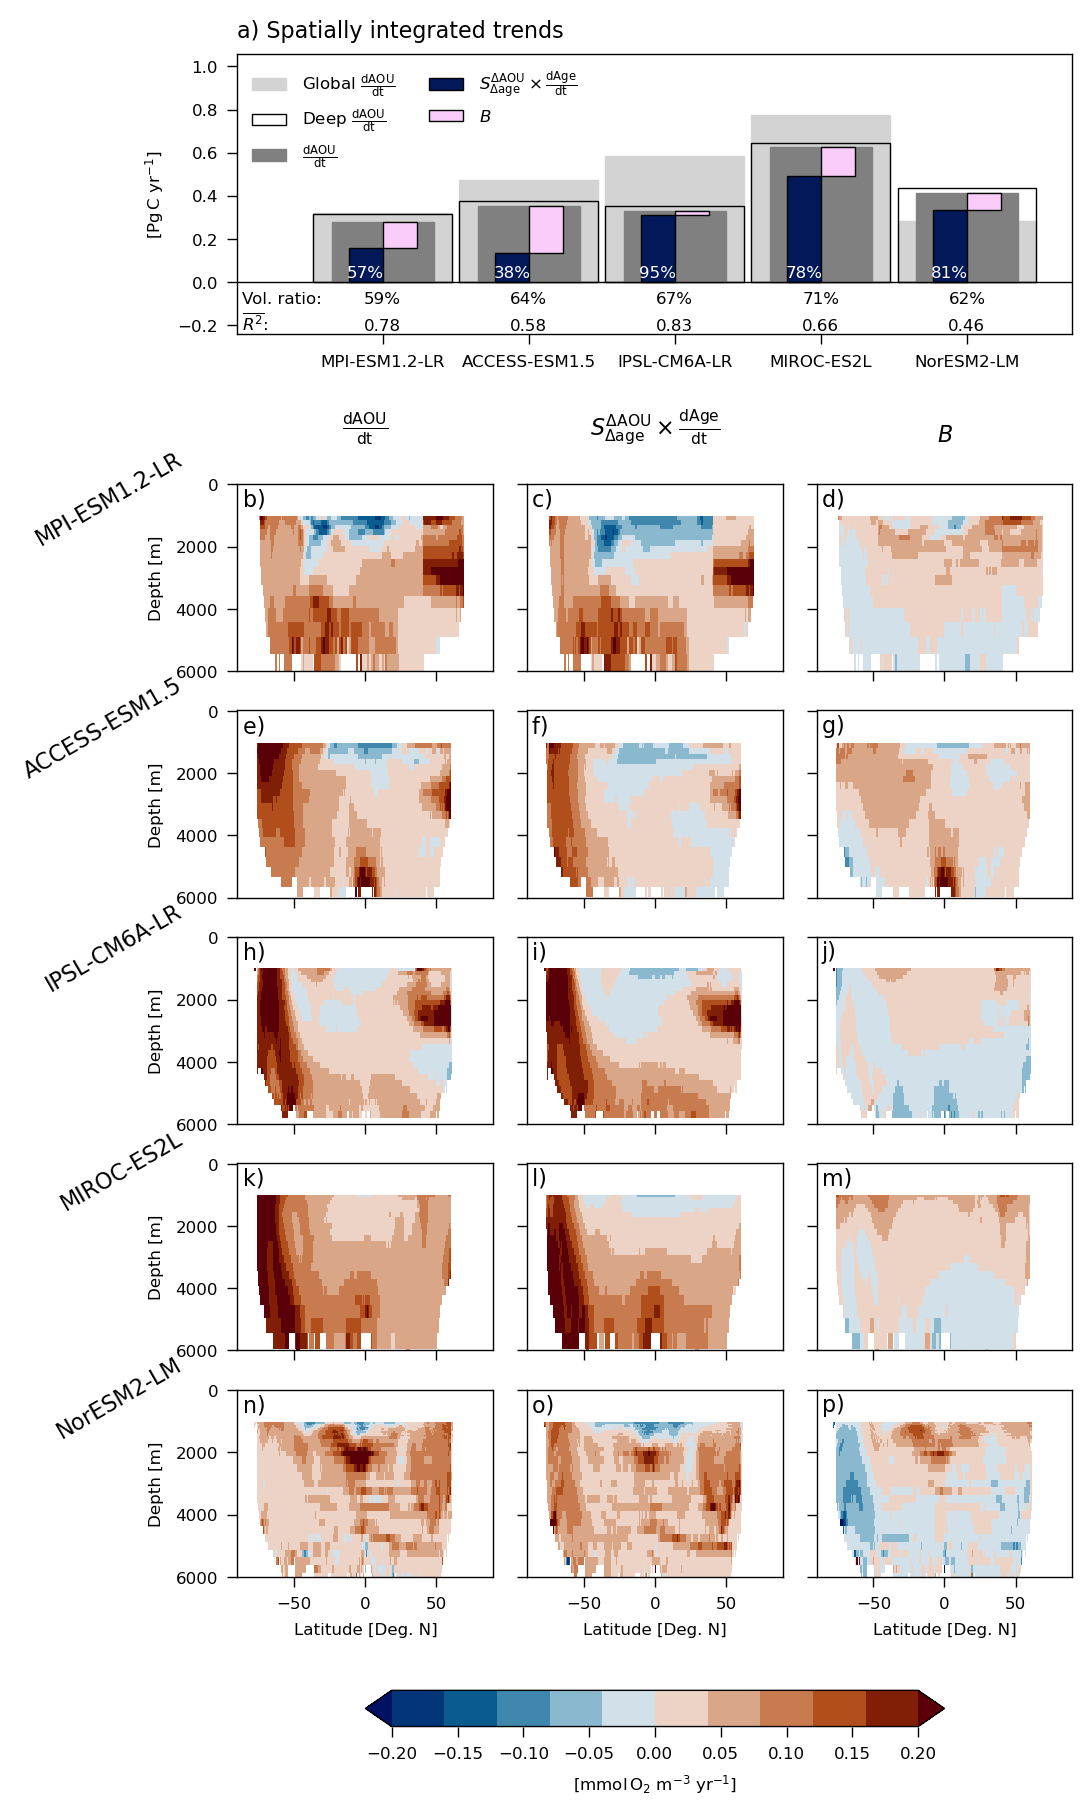

In [9]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute ∆AOU = OUR * ∆Age + intercept + residual')
print('## Plot')

#____________________
# Load data2plot

savefile = dirout + 'data2plot_AOUtrend_OURxAgetrend_reminder.pckl'
with open(savefile, 'rb') as file:
    data2plot = pickle.load(file)

#
watermass='southern and atlantic significant'

#____________________
# Set figname for saving figure

figname = dirout + 'plot_AOUtrend_OURxAgetrend_reminder.png'

#--------------------
# Figure parameters
#--------------------

# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
esm_list = data2plot['ESM']
section_list = ['∆AOU', '∆Age', 'reminder']

zfact_glob = 1e-18 * 117/170 * 12.01 # mmol-O -> PgC
zfact_section = 1

#______________
# Labels
labels_dict = {
    'Global ∆AOU': r'Global $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep ∆AOU': r'Deep $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep significant ∆AOU': r'Deep significant $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆AOU'       : r'$\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆Age'       : r'$S_{\mathrm{\Delta age}}^{\mathrm{\Delta AOU}} \times \frac{\mathrm{dAge}}{\mathrm{dt}}$',
    # 'reminder'   : r'$\mathrm{Age} \times \frac{\mathrm{dOUR}}{\mathrm{dt}}$',
    'reminder'  : r'$B$'
}

#______________
# barplot colors
barplot_color_dict = {
    'Global ∆AOU': 'lightgrey',
    '∆AOU': 'grey',
    '∆Age' : cmcrameri.cm.batlowS.colors[0],
    'reminder' : cmcrameri.cm.batlowS.colors[1]
}

#______________
# barplot kwargs
kwbar = dict(linewidth=0.5, align='center')
kwbar1 = dict(linewidth=.5, align='center', edgecolor='k')

#______________
# Sections axis labeling and limits
xlabel = 'Latitude [Deg. N]'
ylabel = 'Depth [m]'
xlim = (-90, 90)
ylim = (6000, -10)

#______________
# Section cmap
a = cmcrameri.cm.vik
colors = a(np.linspace(0,1,10+2))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[0])
newcmap.set_bad("none")

#______________
# Section pcm kwargs
kwpcm = dict(cmap=newcmap, vmin=-.2, vmax=.2)

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

# Pop one now to save a) for the barplot at the top
extended_alphabet_reverse.pop()

#______________
# Set figure
ncol = 3
nrow = len(esm_list)
fwidth_cm = 4
fheight_cm = 3
fsize = (fwidth_cm*cm2in*ncol, fheight_cm*cm2in*nrow) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, sharex='col', sharey='row')

#--------------------
# Plot sections
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    
    for iii, vvv in enumerate(section_list): 

        zwdata = data2plot['xavg'][vvv][watermass][iesm]

        zax = ax[iesm, iii]
        xxx = zwdata['xxx']
        yyy = zwdata['yyy']
        ccc = zwdata['ccc'] * zfact_section
        # ccc = np.where(ccc!=0, ccc, np.nan)
        zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm)
        pcm[iesm, iii] = zwpcm
        zax.set_ylim(ylim)
        zax.set_xlim(xlim)

        zwtxt = extended_alphabet_reverse.pop() + f') '
        zax.text(.02, .98, zwtxt, transform=zax.transAxes, ha='left', va='top')
    #
    
    
#

#--------------------
# Decorate sections
#--------------------

fig.tight_layout()

for iesm, vesm in enumerate(esm_list) : 
    zax = ax[iesm, 0]
    zax.text(-.2, 1.2, esm_name_dict[vesm], transform=zax.transAxes, ha='right', va='top', rotation=30.)
#

for zax in ax[:, 0]: zax.set_ylabel(ylabel)
for zax in ax[-1, :]: zax.set_xlabel(xlabel)
        
for iii, vvv in enumerate(section_list): 
    zax = ax[0, iii]
    zax.text(.5, 1.2, labels_dict[vvv], transform=zax.transAxes, ha='center', va='bottom')
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[-1, 0].get_position()
zw2 = ax[-1, -1].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw2.y0 - .8*zw1.height
nw  = zw2.x0 + .5*zw2.width - nx0
nh  = 0.05*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='both')
clabel = '[mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]'
cbar.set_label(clabel)

#--------------------
# Add barplot
#--------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .8*zw1.height
nw  = zw2.x1 - nx0
nh  = 1.5*zw1.height
zax = fig.add_axes([nx0, ny0, nw, nh])

#_________________
# Get x-ticks and xxx and www0 and www1
xxx = np.arange(len(esm_list))

www0 =  0.95
www1 =  0.7

#_________________
# ∆AOU

var = '∆AOU'

hhh = np.array(data2plot['Global'][var]['total']) * zfact_glob
zax.bar(xxx, hhh, width=www0, label='Global ∆AOU', color=barplot_color_dict['Global '+var], edgecolor=barplot_color_dict['Global '+var], **kwbar)

hhh = np.array(data2plot['Global'][var]['deep']) * zfact_glob
zax.bar(xxx, hhh, width=www0, label='Deep ∆AOU', color='none', edgecolor='k',  **kwbar)

# hhh = np.array(data2plot['Global'][var]['deep significant']) * zfact_glob
# zax.bar(xxx, hhh, width=www0, color='none', label='Deep significant ∆AOU', linewidth=.5, ls='--', edgecolor='red', align='center')

hhh = np.array(data2plot['Global'][var][watermass]) * zfact_glob
zax.bar(xxx, hhh, width=www1, label=var, color=barplot_color_dict[var], edgecolor=barplot_color_dict[var], **kwbar)

nnn = 2
www2=www1/(nnn+1)

#_________________
# ∆Age
iii = 0
var = '∆Age'
hhh = np.array(data2plot['Global'][var][watermass]) * zfact_glob
bbb = 0*hhh
xxx1 = xxx-(nnn-(1+2*iii))*www2/2
bars = zax.bar(xxx1, hhh, width=www2, color=barplot_color_dict[var], label=var, **kwbar1)

#_________________
# Reminder
iii = 1
var = 'reminder'
bbb += hhh
hhh = np.array(data2plot['Global'][var][watermass]) * zfact_glob
xxx2 = xxx-(nnn-(1+2*iii))*www2/2
zax.bar(xxx2, hhh, bottom=bbb, width=www2, color=barplot_color_dict[var], label=var, **kwbar1)


#--------------------
# Decorate barplot
#--------------------

zax.axhline(0, c='k', lw=.5)

#____________________
# Set labels and title

ttl = 'a) Spatially integrated trends'
zax.set_title(ttl, loc='left')
zax.set_ylabel(r'[Pg$\,$C yr$^{-1}$]')
x_tick_labels = [esm_name_dict[vesm] for vesm in esm_list]
zax.set_xticks(xxx)
zax.set_xticklabels(x_tick_labels)

#____________________
# Adjust axis limits

ylim = zax.get_ylim()
dylim = 0.30*(ylim[1]-ylim[0])
ylim2 = (ylim[0]-dylim, ylim[1]+dylim)
zax.set_ylim(ylim2)

xlim = zax.get_xlim()
dxlim = 0.05*(xlim[1]-xlim[0])
xlim2 = (xlim[0]-dxlim, xlim[1])
zax.set_xlim(xlim2)


#____________________
# legend
aaa=zax.get_legend_handles_labels()
handles = aaa[0]
labels = [labels_dict[vvv] for vvv in aaa[1]]
zax.legend(handles, labels, frameon=False, handletextpad=1, ncol=2,\
           loc='upper left', bbox_to_anchor=(0, 1))

#--------------------
# Add R2 text
#--------------------
ylim = zax.get_ylim()
xlim = zax.get_xlim()

iii=0
ytext = ylim[0]+0.005*(ylim[1]-ylim[0])
for ind, val in enumerate(data2plot['Global']['R2'][watermass]): 
    xtext = xxx[ind]
    zax.text( xtext, ytext, f'{val:.2f}', ha='center', va='bottom', size=6)
#
xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
zax.text(xtext, ytext, r'$\overline{R^2}$:', ha='left', va='bottom', size=6)

#--------------------
# Add volume text
#--------------------
iii=0
ytext = ylim[0]+0.1*(ylim[1]-ylim[0])
totvolume = data2plot['Global']['volume']['total']
for ind, val in enumerate(data2plot['Global']['volume'][watermass]): 
    xtext = xxx[ind]
    zax.text( xtext, ytext, f'{val/totvolume[ind]*100:.0f}%', ha='center', va='bottom', size=6)
#
xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
zax.text(xtext, ytext, r'Vol. ratio:', ha='left', va='bottom', size=6)

#--------------------
# Add share of dAge
#--------------------
iii=0
ytext = 0.005*(ylim[1]-ylim[0])
daou = data2plot['Global']['∆AOU'][watermass]
for ind, val in enumerate(data2plot['Global']['∆Age'][watermass]): 
    xtext = xxx1[ind]
    zax.text( xtext, ytext, f'{val/daou[ind]*100:.0f}%', c='white', ha='center', va='bottom', size=6)
#

#--------------------
# Print share of dAge
#--------------------
print('---- dAGE/dAOU ----')
daou = data2plot['Global']['∆AOU'][watermass]
dage = data2plot['Global']['∆Age'][watermass]
for ind, val in enumerate(data2plot['ESM']): 
    print(f'{val}: {dage[ind]/daou[ind]*100:.0f}%')
#
print('-----------------')

#--------------------
# Print dAOU, dAge
#--------------------
print('---- dAGE, dAOU ----')
daou = data2plot['Global']['∆AOU'][watermass]
dage = data2plot['Global']['∆Age'][watermass]
for ind, val in enumerate(data2plot['ESM']): 
    print(f'{val}: {dage[ind]*zfact_glob:.2f}, {daou[ind]*zfact_glob:.2f} [PgC/yr]')
#
print('-----------------')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)


## Plot contribution relative to ∆AOU

2025-05-02 18:36:43.563777
# Compute ∆AOU = OUR * ∆Age + intercept + residual
## Plot contribution relative to ∆AOU


<string>:117: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


---- dAGE/dAOU ----
MPI-ESM1-2-LR: 57%
ACCESS-ESM1-5: 38%
IPSL-CM6A-LR: 95%
MIROC-ES2L: 78%
NorESM2-LM: 81%
-----------------
---- dAGE, dAOU ----
MPI-ESM1-2-LR: 0.16, 0.28 [PgC/yr]
ACCESS-ESM1-5: 0.13, 0.35 [PgC/yr]
IPSL-CM6A-LR: 0.31, 0.33 [PgC/yr]
MIROC-ES2L: 0.49, 0.63 [PgC/yr]
NorESM2-LM: 0.33, 0.41 [PgC/yr]
-----------------
Save figure...
Figure saved: 25-03-28-figures-for-storyline-v2/plot_AOUtrend_OURxAgetrend_reminder_relative_contributions.png
peak memory: 598.75 MiB, increment: 290.08 MiB
CPU times: user 2.23 s, sys: 908 ms, total: 3.14 s
Wall time: 2.15 s


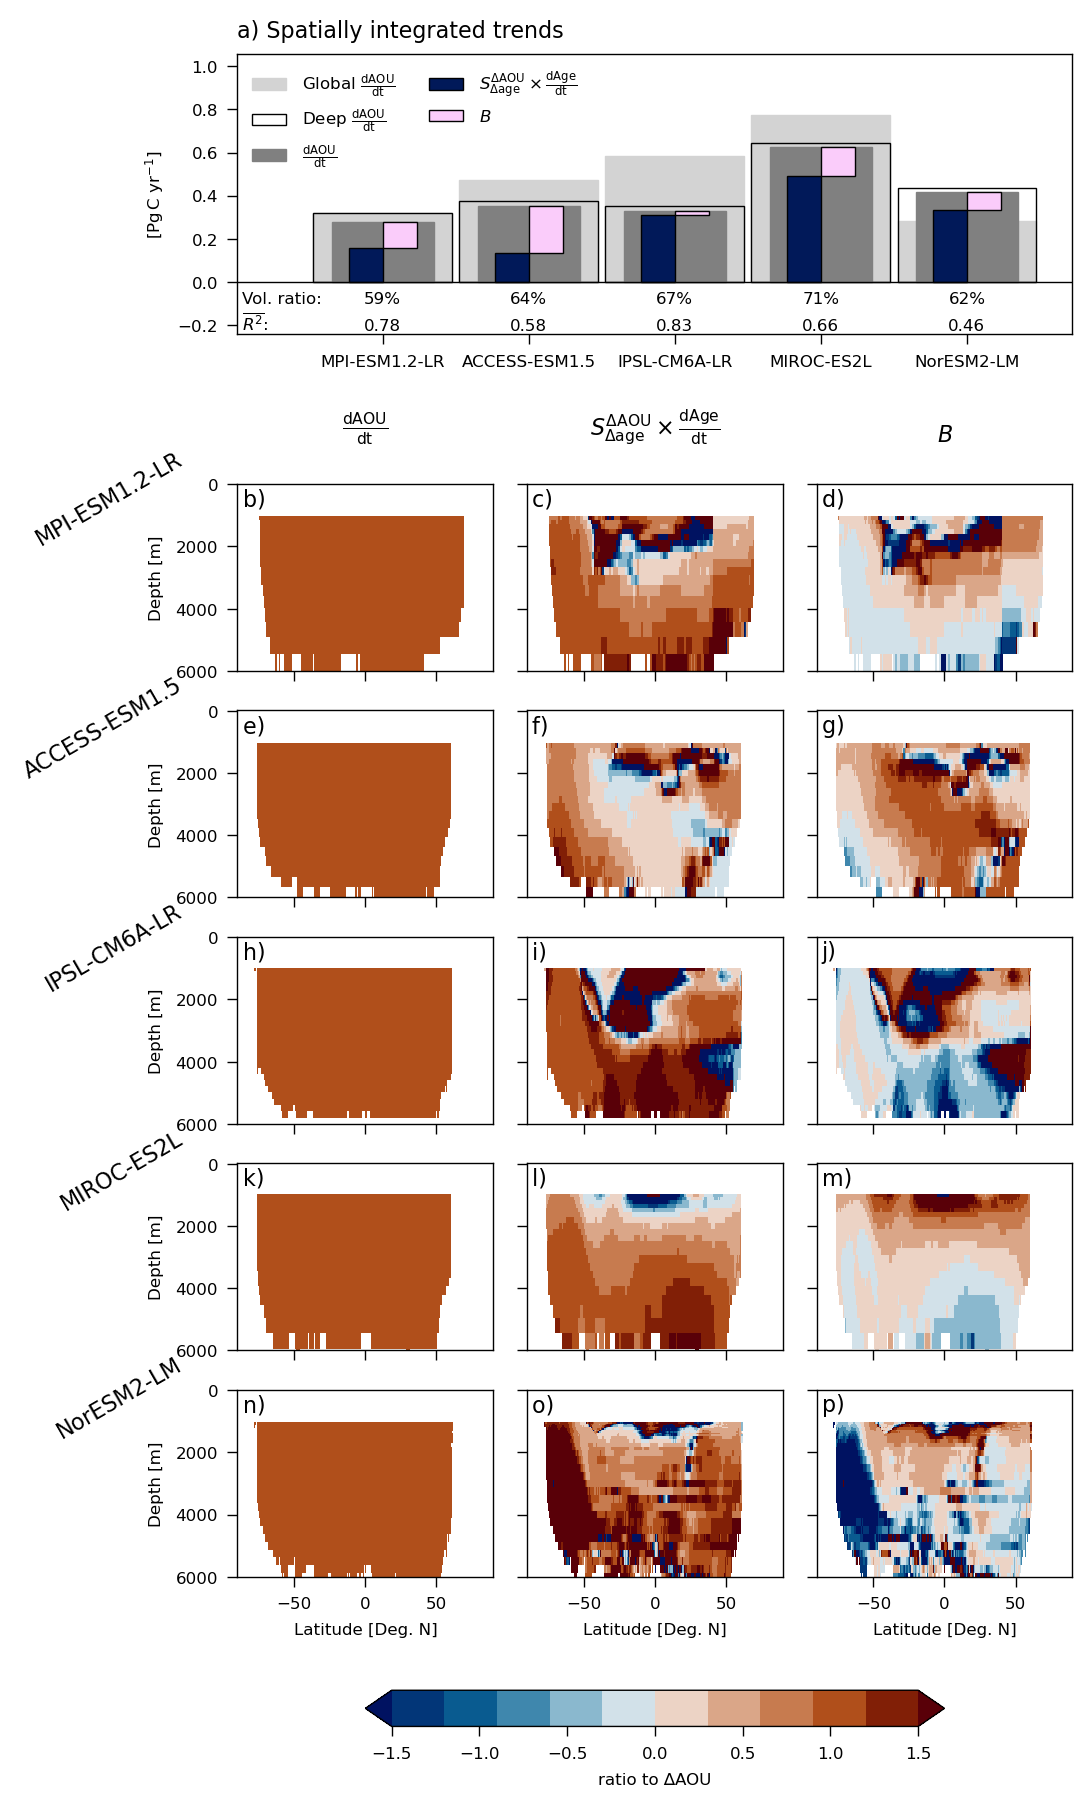

In [10]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute ∆AOU = OUR * ∆Age + intercept + residual')
print('## Plot contribution relative to ∆AOU')

#____________________
# Load data2plot

savefile = dirout + 'data2plot_AOUtrend_OURxAgetrend_reminder.pckl'
with open(savefile, 'rb') as file:
    data2plot = pickle.load(file)

#
watermass='southern and atlantic significant'

#____________________
# Set figname for saving figure

figname = dirout + 'plot_AOUtrend_OURxAgetrend_reminder_relative_contributions.png'

#--------------------
# Figure parameters
#--------------------

# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
esm_list = data2plot['ESM']
section_list = ['∆AOU', '∆Age', 'reminder']

zfact_glob = 1e-18 * 117/170 * 12.01 # mmol-O -> PgC
zfact_section = 1

#______________
# Labels
labels_dict = {
    'Global ∆AOU': r'Global $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep ∆AOU': r'Deep $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep significant ∆AOU': r'Deep significant $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆AOU'       : r'$\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆Age'       : r'$S_{\mathrm{\Delta age}}^{\mathrm{\Delta AOU}} \times \frac{\mathrm{dAge}}{\mathrm{dt}}$',
    # 'reminder'   : r'$\mathrm{Age} \times \frac{\mathrm{dOUR}}{\mathrm{dt}}$',
    'reminder'  : r'$B$'
}

#______________
# barplot colors
barplot_color_dict = {
    'Global ∆AOU': 'lightgrey',
    '∆AOU': 'grey',
    '∆Age' : cmcrameri.cm.batlowS.colors[0],
    'reminder' : cmcrameri.cm.batlowS.colors[1]
}

#______________
# barplot kwargs
kwbar = dict(linewidth=0.5, align='center')
kwbar1 = dict(linewidth=.5, align='center', edgecolor='k')

#______________
# Sections axis labeling and limits
xlabel = 'Latitude [Deg. N]'
ylabel = 'Depth [m]'
xlim = (-90, 90)
ylim = (6000, -10)

#______________
# Section cmap
a = cmcrameri.cm.vik
colors = a(np.linspace(0,1,10+2))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[0])
newcmap.set_bad("none")

#______________
# Section pcm kwargs
kwpcm = dict(cmap=newcmap, vmin=-1.5, vmax=1.5)

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

# Pop one now to save a) for the barplot at the top
extended_alphabet_reverse.pop()

#______________
# Set figure
ncol = 3
nrow = len(esm_list)
fwidth_cm = 4
fheight_cm = 3
fsize = (fwidth_cm*cm2in*ncol, fheight_cm*cm2in*nrow) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, sharex='col', sharey='row')

#--------------------
# Plot sections
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
        
    ccc_ref = data2plot['xavg']['∆AOU'][watermass][iesm]['ccc']
    
    for iii, vvv in enumerate(section_list): 

        zwdata = data2plot['xavg'][vvv][watermass][iesm]

        zax = ax[iesm, iii]
        xxx = zwdata['xxx']
        yyy = zwdata['yyy']
        ccc = zwdata['ccc'] / ccc_ref
        # ccc = np.where(ccc!=0, ccc, np.nan)
        zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm)
        pcm[iesm, iii] = zwpcm
        zax.set_ylim(ylim)
        zax.set_xlim(xlim)

        zwtxt = extended_alphabet_reverse.pop() + f') '
        zax.text(.02, .98, zwtxt, transform=zax.transAxes, ha='left', va='top')

    #
#

#--------------------
# Decorate sections
#--------------------

fig.tight_layout()

for iesm, vesm in enumerate(esm_list) : 
    zax = ax[iesm, 0]
    zax.text(-.2, 1.2, esm_name_dict[vesm], transform=zax.transAxes, ha='right', va='top', rotation=30.)
#

for zax in ax[:, 0]: zax.set_ylabel(ylabel)
for zax in ax[-1, :]: zax.set_xlabel(xlabel)
        
for iii, vvv in enumerate(section_list): 
    zax = ax[0, iii]
    zax.text(.5, 1.2, labels_dict[vvv], transform=zax.transAxes, ha='center', va='bottom')
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[-1, 0].get_position()
zw2 = ax[-1, -1].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw2.y0 - .8*zw1.height
nw  = zw2.x0 + .5*zw2.width - nx0
nh  = 0.05*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='both')
clabel = 'ratio to ∆AOU'
cbar.set_label(clabel)

#--------------------
# Add barplot
#--------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .8*zw1.height
nw  = zw2.x1 - nx0
nh  = 1.5*zw1.height
zax = fig.add_axes([nx0, ny0, nw, nh])

#_________________
# Get x-ticks and xxx and www0 and www1
xxx = np.arange(len(esm_list))

www0 =  0.95
www1 =  0.7

#_________________
# ∆AOU

var = '∆AOU'

hhh = np.array(data2plot['Global'][var]['total']) * zfact_glob
zax.bar(xxx, hhh, width=www0, label='Global ∆AOU', color=barplot_color_dict['Global '+var], edgecolor=barplot_color_dict['Global '+var], **kwbar)

hhh = np.array(data2plot['Global'][var]['deep']) * zfact_glob
zax.bar(xxx, hhh, width=www0, label='Deep ∆AOU', color='none', edgecolor='k',  **kwbar)

# hhh = np.array(data2plot['Global'][var]['deep significant']) * zfact_glob
# zax.bar(xxx, hhh, width=www0, color='none', label='Deep significant ∆AOU', linewidth=.5, ls='--', edgecolor='red', align='center')

hhh = np.array(data2plot['Global'][var][watermass]) * zfact_glob
zax.bar(xxx, hhh, width=www1, label=var, color=barplot_color_dict[var], edgecolor=barplot_color_dict[var], **kwbar)

nnn = 2
www2=www1/(nnn+1)

#_________________
# ∆Age
iii = 0
var = '∆Age'
hhh = np.array(data2plot['Global'][var][watermass]) * zfact_glob
bbb = 0*hhh
xxx1 = xxx-(nnn-(1+2*iii))*www2/2
bars = zax.bar(xxx1, hhh, width=www2, color=barplot_color_dict[var], label=var, **kwbar1)

#_________________
# Reminder
iii = 1
var = 'reminder'
bbb += hhh
hhh = np.array(data2plot['Global'][var][watermass]) * zfact_glob
xxx1 = xxx-(nnn-(1+2*iii))*www2/2
zax.bar(xxx1, hhh, bottom=bbb, width=www2, color=barplot_color_dict[var], label=var, **kwbar1)


#--------------------
# Decorate barplot
#--------------------

zax.axhline(0, c='k', lw=.5)

#____________________
# Set labels and title

ttl = 'a) Spatially integrated trends'
zax.set_title(ttl, loc='left')
zax.set_ylabel(r'[Pg$\,$C yr$^{-1}$]')
x_tick_labels = [esm_name_dict[vesm] for vesm in esm_list]
zax.set_xticks(xxx)
zax.set_xticklabels(x_tick_labels)

#____________________
# Adjust axis limits

ylim = zax.get_ylim()
dylim = 0.30*(ylim[1]-ylim[0])
ylim2 = (ylim[0]-dylim, ylim[1]+dylim)
zax.set_ylim(ylim2)

xlim = zax.get_xlim()
dxlim = 0.05*(xlim[1]-xlim[0])
xlim2 = (xlim[0]-dxlim, xlim[1])
zax.set_xlim(xlim2)


#____________________
# legend
aaa=zax.get_legend_handles_labels()
handles = aaa[0]
labels = [labels_dict[vvv] for vvv in aaa[1]]
zax.legend(handles, labels, frameon=False, handletextpad=1, ncol=2,\
           loc='upper left', bbox_to_anchor=(0, 1))

#--------------------
# Add R2 text
#--------------------
ylim = zax.get_ylim()
xlim = zax.get_xlim()

iii=0
ytext = ylim[0]+0.005*(ylim[1]-ylim[0])
for ind, val in enumerate(data2plot['Global']['R2'][watermass]): 
    xtext = xxx[ind]
    zax.text( xtext, ytext, f'{val:.2f}', ha='center', va='bottom', size=6)
#
xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
zax.text(xtext, ytext, r'$\overline{R^2}$:', ha='left', va='bottom', size=6)

#--------------------
# Add volume text
#--------------------
iii=0
ytext = ylim[0]+0.1*(ylim[1]-ylim[0])
totvolume = data2plot['Global']['volume']['total']
for ind, val in enumerate(data2plot['Global']['volume'][watermass]): 
    xtext = xxx[ind]
    zax.text( xtext, ytext, f'{val/totvolume[ind]*100:.0f}%', ha='center', va='bottom', size=6)
#
xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
zax.text(xtext, ytext, r'Vol. ratio:', ha='left', va='bottom', size=6)

#--------------------
# Print share of dAge
#--------------------
print('---- dAGE/dAOU ----')
daou = data2plot['Global']['∆AOU'][watermass]
dage = data2plot['Global']['∆Age'][watermass]
for ind, val in enumerate(data2plot['ESM']): 
    print(f'{val}: {dage[ind]/daou[ind]*100:.0f}%')
#
print('-----------------')

#--------------------
# Print dAOU, dAge
#--------------------
print('---- dAGE, dAOU ----')
daou = data2plot['Global']['∆AOU'][watermass]
dage = data2plot['Global']['∆Age'][watermass]
for ind, val in enumerate(data2plot['ESM']): 
    print(f'{val}: {dage[ind]*zfact_glob:.2f}, {daou[ind]*zfact_glob:.2f} [PgC/yr]')
#
print('-----------------')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)


## Plot each watermasses

### Prepare data2plot

In [26]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Figure ∆AOU = OUR * ∆Age + reminder')
print('## Plot each watermass')
print('### Prepare data2plot')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
tperiod = '2015-2099'


#----------------
# Define some functions
#----------------
def compute_xavg(zwnp, zwvolume): 
    zwda = xr.DataArray(zwnp, dims=zwvolume.dims, coords=zwvolume.coords)
    zwda_xavg = zonal_avg(zwda, zwvolume)
    xavg_dict = {'xxx': zwda_xavg.latitude.values, 'yyy': zwda_xavg.depth.values, 'ccc': zwda_xavg.values}
    return xavg_dict
#

#----------------
# Initiate data2plot
#----------------

data2plot = {
    'ESM': [], \
    'Global': {
        '∆AOU': {'southern dense significant':[], 'southern light significant':[], \
                 'atlantic dense significant':[], 'atlantic light significant':[], \
                 'southern dense':[], 'southern light':[], \
                 'atlantic dense':[], 'atlantic light':[]}, \
        '∆Age': {'southern dense significant':[], 'southern light significant':[], \
                 'atlantic dense significant':[], 'atlantic light significant':[], \
                 'southern dense':[], 'southern light':[], \
                 'atlantic dense':[], 'atlantic light':[]}, \
        'reminder': {'southern dense significant':[], 'southern light significant':[], \
                     'atlantic dense significant':[], 'atlantic light significant':[], \
                     'southern dense':[], 'southern light':[], \
                     'atlantic dense':[], 'atlantic light':[]}, \
        'R2': {'southern dense significant':[], 'southern light significant':[], \
               'atlantic dense significant':[], 'atlantic light significant':[], \
               'southern dense':[], 'southern light':[], \
               'atlantic dense':[], 'atlantic light':[]}, \
        'volume': {'southern dense significant':[], 'southern light significant':[], \
                   'atlantic dense significant':[], 'atlantic light significant':[], \
                   'southern dense':[], 'southern light':[], \
                   'atlantic dense':[], 'atlantic light':[]}
    }, \
    'xavg': {
        '∆AOU': {'southern dense significant':[], 'southern light significant':[], \
                 'atlantic dense significant':[], 'atlantic light significant':[], \
                 'southern dense':[], 'southern light':[], \
                 'atlantic dense':[], 'atlantic light':[]}, \
        '∆Age': {'southern dense significant':[], 'southern light significant':[], \
                 'atlantic dense significant':[], 'atlantic light significant':[], \
                 'southern dense':[], 'southern light':[], \
                 'atlantic dense':[], 'atlantic light':[]}, \
        'reminder': {'southern dense significant':[], 'southern light significant':[], \
                     'atlantic dense significant':[], 'atlantic light significant':[], \
                     'southern dense':[], 'southern light':[], \
                     'atlantic dense':[], 'atlantic light':[]}
    }
}

#----------------
# Loop on ESM
#----------------


for iesm, vesm in enumerate(esm_list):
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')

    data2plot['ESM'].append(vesm)
    
    #----------------
    # Load data
    #----------------
    print('   Load data...')

    if tperiod=='2015-2099': simu = 'ssp585'
    elif tperiod=='1986-2009': simu = 'historical'

    savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'.pckl'
    with open(savefile, 'rb') as file:
        data2process_significant = pickle.load(file)
    #
    savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'_include_low_significant_trend.pckl'
    with open(savefile, 'rb') as file:
        data2process_with_low_significant = pickle.load(file)
    #

    #----------------
    # Compute volume and omask
    #----------------
    print('   Compute volume and omask...')
    if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
    else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                  version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwds2 = zwds['areacello'].to_dataset()
    zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
    zwds2 = split_coords_dimensions(zwds2)
    zwds2 = shift_180_lon(zwds2)
    zarea = zwds2['areacello']
    # FOR MPI model, invert latitude dimension
    if vesm == 'MPI-ESM1-2-LR' : 
        zarea = zarea.isel(j=slice(None, None, -1))
    #

    fname = netcdfdir+f'{vesm}_historical_sigma0_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_sigma0 = zwds['sigma0']
    if vesm == 'MPI-ESM1-2-LR' : 
        zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
    #

    depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)

    omask = ~(zwda_sigma0.isnull()).rename('mask').drop(['latitude', 'longitude'])
    volume = omask * depthickness * zarea

    del depbounds, depthickness
    
    
    #----------------
    # Loop on water-masses
    #----------------

    for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 
        
        print(f'    {watermass}...')
        
        #________________
        # Significant water-masses

        # Global
        zw_delta_aou = data2process_significant[vesm][watermass]['integrated aou trend']
        zwage        = data2process_significant[vesm][watermass]['integrated age trend']
        zwour        = data2process_significant[vesm][watermass]['linregress']['slope']
        zwr2         = data2process_significant[vesm][watermass]['linregress']['rvalue']**2
        zwvolume     = data2process_significant[vesm][watermass]['volume']
            
        zw_delta_age = zwour * zwage
        zw_reminder = zw_delta_aou - zw_delta_age

        datatype = 'Global'
        data2plot[datatype]['∆AOU'     ][watermass+' significant'].append(zw_delta_aou)
        data2plot[datatype]['∆Age'     ][watermass+' significant'].append(zw_delta_age)
        data2plot[datatype]['reminder' ][watermass+' significant'].append(zw_reminder)
        data2plot[datatype]['R2'       ][watermass+' significant'].append(zwr2)
        data2plot[datatype]['volume'   ][watermass+' significant'].append(zwvolume)
                
        # xavg
        zw_pred_3D = data2process_significant[vesm][watermass]['aou prediction']['predicted']['3D']['ccc']
        zw_bias_3D = data2process_significant[vesm][watermass]['aou prediction']['error']['3D']['ccc']
        zw_itcpt   = data2process_significant[vesm][watermass]['linregress']['intercept']

        zw_delta_aou_3D = zw_pred_3D + zw_bias_3D
        zw_delta_age_3D = zw_pred_3D - zw_itcpt
        zw_reminder_3D  = zw_bias_3D + zw_itcpt

        datatype = 'xavg'
        xavg = compute_xavg(zw_delta_aou_3D, volume)
        data2plot[datatype]['∆AOU'][watermass+' significant'].append(xavg)
        xavg = compute_xavg(zw_delta_age_3D, volume)
        data2plot[datatype]['∆Age'][watermass+' significant'].append(xavg)
        xavg = compute_xavg(zw_reminder_3D, volume)
        data2plot[datatype]['reminder'][watermass+' significant'].append(xavg)
        
        #________________
        # Including low significant water-masses

        # Global
        zw_delta_aou = data2process_with_low_significant[vesm][watermass]['integrated aou trend']
        zwage        = data2process_with_low_significant[vesm][watermass]['integrated age trend']
        zwour        = data2process_with_low_significant[vesm][watermass]['linregress']['slope']
        zwr2         = data2process_with_low_significant[vesm][watermass]['linregress']['rvalue']**2
        zwvolume     = data2process_with_low_significant[vesm][watermass]['volume']
            
        zw_delta_age = zwour * zwage
        zw_reminder = zw_delta_aou - zw_delta_age

        datatype = 'Global'
        data2plot[datatype]['∆AOU'     ][watermass].append(zw_delta_aou)
        data2plot[datatype]['∆Age'     ][watermass].append(zw_delta_age)
        data2plot[datatype]['reminder' ][watermass].append(zw_reminder)
        data2plot[datatype]['R2'       ][watermass].append(zwr2)
        data2plot[datatype]['volume'   ][watermass].append(zwvolume)
                
        # xavg
        zw_pred_3D = data2process_significant[vesm][watermass]['aou prediction']['predicted']['3D']['ccc']
        zw_bias_3D = data2process_significant[vesm][watermass]['aou prediction']['error']['3D']['ccc']
        zw_itcpt   = data2process_significant[vesm][watermass]['linregress']['intercept']

        zw_delta_aou_3D = zw_pred_3D + zw_bias_3D
        zw_delta_age_3D = zw_pred_3D - zw_itcpt
        zw_reminder_3D  = zw_bias_3D + zw_itcpt

        datatype = 'xavg'
        xavg = compute_xavg(zw_delta_aou_3D, volume)
        data2plot[datatype]['∆AOU'][watermass].append(xavg)
        xavg = compute_xavg(zw_delta_age_3D, volume)
        data2plot[datatype]['∆Age'][watermass].append(xavg)
        xavg = compute_xavg(zw_reminder_3D, volume)
        data2plot[datatype]['reminder'][watermass].append(xavg)
    #
#

#----------------
# Save data2plot in pickle
#----------------

savefile = dirout + 'data2plot_AOUtrend_OURxAgetrend_reminder_each_watermass.pckl'
with open(savefile, "wb") as file:
    pickle.dump(data2plot, file)
#



2025-05-02 13:48:43.259487
# Figure ∆AOU = OUR * ∆Age + reminder
## Plot each watermass
### Prepare data2plot
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
   Load data...
   Compute volume and omask...
    southern dense...
    southern light...
    atlantic dense...
    atlantic light...
-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
   Load data...
   Compute volume and omask...
    southern dense...
    southern light...
    atlantic dense...
    atlantic light...
-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
   Load data...
   Compute volume and omask...
    southern dense...
    southern light...
    atlantic dense...
    atlantic light...
-----------------------
Prepare data for MIROC-ES2L...
-----------------------
   Load data...
   Compute volume and omask...
    southern dense...
    southern light...
    atlantic dense...
    atlantic light...
-----------------------
Pr

### Plot

2025-05-02 18:37:18.436124
# Compute ∆AOU = OUR * ∆Age + intercept + residual
## Plot each watermass
### Plot


<string>:121: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


---- dAGE/dAOU ----
MPI-ESM1-2-LR: 27%
ACCESS-ESM1-5: 1%
IPSL-CM6A-LR: 41%
MIROC-ES2L: 49%
NorESM2-LM: 65%
-----------------
---- dAGE, dAOU ----
MPI-ESM1-2-LR: 0.01, 0.04 [PgC/yr]
ACCESS-ESM1-5: 0.00, 0.02 [PgC/yr]
IPSL-CM6A-LR: 0.01, 0.02 [PgC/yr]
MIROC-ES2L: 0.02, 0.03 [PgC/yr]
NorESM2-LM: 0.03, 0.04 [PgC/yr]
-----------------
Save figure...
Figure saved: 25-03-28-figures-for-storyline-v2/plot_AOUtrend_OURxAgetrend_reminder_atlantic_light_significant.png
peak memory: 659.42 MiB, increment: 320.40 MiB
CPU times: user 2.33 s, sys: 963 ms, total: 3.29 s
Wall time: 2.31 s


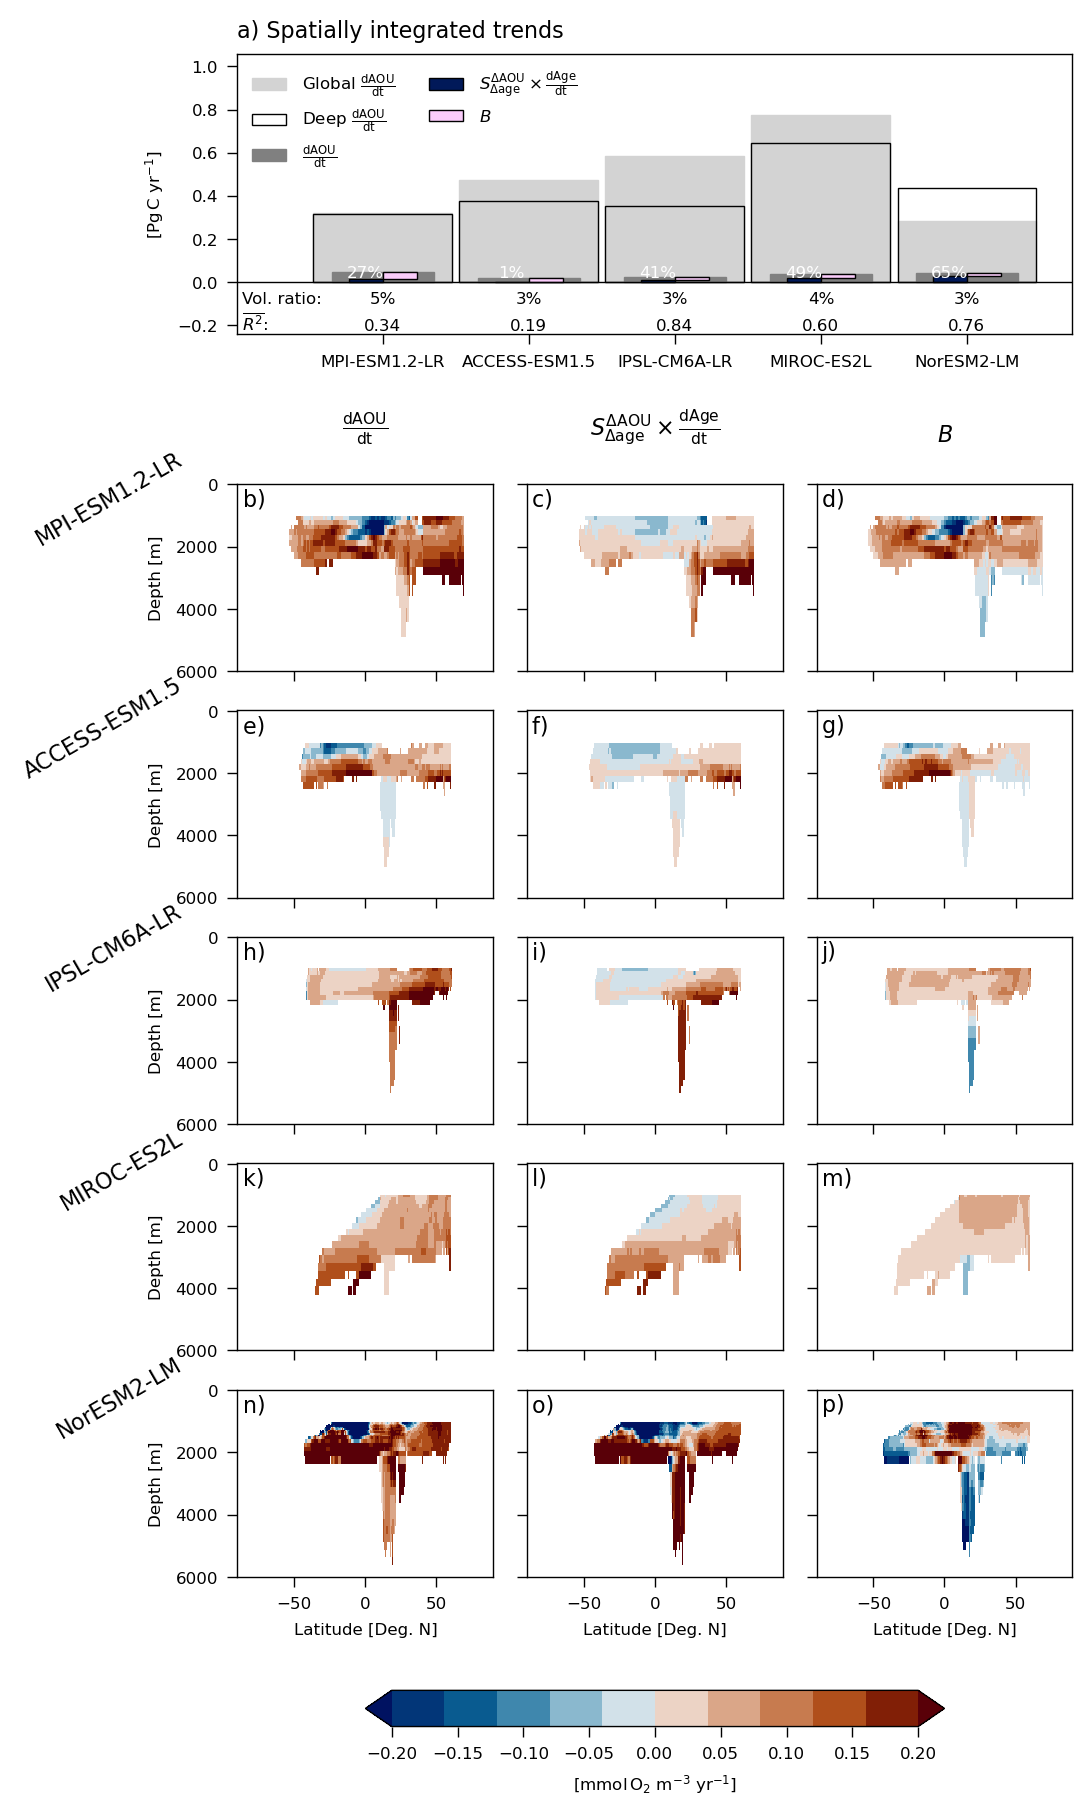

In [14]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute ∆AOU = OUR * ∆Age + intercept + residual')
print('## Plot each watermass')
print('### Plot')

#____________________
# Load data2plot

savefile = dirout + 'data2plot_AOUtrend_OURxAgetrend_reminder.pckl'
with open(savefile, 'rb') as file:
    data2plot1 = pickle.load(file)

#
savefile = dirout + 'data2plot_AOUtrend_OURxAgetrend_reminder_each_watermass.pckl'
with open(savefile, 'rb') as file:
    data2plot2 = pickle.load(file)

#
watermass='atlantic light significant'

#____________________
# Set figname for saving figure

figname = dirout + f'plot_AOUtrend_OURxAgetrend_reminder_'+watermass.replace(' ', '_')+'.png'

#--------------------
# Figure parameters
#--------------------

# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
esm_list = data2plot1['ESM']
section_list = ['∆AOU', '∆Age', 'reminder']

zfact_glob = 1e-18 * 117/170 * 12.01 # mmol-O -> PgC
zfact_section = 1

#______________
# Labels
labels_dict = {
    'Global ∆AOU': r'Global $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep ∆AOU': r'Deep $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep significant ∆AOU': r'Deep significant $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆AOU'       : r'$\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆Age'       : r'$S_{\mathrm{\Delta age}}^{\mathrm{\Delta AOU}} \times \frac{\mathrm{dAge}}{\mathrm{dt}}$',
    # 'reminder'   : r'$\mathrm{Age} \times \frac{\mathrm{dOUR}}{\mathrm{dt}}$',
    'reminder'  : r'$B$'
}

#______________
# barplot colors
barplot_color_dict = {
    'Global ∆AOU': 'lightgrey',
    '∆AOU': 'grey',
    '∆Age' : cmcrameri.cm.batlowS.colors[0],
    'reminder' : cmcrameri.cm.batlowS.colors[1]
}

#______________
# barplot kwargs
kwbar = dict(linewidth=0.5, align='center')
kwbar1 = dict(linewidth=.5, align='center', edgecolor='k')

#______________
# Sections axis labeling and limits
xlabel = 'Latitude [Deg. N]'
ylabel = 'Depth [m]'
xlim = (-90, 90)
ylim = (6000, -10)

#______________
# Section cmap
a = cmcrameri.cm.vik
colors = a(np.linspace(0,1,10+2))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[0])
newcmap.set_bad("none")

#______________
# Section pcm kwargs
kwpcm = dict(cmap=newcmap, vmin=-.2, vmax=.2)

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

# Pop one now to save a) for the barplot at the top
extended_alphabet_reverse.pop()

#______________
# Set figure
ncol = 3
nrow = len(esm_list)
fwidth_cm = 4
fheight_cm = 3
fsize = (fwidth_cm*cm2in*ncol, fheight_cm*cm2in*nrow) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, sharex='col', sharey='row')

#--------------------
# Plot sections
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    
    for iii, vvv in enumerate(section_list): 

        zwdata = data2plot2['xavg'][vvv][watermass][iesm]

        zax = ax[iesm, iii]
        xxx = zwdata['xxx']
        yyy = zwdata['yyy']
        ccc = zwdata['ccc'] * zfact_section
        # ccc = np.where(ccc!=0, ccc, np.nan)
        zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm)
        pcm[iesm, iii] = zwpcm
        zax.set_ylim(ylim)
        zax.set_xlim(xlim)

        zwtxt = extended_alphabet_reverse.pop() + f') '
        zax.text(.02, .98, zwtxt, transform=zax.transAxes, ha='left', va='top')

    #
#

#--------------------
# Decorate sections
#--------------------

fig.tight_layout()

for iesm, vesm in enumerate(esm_list) : 
    zax = ax[iesm, 0]
    zax.text(-.2, 1.2, esm_name_dict[vesm], transform=zax.transAxes, ha='right', va='top', rotation=30.)
#

for zax in ax[:, 0]: zax.set_ylabel(ylabel)
for zax in ax[-1, :]: zax.set_xlabel(xlabel)
        
for iii, vvv in enumerate(section_list): 
    zax = ax[0, iii]
    zax.text(.5, 1.2, labels_dict[vvv], transform=zax.transAxes, ha='center', va='bottom')
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[-1, 0].get_position()
zw2 = ax[-1, -1].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw2.y0 - .8*zw1.height
nw  = zw2.x0 + .5*zw2.width - nx0
nh  = 0.05*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='both')
clabel = '[mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]'
cbar.set_label(clabel)

#--------------------
# Add barplot
#--------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .8*zw1.height
nw  = zw2.x1 - nx0
nh  = 1.5*zw1.height
zax = fig.add_axes([nx0, ny0, nw, nh])

#_________________
# Get x-ticks and xxx and www0 and www1
xxx = np.arange(len(esm_list))

www0 =  0.95
www1 =  0.7

#_________________
# ∆AOU

var = '∆AOU'

hhh = np.array(data2plot1['Global'][var]['total']) * zfact_glob
zax.bar(xxx, hhh, width=www0, label='Global ∆AOU', color=barplot_color_dict['Global '+var], edgecolor=barplot_color_dict['Global '+var], **kwbar)

hhh = np.array(data2plot1['Global'][var]['deep']) * zfact_glob
zax.bar(xxx, hhh, width=www0, label='Deep ∆AOU', color='none', edgecolor='k',  **kwbar)

# hhh = np.array(data2plot['Global'][var]['deep significant']) * zfact_glob
# zax.bar(xxx, hhh, width=www0, color='none', label='Deep significant ∆AOU', linewidth=.5, ls='--', edgecolor='red', align='center')

hhh = np.array(data2plot2['Global'][var][watermass]) * zfact_glob
zax.bar(xxx, hhh, width=www1, label=var, color=barplot_color_dict[var], edgecolor=barplot_color_dict[var], **kwbar)

nnn = 2
www2=www1/(nnn+1)

#_________________
# ∆Age
iii = 0
var = '∆Age'
hhh = np.array(data2plot2['Global'][var][watermass]) * zfact_glob
bbb = 0*hhh
xxx1 = xxx-(nnn-(1+2*iii))*www2/2
bars = zax.bar(xxx1, hhh, width=www2, color=barplot_color_dict[var], label=var, **kwbar1)

#_________________
# Reminder
iii = 1
var = 'reminder'
bbb += hhh
hhh = np.array(data2plot2['Global'][var][watermass]) * zfact_glob
xxx2 = xxx-(nnn-(1+2*iii))*www2/2
zax.bar(xxx2, hhh, bottom=bbb, width=www2, color=barplot_color_dict[var], label=var, **kwbar1)


#--------------------
# Decorate barplot
#--------------------

zax.axhline(0, c='k', lw=.5)

#____________________
# Set labels and title

ttl = 'a) Spatially integrated trends'
zax.set_title(ttl, loc='left')
zax.set_ylabel(r'[Pg$\,$C yr$^{-1}$]')
x_tick_labels = [esm_name_dict[vesm] for vesm in esm_list]
zax.set_xticks(xxx)
zax.set_xticklabels(x_tick_labels)

#____________________
# Adjust axis limits

ylim = zax.get_ylim()
dylim = 0.30*(ylim[1]-ylim[0])
ylim2 = (ylim[0]-dylim, ylim[1]+dylim)
zax.set_ylim(ylim2)

xlim = zax.get_xlim()
dxlim = 0.05*(xlim[1]-xlim[0])
xlim2 = (xlim[0]-dxlim, xlim[1])
zax.set_xlim(xlim2)


#____________________
# legend
aaa=zax.get_legend_handles_labels()
handles = aaa[0]
labels = [labels_dict[vvv] for vvv in aaa[1]]
zax.legend(handles, labels, frameon=False, handletextpad=1, ncol=2,\
           loc='upper left', bbox_to_anchor=(0, 1))

#--------------------
# Add R2 text
#--------------------
ylim = zax.get_ylim()
xlim = zax.get_xlim()

iii=0
ytext = ylim[0]+0.005*(ylim[1]-ylim[0])
for ind, val in enumerate(data2plot2['Global']['R2'][watermass]): 
    xtext = xxx[ind]
    zax.text( xtext, ytext, f'{val:.2f}', ha='center', va='bottom', size=6)
#
xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
zax.text(xtext, ytext, r'$\overline{R^2}$:', ha='left', va='bottom', size=6)

#--------------------
# Add volume text
#--------------------
iii=0
ytext = ylim[0]+0.1*(ylim[1]-ylim[0])
totvolume = data2plot1['Global']['volume']['total']
for ind, val in enumerate(data2plot2['Global']['volume'][watermass]): 
    xtext = xxx[ind]
    zax.text( xtext, ytext, f'{val/totvolume[ind]*100:.0f}%', ha='center', va='bottom', size=6)
#
xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
zax.text(xtext, ytext, r'Vol. ratio:', ha='left', va='bottom', size=6)

#--------------------
# Add share of dAge
#--------------------
iii=0
ytext = 0.005*(ylim[1]-ylim[0])
daou = data2plot2['Global']['∆AOU'][watermass]
for ind, val in enumerate(data2plot2['Global']['∆Age'][watermass]): 
    xtext = xxx1[ind]
    zax.text( xtext, ytext, f'{val/daou[ind]*100:.0f}%', c='white', ha='center', va='bottom', size=6)
#

#--------------------
# Print share of dAge
#--------------------
print('---- dAGE/dAOU ----')
daou = data2plot2['Global']['∆AOU'][watermass]
dage = data2plot2['Global']['∆Age'][watermass]
for ind, val in enumerate(data2plot2['ESM']): 
    print(f'{val}: {dage[ind]/daou[ind]*100:.0f}%')
#
print('-----------------')

#--------------------
# Print dAOU, dAge
#--------------------
print('---- dAGE, dAOU ----')
daou = data2plot2['Global']['∆AOU'][watermass]
dage = data2plot2['Global']['∆Age'][watermass]
for ind, val in enumerate(data2plot2['ESM']): 
    print(f'{val}: {dage[ind]*zfact_glob:.2f}, {daou[ind]*zfact_glob:.2f} [PgC/yr]')
#
print('-----------------')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)


## For 1986-2009

### Prepare data2plot

In [28]:
%%time
%%memit -c
# ca. 2min
print(datetime.datetime.now())
print('# Figure ∆AOU = OUR * ∆Age + reminder')
print('## For 1986-2009')
print('### Prepare data2plot')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
tperiod = '1986-2009'


#----------------
# Define some functions
#----------------
def compute_xavg(zwnp, zwvolume): 
    zwda = xr.DataArray(zwnp, dims=zwvolume.dims, coords=zwvolume.coords)
    zwda_xavg = zonal_avg(zwda, zwvolume)
    xavg_dict = {'xxx': zwda_xavg.latitude.values, 'yyy': zwda_xavg.depth.values, 'ccc': zwda_xavg.values}
    return xavg_dict
#

#----------------
# Initiate data2plot
#----------------

data2plot = {
    'ESM': [], \
    'Global': {
        '∆AOU': {'total':[], 'deep':[], 'deep significant':[], \
                 'southern and atlantic significant': [], \
                 'southern and atlantic': []}, \
        '∆Age': {'southern and atlantic significant': [], \
                 'southern and atlantic': []}, \
        'reminder': {'southern and atlantic significant': [], \
                     'southern and atlantic': []}, \
        'R2': {'southern and atlantic significant': [], \
               'southern and atlantic': []}, \
        'volume': {'total':[], 'deep':[], 'deep significant':[], \
                   'southern and atlantic significant': [], \
                   'southern and atlantic': []}
    }, \
    'xavg': {
        '∆AOU': {'total':[], 'deep':[], 'deep significant':[], \
                 'southern and atlantic significant': [], \
                 'southern and atlantic': []}, \
        '∆Age': {'southern and atlantic significant': [], \
                 'southern and atlantic': []}, \
        'reminder': {'southern and atlantic significant': [], \
                     'southern and atlantic': []}        
    }
}

#----------------
# Loop on ESM
#----------------


for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')

    data2plot['ESM'].append(vesm)
    
    #----------------
    # Load data
    #----------------
    print('   Load data...')

    if tperiod=='2015-2099': simu = 'ssp585'
    elif tperiod=='1986-2009': simu = 'historical'

    savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'.pckl'
    with open(savefile, 'rb') as file:
        data2process_significant = pickle.load(file)
    #
    savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'_include_low_significant_trend.pckl'
    with open(savefile, 'rb') as file:
        data2process_with_low_significant = pickle.load(file)
    #

    #----------------
    # Compute volume and omask
    #----------------
    print('   Compute volume and omask...')
    if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
    else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                  version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwds2 = zwds['areacello'].to_dataset()
    zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
    zwds2 = split_coords_dimensions(zwds2)
    zwds2 = shift_180_lon(zwds2)
    zarea = zwds2['areacello']
    # FOR MPI model, invert latitude dimension
    if vesm == 'MPI-ESM1-2-LR' : 
        zarea = zarea.isel(j=slice(None, None, -1))
    #

    fname = netcdfdir+f'{vesm}_historical_sigma0_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_sigma0 = zwds['sigma0']
    if vesm == 'MPI-ESM1-2-LR' : 
        zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
    #

    depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)

    omask = ~(zwda_sigma0.isnull()).rename('mask').drop(['latitude', 'longitude'])
    volume = omask * depthickness * zarea

    del depbounds, depthickness
    
    #----------------
    # Southern and atlantic significant
    #----------------
    print('   Southern and atlantic significant...')

    zw_delta_aou_SA, zw_delta_age_SA, zw_reminder_SA = 0, 0, 0
    zwvolume_SA, zwr2_SA = 0, 0
    zw_delta_aou_3D_SA, zw_delta_age_3D_SA, zw_reminder_3D_SA = [], [], []
    for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 

        #______________
        # Global
        zwaou    = data2process_significant[vesm][watermass]['integrated aou trend']
        zwage    = data2process_significant[vesm][watermass]['integrated age trend']
        zwour    = data2process_significant[vesm][watermass]['linregress']['slope']
        zwr2     = data2process_significant[vesm][watermass]['linregress']['rvalue']**2
        zwvolume = data2process_significant[vesm][watermass]['volume']

        zw_delta_age = zwour * zwage
        zw_reminder = zwaou - zw_delta_age

        zw_delta_aou_SA += zwaou
        zw_delta_age_SA += zw_delta_age
        zw_reminder_SA  += zw_reminder

        zwr2_SA     += zwr2 * zwvolume
        zwvolume_SA += zwvolume
        
        #______________
        # XAVG
        zw_pred_3D = data2process_significant[vesm][watermass]['aou prediction']['predicted']['3D']['ccc']
        zw_bias_3D = data2process_significant[vesm][watermass]['aou prediction']['error']['3D']['ccc']
        zw_itcpt   = data2process_significant[vesm][watermass]['linregress']['intercept']

        zw_delta_aou_3D = zw_pred_3D + zw_bias_3D
        zw_delta_age_3D = zw_pred_3D - zw_itcpt
        zw_reminder_3D  = zw_bias_3D + zw_itcpt
        
        zw_delta_aou_3D_SA.append(zw_delta_aou_3D)
        zw_delta_age_3D_SA.append(zw_delta_age_3D)
        zw_reminder_3D_SA .append(zw_reminder_3D )


    #
    zwr2_SA = zwr2_SA / zwvolume_SA

    zw_delta_aou_3D_SA = np.array(zw_delta_aou_3D_SA)
    zw_delta_age_3D_SA = np.array(zw_delta_age_3D_SA)
    zw_reminder_3D_SA  = np.array(zw_reminder_3D_SA )

    all_nan_mask = np.all(np.isnan(zw_delta_aou_3D_SA), axis=0)
    zwnansum = np.nansum(zw_delta_aou_3D_SA, axis=0)
    zw_delta_aou_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

    all_nan_mask = np.all(np.isnan(zw_delta_age_3D_SA), axis=0)
    zwnansum = np.nansum(zw_delta_age_3D_SA, axis=0)
    zw_delta_age_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

    all_nan_mask = np.all(np.isnan(zw_reminder_3D_SA), axis=0)
    zwnansum = np.nansum(zw_reminder_3D_SA, axis=0)
    zw_reminder_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)
        
    watermass = 'southern and atlantic significant'
    #______________
    # Global
    datatype = 'Global'
    data2plot[datatype]['∆AOU'     ][watermass].append(zw_delta_aou_SA)
    data2plot[datatype]['∆Age'     ][watermass].append(zw_delta_age_SA)
    data2plot[datatype]['reminder' ][watermass].append(zw_reminder_SA)
    data2plot[datatype]['R2'       ][watermass].append(zwr2_SA)
    data2plot[datatype]['volume'   ][watermass].append(zwvolume_SA)
    #______________
    # XAVG
    datatype = 'xavg'
    xavg = compute_xavg(zw_delta_aou_3D_SA, volume)
    data2plot[datatype]['∆AOU'][watermass].append(xavg)
    xavg = compute_xavg(zw_delta_age_3D_SA, volume)
    data2plot[datatype]['∆Age'][watermass].append(xavg)
    xavg = compute_xavg(zw_reminder_3D_SA, volume)
    data2plot[datatype]['reminder'][watermass].append(xavg)

    #----------------
    # Southern and atlantic including low significant water-masses
    #----------------
    print('   Southern and atlantic including low significant water-masses...')
    
    zw_delta_aou_SA, zw_delta_age_SA, zw_reminder_SA = 0, 0, 0
    zwvolume_SA, zwr2_SA = 0, 0
    zw_delta_aou_3D_SA, zw_delta_age_3D_SA, zw_reminder_3D_SA = [], [], []
    for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 

        #______________
        # Global
        zwaou    = data2process_with_low_significant[vesm][watermass]['integrated aou trend']
        zwage    = data2process_with_low_significant[vesm][watermass]['integrated age trend']
        zwour    = data2process_with_low_significant[vesm][watermass]['linregress']['slope']
        zwr2     = data2process_with_low_significant[vesm][watermass]['linregress']['rvalue']**2
        zwvolume = data2process_with_low_significant[vesm][watermass]['volume']

        zw_delta_age = zwour * zwage
        zw_reminder = zwaou - zw_delta_age

        zw_delta_aou_SA += zwaou
        zw_delta_age_SA += zw_delta_age
        zw_reminder_SA  += zw_reminder

        zwr2_SA     += zwr2 * zwvolume
        zwvolume_SA += zwvolume
        
        #______________
        # XAVG
        zw_pred_3D = data2process_with_low_significant[vesm][watermass]['aou prediction']['predicted']['3D']['ccc']
        zw_bias_3D = data2process_with_low_significant[vesm][watermass]['aou prediction']['error']['3D']['ccc']
        zw_itcpt   = data2process_with_low_significant[vesm][watermass]['linregress']['intercept']

        zw_delta_aou_3D = zw_pred_3D + zw_bias_3D
        zw_delta_age_3D = zw_pred_3D - zw_itcpt
        zw_reminder_3D  = zw_bias_3D + zw_itcpt
        
        zw_delta_aou_3D_SA.append(zw_delta_aou_3D)
        zw_delta_age_3D_SA.append(zw_delta_age_3D)
        zw_reminder_3D_SA .append(zw_reminder_3D )


    #
    zwr2_SA = zwr2_SA / zwvolume_SA

    zw_delta_aou_3D_SA = np.array(zw_delta_aou_3D_SA)
    zw_delta_age_3D_SA = np.array(zw_delta_age_3D_SA)
    zw_reminder_3D_SA  = np.array(zw_reminder_3D_SA )

    all_nan_mask = np.all(np.isnan(zw_delta_aou_3D_SA), axis=0)
    zwnansum = np.nansum(zw_delta_aou_3D_SA, axis=0)
    zw_delta_aou_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

    all_nan_mask = np.all(np.isnan(zw_delta_age_3D_SA), axis=0)
    zwnansum = np.nansum(zw_delta_age_3D_SA, axis=0)
    zw_delta_age_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

    all_nan_mask = np.all(np.isnan(zw_reminder_3D_SA), axis=0)
    zwnansum = np.nansum(zw_reminder_3D_SA, axis=0)
    zw_reminder_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)
        
    watermass = 'southern and atlantic'
    #______________
    # Global
    datatype = 'Global'
    data2plot[datatype]['∆AOU'     ][watermass].append(zw_delta_aou_SA)
    data2plot[datatype]['∆Age'     ][watermass].append(zw_delta_age_SA)
    data2plot[datatype]['reminder' ][watermass].append(zw_reminder_SA)
    data2plot[datatype]['R2'       ][watermass].append(zwr2_SA)
    data2plot[datatype]['volume'   ][watermass].append(zwvolume_SA)
    #______________
    # XAVG
    datatype = 'xavg'
    xavg = compute_xavg(zw_delta_aou_3D_SA, volume)
    data2plot[datatype]['∆AOU'][watermass].append(xavg)
    xavg = compute_xavg(zw_delta_age_3D_SA, volume)
    data2plot[datatype]['∆Age'][watermass].append(xavg)
    xavg = compute_xavg(zw_reminder_3D_SA, volume)
    data2plot[datatype]['reminder'][watermass].append(xavg)
       
    #----------------
    # Total, deep and deep significant (only ∆AOU and volume)...
    #----------------
    print('   Total, deep and deep significant (only ∆AOU and volume)...')
    
    datatype = 'Global'
    
    # total
    watermass = 'total'
    zw_delta_aou = data2process_significant[vesm][watermass]['integrated aou trend']
    data2plot[datatype]['∆AOU'     ][watermass].append(zw_delta_aou)
    zwvolume     = data2process_significant[vesm][watermass]['volume']
    data2plot[datatype]['volume'     ][watermass].append(zwvolume)
    
    # deep significant
    watermass = 'deep'
    zw_delta_aou = data2process_significant[vesm][watermass]['integrated aou trend']
    data2plot[datatype]['∆AOU'     ][watermass+' significant'].append(zw_delta_aou)
    zwvolume     = data2process_significant[vesm][watermass]['volume']
    data2plot[datatype]['volume'     ][watermass+' significant'].append(zwvolume)
    
    # deep including low significance
    watermass = 'deep'
    zw_delta_aou = data2process_with_low_significant[vesm][watermass]['integrated aou trend']
    data2plot[datatype]['∆AOU'     ][watermass].append(zw_delta_aou)
    zwvolume     = data2process_significant[vesm][watermass]['volume']
    data2plot[datatype]['volume'     ][watermass].append(zwvolume)

    #
#

#----------------
# Save data2plot in pickle
#----------------

savefile = dirout + f'data2plot_AOUtrend_OURxAgetrend_reminder_{tperiod}.pckl'
with open(savefile, "wb") as file:
    pickle.dump(data2plot, file)
#



2025-05-02 13:51:21.214185
# Figure ∆AOU = OUR * ∆Age + reminder
## For 1986-2009
### Prepare data2plot
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
   Load data...
   Compute volume and omask...
   Southern and atlantic significant...
   Southern and atlantic including low significant water-masses...
   Total, deep and deep significant (only ∆AOU and volume)...
-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
   Load data...
   Compute volume and omask...
   Southern and atlantic significant...
   Southern and atlantic including low significant water-masses...
   Total, deep and deep significant (only ∆AOU and volume)...
-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
   Load data...
   Compute volume and omask...
   Southern and atlantic significant...
   Southern and atlantic including low significant water-masses...
   Total, deep and deep significant (only ∆AOU and volume)...
---

### Plot

2025-05-02 18:37:29.854470
# Compute ∆AOU = OUR * ∆Age + intercept + residual
## For 1986-2009
### Plot


<string>:116: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


---- dAGE/dAOU ----
MPI-ESM1-2-LR: 61%
ACCESS-ESM1-5: 43%
IPSL-CM6A-LR: 106%
MIROC-ES2L: 77%
NorESM2-LM: 72%
-----------------
---- dAGE, dAOU ----
MPI-ESM1-2-LR: 0.04, 0.07 [PgC/yr]
ACCESS-ESM1-5: 0.01, 0.01 [PgC/yr]
IPSL-CM6A-LR: 0.05, 0.04 [PgC/yr]
MIROC-ES2L: 0.11, 0.15 [PgC/yr]
NorESM2-LM: -0.05, -0.06 [PgC/yr]
-----------------
Save figure...
Figure saved: 25-03-28-figures-for-storyline-v2/plot_AOUtrend_OURxAgetrend_reminder_1986-2009.png
peak memory: 659.67 MiB, increment: 320.58 MiB
CPU times: user 2.54 s, sys: 996 ms, total: 3.53 s
Wall time: 2.38 s


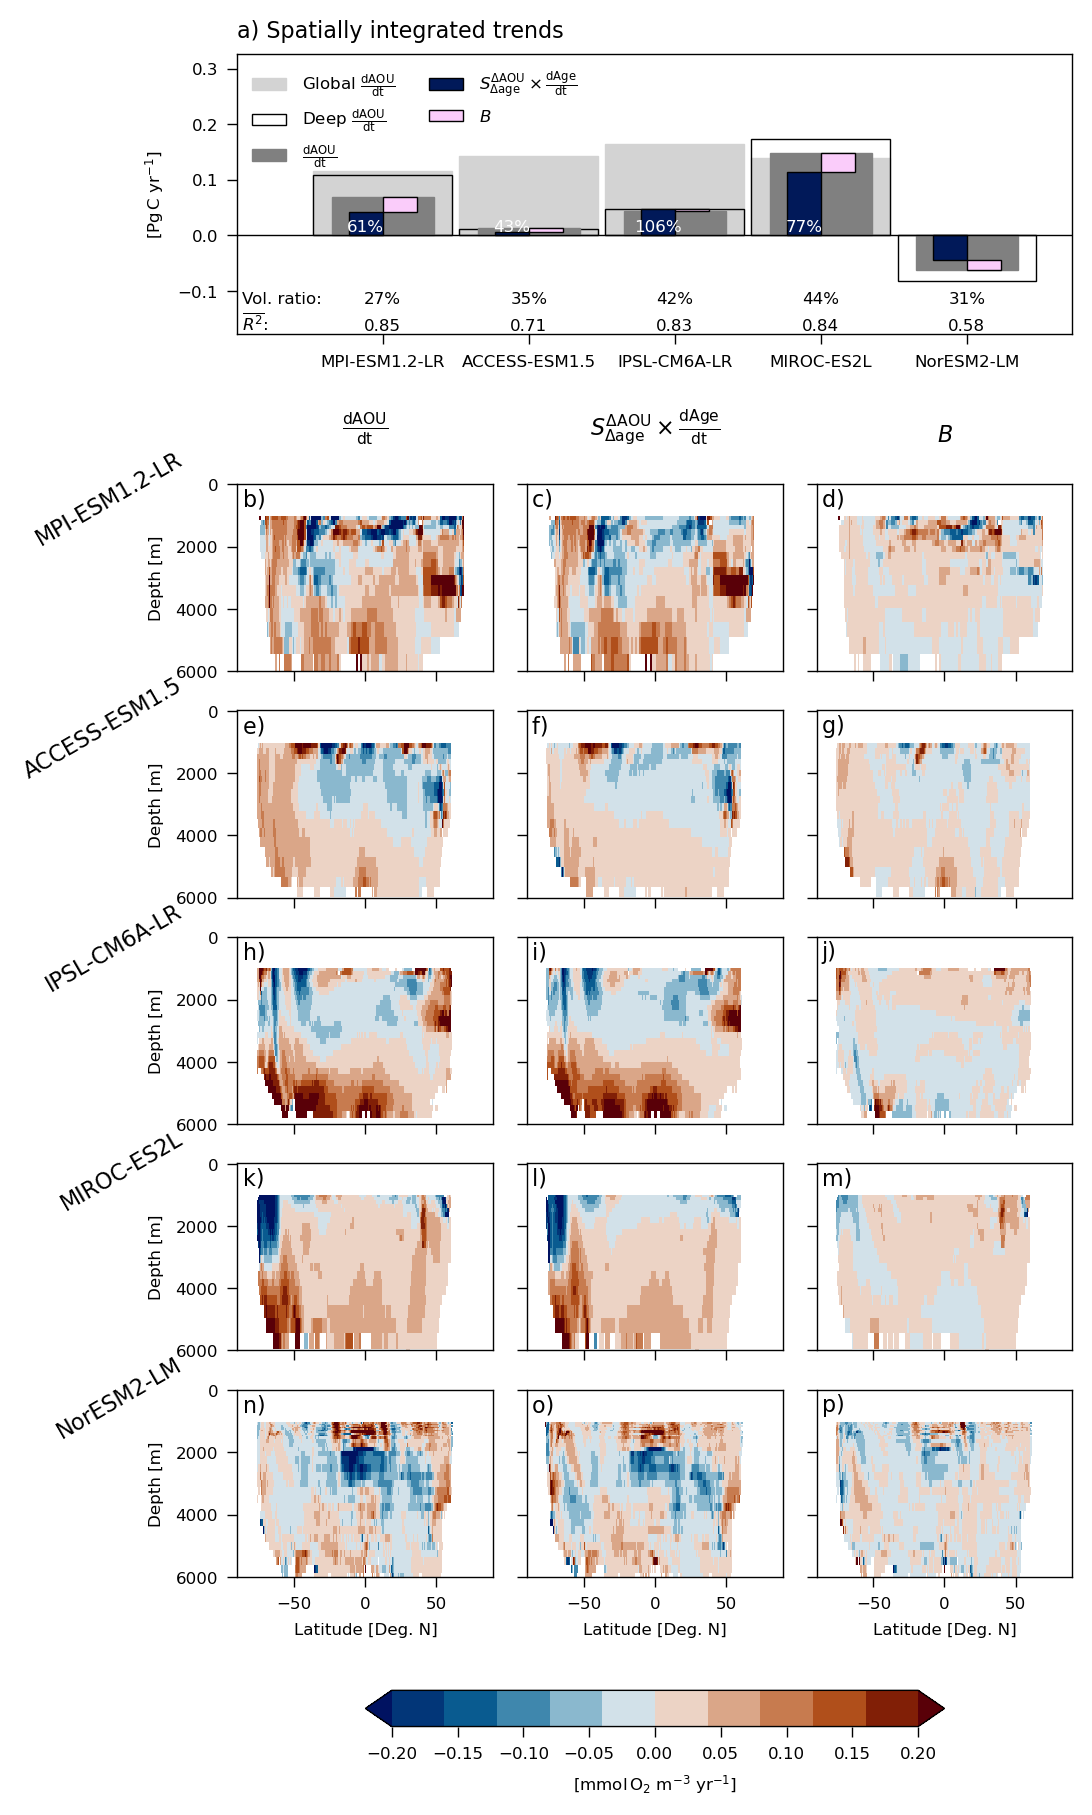

In [15]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute ∆AOU = OUR * ∆Age + intercept + residual')
print('## For 1986-2009')
print('### Plot')

#____________________
# Load data2plot

savefile = dirout + 'data2plot_AOUtrend_OURxAgetrend_reminder_1986-2009.pckl'
with open(savefile, 'rb') as file:
    data2plot = pickle.load(file)

#
watermass='southern and atlantic significant'

#____________________
# Set figname for saving figure

figname = dirout + 'plot_AOUtrend_OURxAgetrend_reminder_1986-2009.png'

#--------------------
# Figure parameters
#--------------------

# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
esm_list = data2plot['ESM']
section_list = ['∆AOU', '∆Age', 'reminder']

zfact_glob = 1e-18 * 117/170 * 12.01 # mmol-O -> PgC
zfact_section = 1

#______________
# Labels
labels_dict = {
    'Global ∆AOU': r'Global $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep ∆AOU': r'Deep $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep significant ∆AOU': r'Deep significant $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆AOU'       : r'$\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆Age'       : r'$S_{\mathrm{\Delta age}}^{\mathrm{\Delta AOU}} \times \frac{\mathrm{dAge}}{\mathrm{dt}}$',
    # 'reminder'   : r'$\mathrm{Age} \times \frac{\mathrm{dOUR}}{\mathrm{dt}}$',
    'reminder'  : r'$B$'
}

#______________
# barplot colors
barplot_color_dict = {
    'Global ∆AOU': 'lightgrey',
    '∆AOU': 'grey',
    '∆Age' : cmcrameri.cm.batlowS.colors[0],
    'reminder' : cmcrameri.cm.batlowS.colors[1]
}

#______________
# barplot kwargs
kwbar = dict(linewidth=0.5, align='center')
kwbar1 = dict(linewidth=.5, align='center', edgecolor='k')

#______________
# Sections axis labeling and limits
xlabel = 'Latitude [Deg. N]'
ylabel = 'Depth [m]'
xlim = (-90, 90)
ylim = (6000, -10)

#______________
# Section cmap
a = cmcrameri.cm.vik
colors = a(np.linspace(0,1,10+2))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[0])
newcmap.set_bad("none")

#______________
# Section pcm kwargs
kwpcm = dict(cmap=newcmap, vmin=-.2, vmax=.2)

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

# Pop one now to save a) for the barplot at the top
extended_alphabet_reverse.pop()

#______________
# Set figure
ncol = 3
nrow = len(esm_list)
fwidth_cm = 4
fheight_cm = 3
fsize = (fwidth_cm*cm2in*ncol, fheight_cm*cm2in*nrow) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, sharex='col', sharey='row')

#--------------------
# Plot sections
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    
    for iii, vvv in enumerate(section_list): 

        zwdata = data2plot['xavg'][vvv][watermass][iesm]

        zax = ax[iesm, iii]
        xxx = zwdata['xxx']
        yyy = zwdata['yyy']
        ccc = zwdata['ccc'] * zfact_section
        # ccc = np.where(ccc!=0, ccc, np.nan)
        zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm)
        pcm[iesm, iii] = zwpcm
        zax.set_ylim(ylim)
        zax.set_xlim(xlim)

        zwtxt = extended_alphabet_reverse.pop() + f') '
        zax.text(.02, .98, zwtxt, transform=zax.transAxes, ha='left', va='top')
    #
    
    
#

#--------------------
# Decorate sections
#--------------------

fig.tight_layout()

for iesm, vesm in enumerate(esm_list) : 
    zax = ax[iesm, 0]
    zax.text(-.2, 1.2, esm_name_dict[vesm], transform=zax.transAxes, ha='right', va='top', rotation=30.)
#

for zax in ax[:, 0]: zax.set_ylabel(ylabel)
for zax in ax[-1, :]: zax.set_xlabel(xlabel)
        
for iii, vvv in enumerate(section_list): 
    zax = ax[0, iii]
    zax.text(.5, 1.2, labels_dict[vvv], transform=zax.transAxes, ha='center', va='bottom')
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[-1, 0].get_position()
zw2 = ax[-1, -1].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw2.y0 - .8*zw1.height
nw  = zw2.x0 + .5*zw2.width - nx0
nh  = 0.05*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='both')
clabel = '[mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]'
cbar.set_label(clabel)

#--------------------
# Add barplot
#--------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .8*zw1.height
nw  = zw2.x1 - nx0
nh  = 1.5*zw1.height
zax = fig.add_axes([nx0, ny0, nw, nh])

#_________________
# Get x-ticks and xxx and www0 and www1
xxx = np.arange(len(esm_list))

www0 =  0.95
www1 =  0.7

#_________________
# ∆AOU

var = '∆AOU'

hhh = np.array(data2plot['Global'][var]['total']) * zfact_glob
zax.bar(xxx, hhh, width=www0, label='Global ∆AOU', color=barplot_color_dict['Global '+var], edgecolor=barplot_color_dict['Global '+var], **kwbar)

hhh = np.array(data2plot['Global'][var]['deep']) * zfact_glob
zax.bar(xxx, hhh, width=www0, label='Deep ∆AOU', color='none', edgecolor='k',  **kwbar)

# hhh = np.array(data2plot['Global'][var]['deep significant']) * zfact_glob
# zax.bar(xxx, hhh, width=www0, color='none', label='Deep significant ∆AOU', linewidth=.5, ls='--', edgecolor='red', align='center')

hhh = np.array(data2plot['Global'][var][watermass]) * zfact_glob
zax.bar(xxx, hhh, width=www1, label=var, color=barplot_color_dict[var], edgecolor=barplot_color_dict[var], **kwbar)

nnn = 2
www2=www1/(nnn+1)

#_________________
# ∆Age
iii = 0
var = '∆Age'
hhh = np.array(data2plot['Global'][var][watermass]) * zfact_glob
bbb = 0*hhh
xxx1 = xxx-(nnn-(1+2*iii))*www2/2
bars = zax.bar(xxx1, hhh, width=www2, color=barplot_color_dict[var], label=var, **kwbar1)

#_________________
# Reminder
iii = 1
var = 'reminder'
bbb += hhh
hhh = np.array(data2plot['Global'][var][watermass]) * zfact_glob
xxx2 = xxx-(nnn-(1+2*iii))*www2/2
zax.bar(xxx2, hhh, bottom=bbb, width=www2, color=barplot_color_dict[var], label=var, **kwbar1)


#--------------------
# Decorate barplot
#--------------------

zax.axhline(0, c='k', lw=.5)

#____________________
# Set labels and title

ttl = 'a) Spatially integrated trends'
zax.set_title(ttl, loc='left')
zax.set_ylabel(r'[Pg$\,$C yr$^{-1}$]')
x_tick_labels = [esm_name_dict[vesm] for vesm in esm_list]
zax.set_xticks(xxx)
zax.set_xticklabels(x_tick_labels)

#____________________
# Adjust axis limits

ylim = zax.get_ylim()
dylim1 = 0.30*(ylim[1]-ylim[0])
dylim2 = 0.50*(ylim[1]-ylim[0])
ylim2 = (ylim[0]-dylim1, ylim[1]+dylim2)
zax.set_ylim(ylim2)

xlim = zax.get_xlim()
dxlim = 0.05*(xlim[1]-xlim[0])
xlim2 = (xlim[0]-dxlim, xlim[1])
zax.set_xlim(xlim2)


#____________________
# legend
aaa=zax.get_legend_handles_labels()
handles = aaa[0]
labels = [labels_dict[vvv] for vvv in aaa[1]]
zax.legend(handles, labels, frameon=False, handletextpad=1, ncol=2,\
           loc='upper left', bbox_to_anchor=(0, 1))

#--------------------
# Add R2 text
#--------------------
ylim = zax.get_ylim()
xlim = zax.get_xlim()

iii=0
ytext = ylim[0]+0.005*(ylim[1]-ylim[0])
for ind, val in enumerate(data2plot['Global']['R2'][watermass]): 
    xtext = xxx[ind]
    zax.text( xtext, ytext, f'{val:.2f}', ha='center', va='bottom', size=6)
#
xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
zax.text(xtext, ytext, r'$\overline{R^2}$:', ha='left', va='bottom', size=6)

#--------------------
# Add volume text
#--------------------
iii=0
ytext = ylim[0]+0.1*(ylim[1]-ylim[0])
totvolume = data2plot['Global']['volume']['total']
for ind, val in enumerate(data2plot['Global']['volume'][watermass]): 
    xtext = xxx[ind]
    zax.text( xtext, ytext, f'{val/totvolume[ind]*100:.0f}%', ha='center', va='bottom', size=6)
#
xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
zax.text(xtext, ytext, r'Vol. ratio:', ha='left', va='bottom', size=6)

#--------------------
# Add share of dAge
#--------------------
iii=0
ytext = 0.005*(ylim[1]-ylim[0])
daou = data2plot['Global']['∆AOU'][watermass]
for ind, val in enumerate(data2plot['Global']['∆Age'][watermass]): 
    xtext = xxx1[ind]
    zax.text( xtext, ytext, f'{val/daou[ind]*100:.0f}%', c='white', ha='center', va='bottom', size=6)
#

#--------------------
# Print share of dAge
#--------------------
print('---- dAGE/dAOU ----')
daou = data2plot['Global']['∆AOU'][watermass]
dage = data2plot['Global']['∆Age'][watermass]
for ind, val in enumerate(data2plot['ESM']): 
    print(f'{val}: {dage[ind]/daou[ind]*100:.0f}%')
#
print('-----------------')

#--------------------
# Print dAOU, dAge
#--------------------
print('---- dAGE, dAOU ----')
daou = data2plot['Global']['∆AOU'][watermass]
dage = data2plot['Global']['∆Age'][watermass]
for ind, val in enumerate(data2plot['ESM']): 
    print(f'{val}: {dage[ind]*zfact_glob:.2f}, {daou[ind]*zfact_glob:.2f} [PgC/yr]')
#
print('-----------------')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)


### Plot each watermasses

#### Prepare data2plot

In [9]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Figure ∆AOU = OUR * ∆Age + reminder')
print('## For 1986-2009')
print('### Plot each watermass')
print('#### Prepare data2plot')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
tperiod = '1986-2009'


#----------------
# Define some functions
#----------------
def compute_xavg(zwnp, zwvolume): 
    zwda = xr.DataArray(zwnp, dims=zwvolume.dims, coords=zwvolume.coords)
    zwda_xavg = zonal_avg(zwda, zwvolume)
    xavg_dict = {'xxx': zwda_xavg.latitude.values, 'yyy': zwda_xavg.depth.values, 'ccc': zwda_xavg.values}
    return xavg_dict
#

#----------------
# Initiate data2plot
#----------------

data2plot = {
    'ESM': [], \
    'Global': {
        '∆AOU': {'southern dense significant':[], 'southern light significant':[], \
                 'atlantic dense significant':[], 'atlantic light significant':[], \
                 'southern dense':[], 'southern light':[], \
                 'atlantic dense':[], 'atlantic light':[]}, \
        '∆Age': {'southern dense significant':[], 'southern light significant':[], \
                 'atlantic dense significant':[], 'atlantic light significant':[], \
                 'southern dense':[], 'southern light':[], \
                 'atlantic dense':[], 'atlantic light':[]}, \
        'reminder': {'southern dense significant':[], 'southern light significant':[], \
                     'atlantic dense significant':[], 'atlantic light significant':[], \
                     'southern dense':[], 'southern light':[], \
                     'atlantic dense':[], 'atlantic light':[]}, \
        'R2': {'southern dense significant':[], 'southern light significant':[], \
               'atlantic dense significant':[], 'atlantic light significant':[], \
               'southern dense':[], 'southern light':[], \
               'atlantic dense':[], 'atlantic light':[]}, \
        'volume': {'southern dense significant':[], 'southern light significant':[], \
                   'atlantic dense significant':[], 'atlantic light significant':[], \
                   'southern dense':[], 'southern light':[], \
                   'atlantic dense':[], 'atlantic light':[]}
    }, \
    'xavg': {
        '∆AOU': {'southern dense significant':[], 'southern light significant':[], \
                 'atlantic dense significant':[], 'atlantic light significant':[], \
                 'southern dense':[], 'southern light':[], \
                 'atlantic dense':[], 'atlantic light':[]}, \
        '∆Age': {'southern dense significant':[], 'southern light significant':[], \
                 'atlantic dense significant':[], 'atlantic light significant':[], \
                 'southern dense':[], 'southern light':[], \
                 'atlantic dense':[], 'atlantic light':[]}, \
        'reminder': {'southern dense significant':[], 'southern light significant':[], \
                     'atlantic dense significant':[], 'atlantic light significant':[], \
                     'southern dense':[], 'southern light':[], \
                     'atlantic dense':[], 'atlantic light':[]}
    }
}

#----------------
# Loop on ESM
#----------------


for iesm, vesm in enumerate(esm_list):
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')

    data2plot['ESM'].append(vesm)
    
    #----------------
    # Load data
    #----------------
    print('   Load data...')

    if tperiod=='2015-2099': simu = 'ssp585'
    elif tperiod=='1986-2009': simu = 'historical'

    savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'.pckl'
    with open(savefile, 'rb') as file:
        data2process_significant = pickle.load(file)
    #
    savefile = dirout + 'data2plot_aou_trend_vs_age_trend_'+simu+'_'+tperiod+'_include_low_significant_trend.pckl'
    with open(savefile, 'rb') as file:
        data2process_with_low_significant = pickle.load(file)
    #

    #----------------
    # Compute volume and omask
    #----------------
    print('   Compute volume and omask...')
    if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
    else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                  version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwds2 = zwds['areacello'].to_dataset()
    zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
    zwds2 = split_coords_dimensions(zwds2)
    zwds2 = shift_180_lon(zwds2)
    zarea = zwds2['areacello']
    # FOR MPI model, invert latitude dimension
    if vesm == 'MPI-ESM1-2-LR' : 
        zarea = zarea.isel(j=slice(None, None, -1))
    #

    fname = netcdfdir+f'{vesm}_historical_sigma0_average_on_1986-2009.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_sigma0 = zwds['sigma0']
    if vesm == 'MPI-ESM1-2-LR' : 
        zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
    #

    depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)

    omask = ~(zwda_sigma0.isnull()).rename('mask').drop(['latitude', 'longitude'])
    volume = omask * depthickness * zarea

    del depbounds, depthickness
    
    
    #----------------
    # Loop on water-masses
    #----------------

    for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 
        
        print(f'    {watermass}...')
        
        #________________
        # Significant water-masses

        # Global
        zw_delta_aou = data2process_significant[vesm][watermass]['integrated aou trend']
        zwage        = data2process_significant[vesm][watermass]['integrated age trend']
        zwour        = data2process_significant[vesm][watermass]['linregress']['slope']
        zwr2         = data2process_significant[vesm][watermass]['linregress']['rvalue']**2
        zwvolume     = data2process_significant[vesm][watermass]['volume']
            
        zw_delta_age = zwour * zwage
        zw_reminder = zw_delta_aou - zw_delta_age

        datatype = 'Global'
        data2plot[datatype]['∆AOU'     ][watermass+' significant'].append(zw_delta_aou)
        data2plot[datatype]['∆Age'     ][watermass+' significant'].append(zw_delta_age)
        data2plot[datatype]['reminder' ][watermass+' significant'].append(zw_reminder)
        data2plot[datatype]['R2'       ][watermass+' significant'].append(zwr2)
        data2plot[datatype]['volume'   ][watermass+' significant'].append(zwvolume)
                
        # xavg
        zw_pred_3D = data2process_significant[vesm][watermass]['aou prediction']['predicted']['3D']['ccc']
        zw_bias_3D = data2process_significant[vesm][watermass]['aou prediction']['error']['3D']['ccc']
        zw_itcpt   = data2process_significant[vesm][watermass]['linregress']['intercept']

        zw_delta_aou_3D = zw_pred_3D + zw_bias_3D
        zw_delta_age_3D = zw_pred_3D - zw_itcpt
        zw_reminder_3D  = zw_bias_3D + zw_itcpt

        datatype = 'xavg'
        xavg = compute_xavg(zw_delta_aou_3D, volume)
        data2plot[datatype]['∆AOU'][watermass+' significant'].append(xavg)
        xavg = compute_xavg(zw_delta_age_3D, volume)
        data2plot[datatype]['∆Age'][watermass+' significant'].append(xavg)
        xavg = compute_xavg(zw_reminder_3D, volume)
        data2plot[datatype]['reminder'][watermass+' significant'].append(xavg)
        
        #________________
        # Including low significant water-masses

        # Global
        zw_delta_aou = data2process_with_low_significant[vesm][watermass]['integrated aou trend']
        zwage        = data2process_with_low_significant[vesm][watermass]['integrated age trend']
        zwour        = data2process_with_low_significant[vesm][watermass]['linregress']['slope']
        zwr2         = data2process_with_low_significant[vesm][watermass]['linregress']['rvalue']**2
        zwvolume     = data2process_with_low_significant[vesm][watermass]['volume']
            
        zw_delta_age = zwour * zwage
        zw_reminder = zw_delta_aou - zw_delta_age

        datatype = 'Global'
        data2plot[datatype]['∆AOU'     ][watermass].append(zw_delta_aou)
        data2plot[datatype]['∆Age'     ][watermass].append(zw_delta_age)
        data2plot[datatype]['reminder' ][watermass].append(zw_reminder)
        data2plot[datatype]['R2'       ][watermass].append(zwr2)
        data2plot[datatype]['volume'   ][watermass].append(zwvolume)
                
        # xavg
        zw_pred_3D = data2process_significant[vesm][watermass]['aou prediction']['predicted']['3D']['ccc']
        zw_bias_3D = data2process_significant[vesm][watermass]['aou prediction']['error']['3D']['ccc']
        zw_itcpt   = data2process_significant[vesm][watermass]['linregress']['intercept']

        zw_delta_aou_3D = zw_pred_3D + zw_bias_3D
        zw_delta_age_3D = zw_pred_3D - zw_itcpt
        zw_reminder_3D  = zw_bias_3D + zw_itcpt

        datatype = 'xavg'
        xavg = compute_xavg(zw_delta_aou_3D, volume)
        data2plot[datatype]['∆AOU'][watermass].append(xavg)
        xavg = compute_xavg(zw_delta_age_3D, volume)
        data2plot[datatype]['∆Age'][watermass].append(xavg)
        xavg = compute_xavg(zw_reminder_3D, volume)
        data2plot[datatype]['reminder'][watermass].append(xavg)
    #
#

#----------------
# Save data2plot in pickle
#----------------

savefile = dirout + 'data2plot_AOUtrend_OURxAgetrend_reminder_1986-2009_each_watermass.pckl'
with open(savefile, "wb") as file:
    pickle.dump(data2plot, file)
#



2025-05-02 15:15:29.860837
# Figure ∆AOU = OUR * ∆Age + reminder
## For 1986-2009
### Plot each watermass
#### Prepare data2plot
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
   Load data...
   Compute volume and omask...
    southern dense...
    southern light...
    atlantic dense...
    atlantic light...
-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
   Load data...
   Compute volume and omask...
    southern dense...
    southern light...
    atlantic dense...
    atlantic light...
-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
   Load data...
   Compute volume and omask...
    southern dense...
    southern light...
    atlantic dense...
    atlantic light...
-----------------------
Prepare data for MIROC-ES2L...
-----------------------
   Load data...
   Compute volume and omask...
    southern dense...
    southern light...
    atlantic dense...
    atlantic light...
-------

#### Plot

2025-05-02 18:38:12.075489
# Compute ∆AOU = OUR * ∆Age + intercept + residual
## Plot each watermass
### Plot


<string>:121: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


---- dAGE/dAOU ----
MPI-ESM1-2-LR: 38%
ACCESS-ESM1-5: 97%
IPSL-CM6A-LR: 173%
MIROC-ES2L: 95%
NorESM2-LM: 74%
-----------------
---- dAGE, dAOU ----
MPI-ESM1-2-LR: 0.00, 0.01 [PgC/yr]
ACCESS-ESM1-5: -0.01, -0.01 [PgC/yr]
IPSL-CM6A-LR: -0.01, -0.01 [PgC/yr]
MIROC-ES2L: 0.00, 0.01 [PgC/yr]
NorESM2-LM: 0.01, 0.02 [PgC/yr]
-----------------
Save figure...
Figure saved: 25-03-28-figures-for-storyline-v2/plot_AOUtrend_OURxAgetrend_reminder_1986-2009_atlantic_light_significant.png
peak memory: 652.51 MiB, increment: 320.64 MiB
CPU times: user 2.36 s, sys: 847 ms, total: 3.21 s
Wall time: 2.23 s


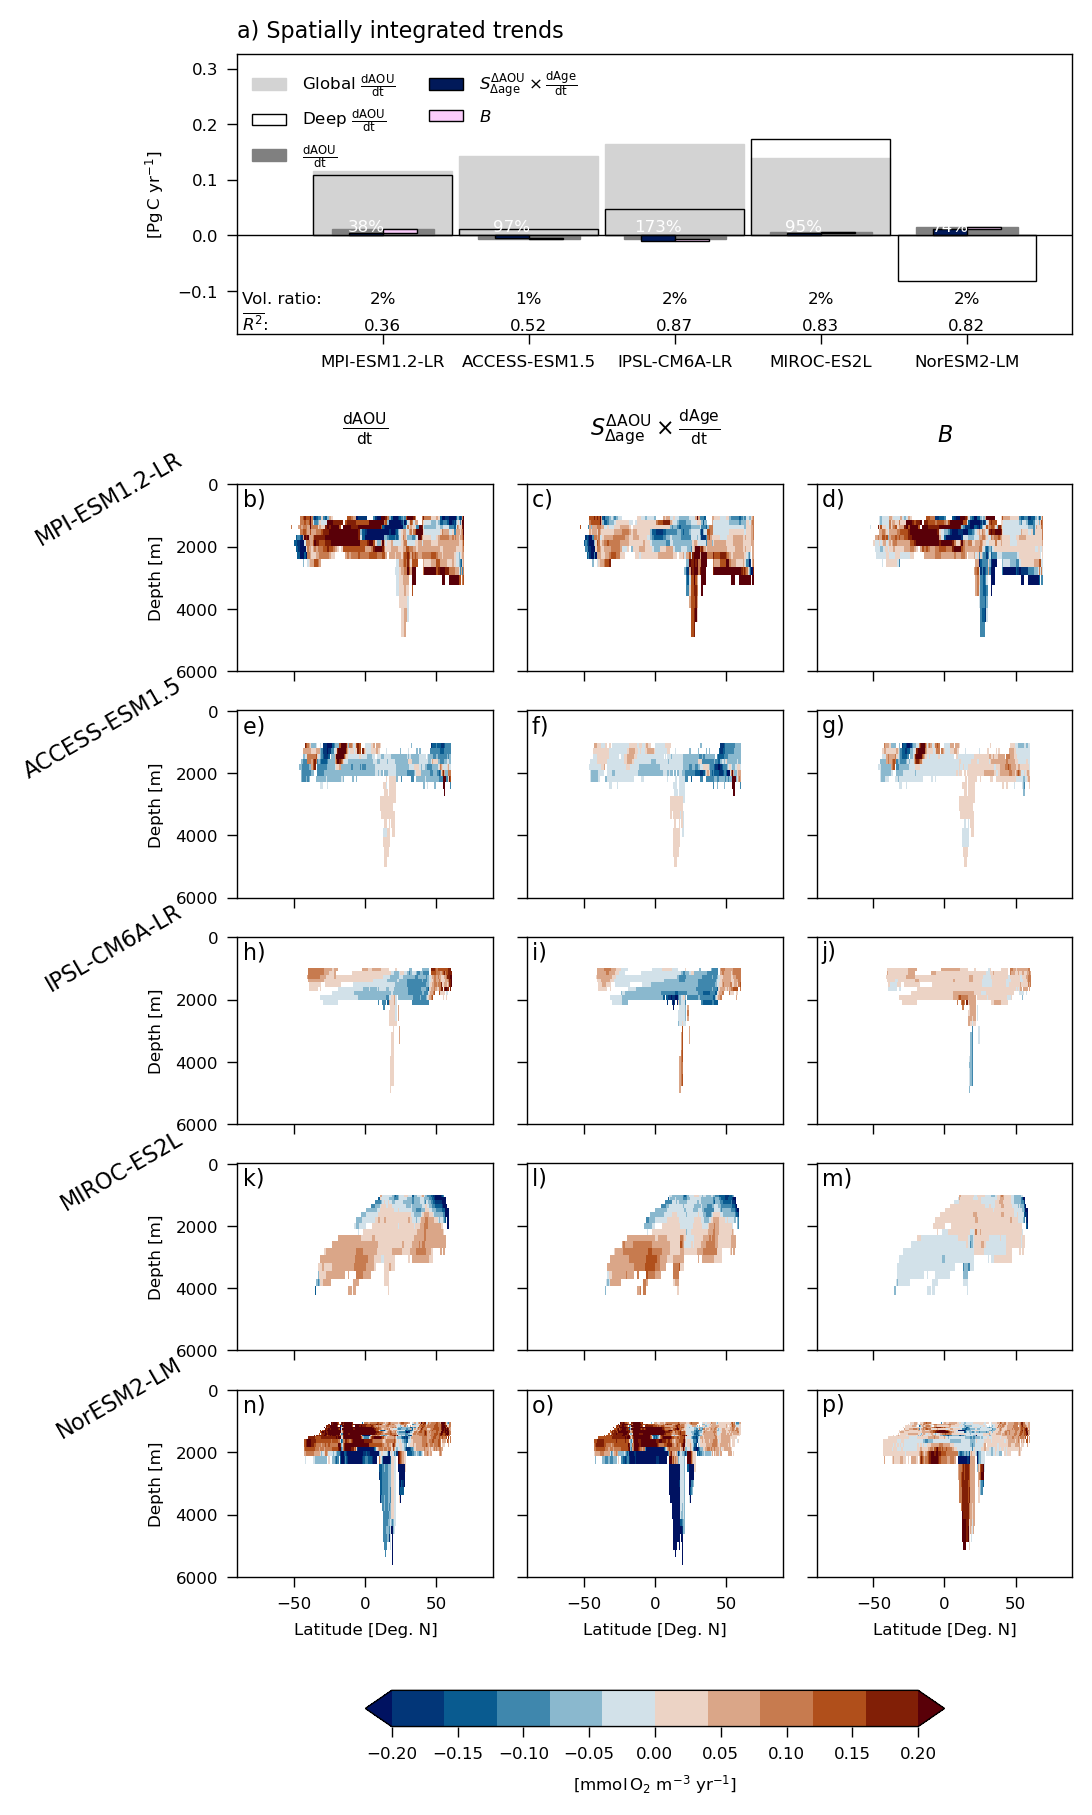

In [20]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute ∆AOU = OUR * ∆Age + intercept + residual')
print('## Plot each watermass')
print('### Plot')

#____________________
# Load data2plot

savefile = dirout + 'data2plot_AOUtrend_OURxAgetrend_reminder_1986-2009.pckl'
with open(savefile, 'rb') as file:
    data2plot1 = pickle.load(file)

#
savefile = dirout + 'data2plot_AOUtrend_OURxAgetrend_reminder_1986-2009_each_watermass.pckl'
with open(savefile, 'rb') as file:
    data2plot2 = pickle.load(file)

#
watermass='atlantic light significant'

#____________________
# Set figname for saving figure

figname = dirout + f'plot_AOUtrend_OURxAgetrend_reminder_1986-2009_'+watermass.replace(' ', '_')+'.png'

#--------------------
# Figure parameters
#--------------------

# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
esm_list = data2plot1['ESM']
section_list = ['∆AOU', '∆Age', 'reminder']

zfact_glob = 1e-18 * 117/170 * 12.01 # mmol-O -> PgC
zfact_section = 1

#______________
# Labels
labels_dict = {
    'Global ∆AOU': r'Global $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep ∆AOU': r'Deep $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep significant ∆AOU': r'Deep significant $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆AOU'       : r'$\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆Age'       : r'$S_{\mathrm{\Delta age}}^{\mathrm{\Delta AOU}} \times \frac{\mathrm{dAge}}{\mathrm{dt}}$',
    # 'reminder'   : r'$\mathrm{Age} \times \frac{\mathrm{dOUR}}{\mathrm{dt}}$',
    'reminder'  : r'$B$'
}

#______________
# barplot colors
barplot_color_dict = {
    'Global ∆AOU': 'lightgrey',
    '∆AOU': 'grey',
    '∆Age' : cmcrameri.cm.batlowS.colors[0],
    'reminder' : cmcrameri.cm.batlowS.colors[1]
}

#______________
# barplot kwargs
kwbar = dict(linewidth=0.5, align='center')
kwbar1 = dict(linewidth=.5, align='center', edgecolor='k')

#______________
# Sections axis labeling and limits
xlabel = 'Latitude [Deg. N]'
ylabel = 'Depth [m]'
xlim = (-90, 90)
ylim = (6000, -10)

#______________
# Section cmap
a = cmcrameri.cm.vik
colors = a(np.linspace(0,1,10+2))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[0])
newcmap.set_bad("none")

#______________
# Section pcm kwargs
kwpcm = dict(cmap=newcmap, vmin=-.2, vmax=.2)

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

# Pop one now to save a) for the barplot at the top
extended_alphabet_reverse.pop()

#______________
# Set figure
ncol = 3
nrow = len(esm_list)
fwidth_cm = 4
fheight_cm = 3
fsize = (fwidth_cm*cm2in*ncol, fheight_cm*cm2in*nrow) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, sharex='col', sharey='row')

#--------------------
# Plot sections
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    
    for iii, vvv in enumerate(section_list): 

        zwdata = data2plot2['xavg'][vvv][watermass][iesm]

        zax = ax[iesm, iii]
        xxx = zwdata['xxx']
        yyy = zwdata['yyy']
        ccc = zwdata['ccc'] * zfact_section
        # ccc = np.where(ccc!=0, ccc, np.nan)
        zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm)
        pcm[iesm, iii] = zwpcm
        zax.set_ylim(ylim)
        zax.set_xlim(xlim)

        zwtxt = extended_alphabet_reverse.pop() + f') '
        zax.text(.02, .98, zwtxt, transform=zax.transAxes, ha='left', va='top')

    #
#

#--------------------
# Decorate sections
#--------------------

fig.tight_layout()

for iesm, vesm in enumerate(esm_list) : 
    zax = ax[iesm, 0]
    zax.text(-.2, 1.2, esm_name_dict[vesm], transform=zax.transAxes, ha='right', va='top', rotation=30.)
#

for zax in ax[:, 0]: zax.set_ylabel(ylabel)
for zax in ax[-1, :]: zax.set_xlabel(xlabel)
        
for iii, vvv in enumerate(section_list): 
    zax = ax[0, iii]
    zax.text(.5, 1.2, labels_dict[vvv], transform=zax.transAxes, ha='center', va='bottom')
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[-1, 0].get_position()
zw2 = ax[-1, -1].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw2.y0 - .8*zw1.height
nw  = zw2.x0 + .5*zw2.width - nx0
nh  = 0.05*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='both')
clabel = '[mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]'
cbar.set_label(clabel)

#--------------------
# Add barplot
#--------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, -1].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .8*zw1.height
nw  = zw2.x1 - nx0
nh  = 1.5*zw1.height
zax = fig.add_axes([nx0, ny0, nw, nh])

#_________________
# Get x-ticks and xxx and www0 and www1
xxx = np.arange(len(esm_list))

www0 =  0.95
www1 =  0.7

#_________________
# ∆AOU

var = '∆AOU'

hhh = np.array(data2plot1['Global'][var]['total']) * zfact_glob
zax.bar(xxx, hhh, width=www0, label='Global ∆AOU', color=barplot_color_dict['Global '+var], edgecolor=barplot_color_dict['Global '+var], **kwbar)

hhh = np.array(data2plot1['Global'][var]['deep']) * zfact_glob
zax.bar(xxx, hhh, width=www0, label='Deep ∆AOU', color='none', edgecolor='k',  **kwbar)

# hhh = np.array(data2plot['Global'][var]['deep significant']) * zfact_glob
# zax.bar(xxx, hhh, width=www0, color='none', label='Deep significant ∆AOU', linewidth=.5, ls='--', edgecolor='red', align='center')

hhh = np.array(data2plot2['Global'][var][watermass]) * zfact_glob
zax.bar(xxx, hhh, width=www1, label=var, color=barplot_color_dict[var], edgecolor=barplot_color_dict[var], **kwbar)

nnn = 2
www2=www1/(nnn+1)

#_________________
# ∆Age
iii = 0
var = '∆Age'
hhh = np.array(data2plot2['Global'][var][watermass]) * zfact_glob
bbb = 0*hhh
xxx1 = xxx-(nnn-(1+2*iii))*www2/2
bars = zax.bar(xxx1, hhh, width=www2, color=barplot_color_dict[var], label=var, **kwbar1)

#_________________
# Reminder
iii = 1
var = 'reminder'
bbb += hhh
hhh = np.array(data2plot2['Global'][var][watermass]) * zfact_glob
xxx2 = xxx-(nnn-(1+2*iii))*www2/2
zax.bar(xxx2, hhh, bottom=bbb, width=www2, color=barplot_color_dict[var], label=var, **kwbar1)


#--------------------
# Decorate barplot
#--------------------

zax.axhline(0, c='k', lw=.5)

#____________________
# Set labels and title

ttl = 'a) Spatially integrated trends'
zax.set_title(ttl, loc='left')
zax.set_ylabel(r'[Pg$\,$C yr$^{-1}$]')
x_tick_labels = [esm_name_dict[vesm] for vesm in esm_list]
zax.set_xticks(xxx)
zax.set_xticklabels(x_tick_labels)

#____________________
# Adjust axis limits

ylim = zax.get_ylim()
dylim1 = 0.30*(ylim[1]-ylim[0])
dylim2 = 0.50*(ylim[1]-ylim[0])
ylim2 = (ylim[0]-dylim1, ylim[1]+dylim2)
zax.set_ylim(ylim2)

xlim = zax.get_xlim()
dxlim = 0.05*(xlim[1]-xlim[0])
xlim2 = (xlim[0]-dxlim, xlim[1])
zax.set_xlim(xlim2)

#____________________
# legend
aaa=zax.get_legend_handles_labels()
handles = aaa[0]
labels = [labels_dict[vvv] for vvv in aaa[1]]
zax.legend(handles, labels, frameon=False, handletextpad=1, ncol=2,\
           loc='upper left', bbox_to_anchor=(0, 1))


#--------------------
# Add R2 text
#--------------------
ylim = zax.get_ylim()
xlim = zax.get_xlim()

iii=0
ytext = ylim[0]+0.005*(ylim[1]-ylim[0])
for ind, val in enumerate(data2plot2['Global']['R2'][watermass]): 
    xtext = xxx[ind]
    zax.text( xtext, ytext, f'{val:.2f}', ha='center', va='bottom', size=6)
#
xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
zax.text(xtext, ytext, r'$\overline{R^2}$:', ha='left', va='bottom', size=6)


#--------------------
# Add volume text
#--------------------
iii=0
ytext = ylim[0]+0.1*(ylim[1]-ylim[0])
totvolume = data2plot1['Global']['volume']['total']
for ind, val in enumerate(data2plot2['Global']['volume'][watermass]): 
    xtext = xxx[ind]
    zax.text( xtext, ytext, f'{val/totvolume[ind]*100:.0f}%', ha='center', va='bottom', size=6)
#
xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
zax.text(xtext, ytext, r'Vol. ratio:', ha='left', va='bottom', size=6)

#--------------------
# Add share of dAge
#--------------------
iii=0
ytext = 0.005*(ylim[1]-ylim[0])
daou = data2plot2['Global']['∆AOU'][watermass]
for ind, val in enumerate(data2plot2['Global']['∆Age'][watermass]): 
    xtext = xxx1[ind]
    zax.text( xtext, ytext, f'{val/daou[ind]*100:.0f}%', c='white', ha='center', va='bottom', size=6)
#

#--------------------
# Print share of dAge
#--------------------
print('---- dAGE/dAOU ----')
daou = data2plot2['Global']['∆AOU'][watermass]
dage = data2plot2['Global']['∆Age'][watermass]
for ind, val in enumerate(data2plot2['ESM']): 
    print(f'{val}: {dage[ind]/daou[ind]*100:.0f}%')
#
print('-----------------')

#--------------------
# Print dAOU, dAge
#--------------------
print('---- dAGE, dAOU ----')
daou = data2plot2['Global']['∆AOU'][watermass]
dage = data2plot2['Global']['∆Age'][watermass]
for ind, val in enumerate(data2plot2['ESM']): 
    print(f'{val}: {dage[ind]*zfact_glob:.2f}, {daou[ind]*zfact_glob:.2f} [PgC/yr]')
#
print('-----------------')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)
